# House Price Prediction & Improvement Model

_Patrice Kontchou, Chase Rendal, Lu Yu, Zack Zbar_

_NYC DSA bootcamp, June, 2020_

## Table of Contents
1. [Data Preparation](#data)
2. [Lasso](#lasso)
3. [Elastic Net](#en)
4. [Random Forest](#rf)
5. [Multiple Linear Regression](#mlr)

In [215]:
## Packages Required
# data wrangling
import numpy as np
import pandas as pd
import math
# statistics
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
# machine learning
from sklearn import datasets, tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, KFold, StratifiedKFold, cross_val_score 
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
# ploting
import matplotlib.pyplot as plt
import seaborn as sns

In [216]:
## Settings
%matplotlib inline
#pd.describe_option('display')
pd.set_option('display.max_columns', None)  
pd.set_option('display.min_rows', 1) # combined with max_rows to show all rows 
pd.set_option('display.max_rows', None)  

## Data Input
<a id='data'></a>

In [434]:
## read in csv
trainf = pd.read_csv('../processed_data/train_full.csv')
traino = pd.read_csv('../processed_data/train_ordinal.csv')
traind = pd.read_csv('../processed_data/train_dummy.csv')
traindo = pd.read_csv('../processed_data/train_dummy_ordinal.csv')

In [435]:
## set Id as index
trainf = trainf.set_index('Id')
traino = traino.set_index('Id')
traind = traind.set_index('Id')
traindo = traindo.set_index('Id')

In [436]:
# check data set dimensions
print(trainf.shape)
print(traino.shape)
print(traind.shape)
print(traindo.shape)
'logSalePrice' in traino.columns

(1460, 81)
(1460, 84)
(1460, 286)
(1460, 226)


True

## Model Fitting

### _data set preparation: outlier exclusion & train test split_

In [744]:
df = traindo.copy() # use ordinal dummy data set: all columns numeric
drop_rows = df[df.index.isin([524, 1299])].index # high influential outliers of SalePrice, drop out reason stated in EDA
print("df shape before drop outlier rows:", df.shape) 
df.drop(drop_rows, inplace=True)
print("df shape after drop outlier rows:", df.shape)
#df.head()

df shape before drop outlier rows: (1460, 226)
df shape after drop outlier rows: (1458, 226)


In [745]:
## split to train & validation
xtrain, xtest, ytrain, ytest = train_test_split(df.drop(['SalePrice', 'logSalePrice'], axis = 1), df.logSalePrice, test_size = 0.2, random_state = 4)

### 1. Lasso Regression
<a id='lasso'></a>

### _grid search of Lasso_

In [746]:
## Gridsearch of Lasso
alphas = np.linspace(1e-5, 1e-2, 100)
params_lasso = [{'alpha':alphas, 'max_iter': [2000]}]
kf5 = KFold(n_splits = 5, shuffle = True, random_state = 4)
grid_lasso = GridSearchCV(estimator = Lasso(normalize=True), param_grid = params_lasso, cv = kf5, 
                          scoring = 'neg_mean_squared_error', return_train_score = True, refit = True)
grid_lasso.fit(xtrain, ytrain)

GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=True, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([1.00000000e-05, 1.10909091e-04, 2...
       8.48636364e-03, 8.58727273e-03, 8.68818182e-03, 8.78909091e-03,
       8.89000000e-03, 8.99090909e-03, 9.09181818e-03, 9.19272727e-03,
       9.29363636e-03, 9.39454545e-03, 9.49545455e-03, 9.59636364e-03,
       9.69727273e-03, 9.79818182e-03, 9.89909091e-03, 1.00000000e-02]),
                          'max_iter': [2000]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

In [747]:
model_lasso = grid_lasso.best_estimator_
print("Lasso best parameters are", grid_lasso.best_params_)
print("Lasso best train score is", round(model_lasso.score(xtrain, ytrain), ndigits=4))
print("Lasso best alpha is", round(grid_lasso.best_params_['alpha'], ndigits=5))
alpha_best_train = round(grid_lasso.best_params_['alpha'], ndigits=5)

Lasso best parameters are {'alpha': 0.00011090909090909092, 'max_iter': 2000}
Lasso best train score is 0.9298
Lasso best alpha is 0.00011


In [748]:
# # Lasso coefficients of significant predictors
# lasso_coef = pd.DataFrame(model_lasso.coef_, index = xtrain.columns, columns = ['coefficient']).sort_values(by = 'coefficient', ascending = False)
# lasso_coef_abs = pd.DataFrame({'abs_coef':abs(model_lasso.coef_), 'coef': model_lasso.coef_}, index = xtrain.columns).sort_values(by = 'abs_coef', ascending = False)
# lasso_coef_imp = lasso_coef_abs[lasso_coef_abs['abs_coef']>0]
# print(f"number of predictors before Lasso:", lasso_coef_abs.shape[0])
# print(f"number of predictors after Lasso:", lasso_coef_imp.shape[0])
# lasso_coef_imp.to_csv("../output/lasso_coef_imp.csv") # coef is for raw data, not for normalized data
# display(lasso_coef_imp)

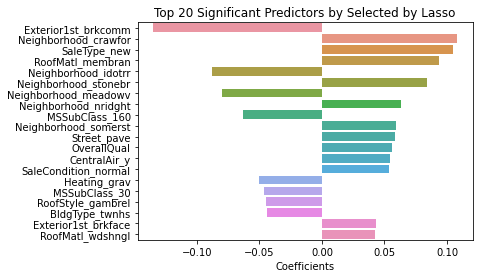

In [323]:
# # plot of top significant coefficients
# plot_df = lasso_coef_imp.iloc[:20, ]
# #plot_df['sign'] = ["negative" if plot_df["coef"] < 0 else "positive" for x in plot_df["abs_coef"] ]
# ax = sns.barplot(y = plot_df.index, x = "coef", data = plot_df)
# ax.set(xlabel = "Coefficients", title = "Top 20 Significant Predictors by Selected by Lasso")
# plt.savefig("../output/lasso_coef_imp_top20.png", bbox_inches = "tight")

In [288]:
# # Lasso model error: MSE & RMSE
# ytrain_lasso = model_lasso.predict(xtrain)
# ytest_lasso = model_lasso.predict(xtest)

# MSE = round(mean_squared_error(ytrain, ytrain_lasso), ndigits=4)
# RMSE = round(np.sqrt(mean_squared_error(ytrain, ytrain_lasso)), ndigits = 4) # no written function, need to manually calculate
# print("Best Lasso model MSE is", MSE)
# print("Best Lasso model RMSE is", RMSE)

Best Lasso model MSE is 0.0111
Best Lasso model RMSE is 0.1054


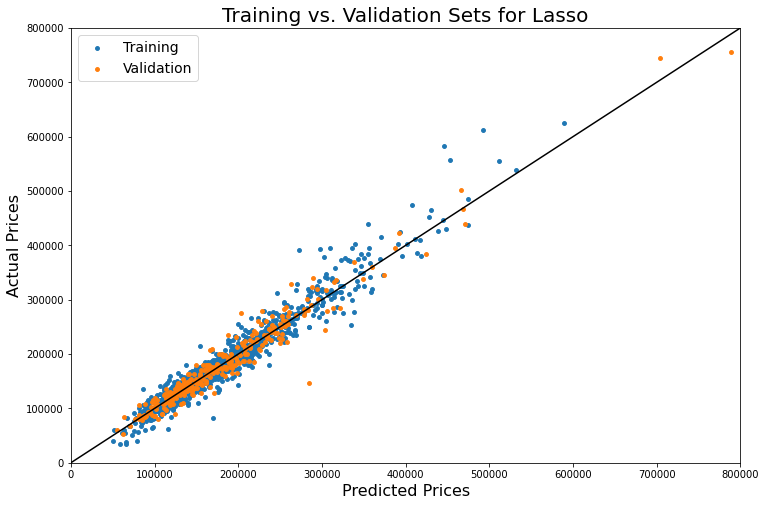

In [232]:
## plot error of train vs validation data
plt.figure(figsize=(12,8))
plt.scatter(np.exp(ytrain_lasso), np.exp(ytrain), marker="o", s=15, label = "Training")
plt.scatter(np.exp(ytest_lasso), np.exp(ytest), marker="o", s=15, label="Validation")
plt.title("Training vs. Validation Sets for Lasso", fontsize=20)
plt.xlabel("Predicted Prices", fontsize = 16)
plt.ylabel("Actual Prices", fontsize = 16)
plt.legend(loc = "upper left", fontsize = 14)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.plot([0, 800000], [0, 800000], 'black') # ideal predict-
#plt.show()
plt.savefig('../output/lasso_train_validation_compare.png')

### _hyperparameter alpha selection for plotting_

In [749]:
## single Lasso Pilot Test
lasso = Lasso(normalize=True, max_iter=2000)
#lasso.set_params(alpha = alpha_best_train)
lasso.set_params(alpha = alpha_least_overfit)
kf5 = KFold(n_splits = 5, shuffle = True, random_state = 4)

lasso.fit(xtrain, ytrain)
lasso_scores = cross_val_score(estimator = lasso, X = xtrain, y = ytrain, cv = kf5)
print("Lasso model best alpha is", alpha_best_train)
print("Lasso model least overfit alpha is", alpha_least_overfit)
print("Lasso cross least overfit validation score:", round(lasso_scores.mean(), ndigits=4))
print("Lasso train least overfit score", round(lasso.score(xtrain, ytrain), ndigits=4))

Lasso model best alpha is 0.00011
Lasso model least overfit alpha is 0.00082
Lasso cross least overfit validation score: 0.8743
Lasso train least overfit score 0.8741


In [750]:
## manual grid search of Lasso: varying alpha

lasso = Lasso(normalize=True, max_iter=2000)
alphas = np.linspace(1e-5, 1e-2, 100)

coefs = []
scores_cv = []
scores_train = []

# loop through all alpha values to get lasso coefficients, cv scores, and train scores
for alpha in alphas:
    lasso.set_params(alpha = alpha)
    lasso.fit(xtrain, ytrain)
    coefs.append(lasso.coef_)
    
    lasso_score_cv = cross_val_score(estimator = lasso, X = xtrain, y = ytrain, cv = kf5)
    scores_cv.append(lasso_score_cv)
    
    lasso_score_train = lasso.score(xtrain, ytrain)
    scores_train.append(lasso_score_train)

In [751]:
# lasso coef & score dataframe
coefs_lasso = pd.DataFrame(coefs, index = alphas, columns = xtrain.columns)

# compute & align train and validation score of the Lasso model
scores_cv_lasso = pd.DataFrame(scores_cv, index = alphas, columns = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5'])
scores_cv_lasso['validation_score'] = scores_cv_lasso.mean(axis =1)
scores_train_lasso = pd.DataFrame(scores_train, index = alphas, columns=["train_score"])
scores_lasso = pd.concat([scores_cv_lasso.validation_score, scores_train_lasso], axis=1)
scores_lasso.head()

,validation_score,train_score
0.000010,0.898988,0.945187
0.000111,0.909615,0.929758
0.000212,0.907189,0.920620
0.000313,0.901409,0.911185
0.000414,0.895685,0.902254


In [752]:
# ## Lasso important predictors
# lasso_coef_man = coefs_lasso[coefs_lasso.gt(0)].sum(axis = 0).sort_values(ascending = False) # lasso coefficient manual hyperparameter tuning
# lasso_coef_imp_man = lasso_coef[lasso_coef > 0]
# lasso_coef_imp_man[0:10]

Text(0.5, 1.0, 'Lasso Coefficients as a Function of the Regularization')

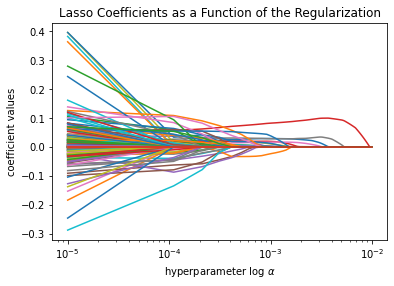

In [226]:
## Lasso plot: hyperparameter lambda
for name in coefs_lasso.columns:
    plt.plot(coefs_lasso.index, coefs_lasso[name])
    plt.xscale("log") # optional
plt.xlabel(r'hyperparameter log $\alpha$')
plt.ylabel(r'coefficient values')
plt.title('Lasso Coefficients as a Function of the Regularization')

In [714]:
scores_lasso['diff'] = abs(scores_lasso.train_score - scores_lasso.validation_score)
cv_train_close = scores_lasso[scores_lasso['diff'] == scores_lasso['diff'].min(axis = 0)]
#print(best_alpha)
alpha_least_overfit = round(cv_train_close.iloc[0 ,2], ndigits=5)
print("Lasso least overfit alpha", alpha_least_overfit)

Lasso least overfit alpha 0.00082


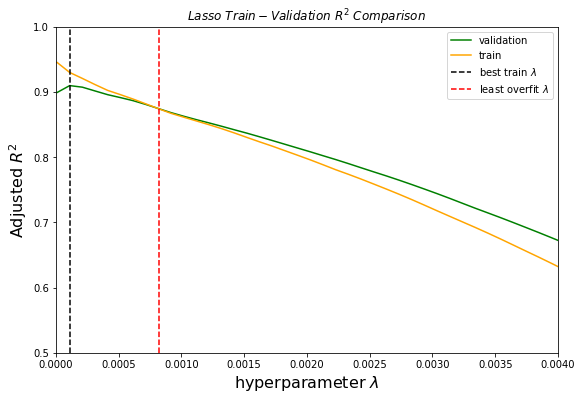

In [598]:
## Lasso plot: scores
# for name in scores_lasso.columns:
#     plt.plot(scores_lasso.index, scores_lasso[name], label = name)
plt.figure(figsize=(9,6))
scores_lasso['alpha'] = scores_lasso.index
plt.plot(scores_lasso.alpha, scores_lasso.validation_score, color = "green", label = "validation")
plt.plot(scores_lasso.alpha, scores_lasso.train_score, color = "orange", label = 'train')
plt.axvline(x = best_alpha, color = 'black', linestyle='dashed', label = r'best train $\lambda$')
plt.axvline(x = alpha_least_overfit, color = 'red', linestyle='dashed', label = r"least overfit $\lambda$")
#ax.set_xscale('log')
plt.legend(loc = 1)
plt.title(r"$Lasso\ Train-Validation\ R^2\ Comparison$")
plt.xlim(0, 0.004)
plt.ylim(0.5, 1)
plt.xlabel(r'hyperparameter $\lambda$', fontsize = 16)
plt.ylabel(r"Adjusted $R^2$", fontsize = 16)
plt.savefig("../output/lasso_train_validation_score.png")

In [724]:
# Selected Lasso Model
model_lasso = Lasso(normalize=True, max_iter=2000, alpha=alpha_least_overfit)
model_lasso.fit(xtrain, ytrain)

Lasso(alpha=0.00082, copy_X=True, fit_intercept=True, max_iter=2000,
      normalize=True, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [730]:
# Lasso model error: MSE & RMSE
ytrain_lasso = model_lasso.predict(xtrain)
ytest_lasso = model_lasso.predict(xtest)

RMSE = round(np.sqrt(mean_squared_error(ytrain, ytrain_lasso)), ndigits = 4) # no written function, need to manually calculate
print("Least overfit Lasso model train RMSE is", RMSE)

MSE = round(mean_squared_error(ytrain, ytrain_lasso), ndigits=4)
print("Least overfit Lasso model train MSE is", MSE)

MSE2 = round(mean_squared_error(ytest, ytest_lasso), ndigits=4)
print("Least overfit Lasso model validation MSE is", MSE)

Least overfit Lasso model train RMSE is 0.1624
Least overfit Lasso model train MSE is 0.0264
Least overfit Lasso model validation MSE is 0.0264


In [753]:
# Lasso coefficients of significant predictors
lasso_coef = pd.DataFrame(model_lasso.coef_, index = xtrain.columns, columns = ['coefficient']).sort_values(by = 'coefficient', ascending = False)
lasso_coef_abs = pd.DataFrame({'abs_coef':abs(model_lasso.coef_), 'coef': model_lasso.coef_}, index = xtrain.columns).sort_values(by = 'abs_coef', ascending = False)
lasso_coef_imp = lasso_coef_abs[lasso_coef_abs['abs_coef']>0]
print(f"number of predictors before Lasso:", lasso_coef_abs.shape[0])
print(f"number of predictors after Lasso:", lasso_coef_imp.shape[0])
#lasso_coef_imp.to_csv("../output/lasso_coef_imp.csv") # coef is for raw data, not for normalized data
display(lasso_coef_imp)

number of predictors before Lasso: 224
number of predictors after Lasso: 87


,abs_coef,coef
Exterior1st_brkcomm,0.135110,-0.135110
Neighborhood_crawfor,0.108209,0.108209
SaleType_new,0.104990,0.104990
RoofMatl_membran,0.093519,0.093519
Neighborhood_idotrr,0.087765,-0.087765
Neighborhood_stonebr,0.083641,0.083641
Neighborhood_meadowv,0.079556,-0.079556
Neighborhood_nridght,0.063402,0.063402
MSSubClass_160,0.062972,-0.062972
Neighborhood_somerst,0.059460,0.059460


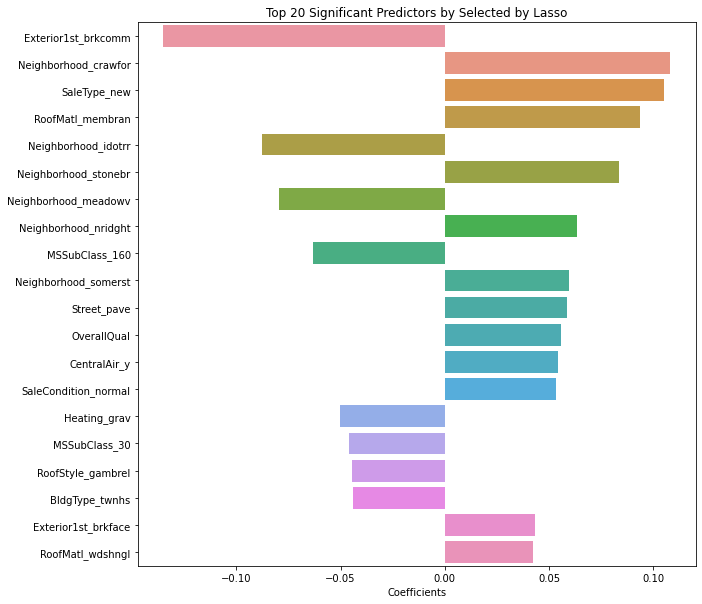

In [754]:
# plot of top significant coefficients
plot_df = lasso_coef_imp.iloc[:20, ]
#plot_df['sign'] = ["negative" if plot_df["coef"] < 0 else "positive" for x in plot_df["abs_coef"] ]
ax = sns.barplot(y = plot_df.index, x = "coef", data = plot_df)
ax.set(xlabel = "Coefficients", title = "Top 20 Significant Predictors by Selected by Lasso")
plt.savefig("../output/lasso_coef_imp_top20.png", bbox_inches = "tight")

## 2. Elastic Net
<a id='en'></a>

### _data frame set up_

In [766]:
## drop non-significant columns based on Lasso
df_reduce = df[lasso_coef_imp.index]
xtrain_reduce = xtrain[lasso_coef_imp.index]
xtest_reduce = xtest[lasso_coef_imp.index]
print("xtrain_reduce shape", xtrain_reduce.shape)
alpha_best_train

xtrain_reduce shape (1166, 87)


0.00011

### _grid search of Elastic Net_

In [717]:
## Gridsearch of ElasticNet

# set hyperparameter space
#alphas = np.linspace(1e-10, 10, 100)
alphas = np.linspace(1e-6, 10, 100)
rhos = np.linspace(0.1, 1, 10)
rhos = np.append(rhos, np.linspace(0.91, 0.99, 9))
# set Elestic Net model
params_elasticnet = [{'alpha': alphas, 'l1_ratio': rhos, 'max_iter': [1000, 2000]}]
kf5 = KFold(n_splits=5, shuffle=True, random_state=4)
grid_elasticnet = GridSearchCV(estimator=ElasticNet(normalize=True), param_grid=params_elasticnet, cv=kf5,
                               return_train_score=True, refit=True, verbose = 2)
%time grid_elasticnet.fit(xtrain_reduce, ytrain)

Fitting 5 folds for each of 3800 candidates, totalling 19000 fits
[CV] alpha=1e-06, l1_ratio=0.1, max_iter=1000 ........................
[CV] ......... alpha=1e-06, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.1, max_iter=1000 ........................
[CV] ......... alpha=1e-06, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.1, max_iter=1000 ........................
[CV] ......... alpha=1e-06, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.1, max_iter=1000 ........................
[CV] ......... alpha=1e-06, l1_ratio=0.1, max_iter=1000, total=   0.1s
[CV] alpha=1e-06, l1_ratio=0.1, max_iter=1000 ........................
[CV] ......... alpha=1e-06, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.1, max_iter=2000 ........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ......... alpha=1e-06, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.1, max_iter=2000 ........................
[CV] ......... alpha=1e-06, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.1, max_iter=2000 ........................
[CV] ......... alpha=1e-06, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.1, max_iter=2000 ........................
[CV] ......... alpha=1e-06, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.1, max_iter=2000 ........................
[CV] ......... alpha=1e-06, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.2, max_iter=1000 ........................
[CV] ......... alpha=1e-06, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.2, max_iter=1000 ........................
[CV] ......... alpha=1e-06, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.2, max_iter=1000 ........................
[CV] .

[CV]  alpha=1e-06, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.1s
[CV] alpha=1e-06, l1_ratio=0.7000000000000001, max_iter=2000 .........
[CV]  alpha=1e-06, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.8, max_iter=1000 ........................
[CV] ......... alpha=1e-06, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.8, max_iter=1000 ........................
[CV] ......... alpha=1e-06, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.8, max_iter=1000 ........................
[CV] ......... alpha=1e-06, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.8, max_iter=1000 ........................
[CV] ......... alpha=1e-06, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.8, max_iter=1000 ........................
[CV] ......... alpha=1e-06, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.8, max_iter=2000 ...................

[CV]  alpha=1e-06, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.9400000000000001, max_iter=1000 .........
[CV]  alpha=1e-06, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.9400000000000001, max_iter=1000 .........
[CV]  alpha=1e-06, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.9400000000000001, max_iter=2000 .........
[CV]  alpha=1e-06, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.9400000000000001, max_iter=2000 .........
[CV]  alpha=1e-06, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.9400000000000001, max_iter=2000 .........
[CV]  alpha=1e-06, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.9400000000000001, max_iter=2000 .........
[CV]  alpha=1e-06, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.940000

[CV]  alpha=0.10101109090909091, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.1, max_iter=2000 ..........
[CV]  alpha=0.10101109090909091, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.1, max_iter=2000 ..........
[CV]  alpha=0.10101109090909091, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.1, max_iter=2000 ..........
[CV]  alpha=0.10101109090909091, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.1, max_iter=2000 ..........
[CV]  alpha=0.10101109090909091, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.2, max_iter=1000 ..........
[CV]  alpha=0.10101109090909091, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.2, max_iter=1000 ..........
[CV]  alpha=0.10101109090909091, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0

[CV]  alpha=0.10101109090909091, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=0.10101109090909091, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=0.10101109090909091, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=0.10101109090909091, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=0.10101109090909091, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=0.10101109090909091, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.8, max_iter=1000 ..........
[CV

[CV]  alpha=0.10101109090909091, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.93, max_iter=2000 .........
[CV]  alpha=0.10101109090909091, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.93, max_iter=2000 .........
[CV]  alpha=0.10101109090909091, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.93, max_iter=2000 .........
[CV]  alpha=0.10101109090909091, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.93, max_iter=2000 .........
[CV]  alpha=0.10101109090909091, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=0.10101109090909091, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=0.10101109090909091, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.

[CV]  alpha=0.10101109090909091, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.99, max_iter=1000 .........
[CV]  alpha=0.10101109090909091, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.99, max_iter=1000 .........
[CV]  alpha=0.10101109090909091, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.99, max_iter=1000 .........
[CV]  alpha=0.10101109090909091, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.99, max_iter=2000 .........
[CV]  alpha=0.10101109090909091, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.99, max_iter=2000 .........
[CV]  alpha=0.10101109090909091, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.99, max_iter=2000 .........
[CV]  alpha=0.10101109090909091, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_

[CV]  alpha=0.20202118181818182, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=0.20202118181818182, l1_ratio=0.5, max_iter=2000 ..........
[CV]  alpha=0.20202118181818182, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=0.20202118181818182, l1_ratio=0.6, max_iter=1000 ..........
[CV]  alpha=0.20202118181818182, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=0.20202118181818182, l1_ratio=0.6, max_iter=1000 ..........
[CV]  alpha=0.20202118181818182, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=0.20202118181818182, l1_ratio=0.6, max_iter=1000 ..........
[CV]  alpha=0.20202118181818182, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=0.20202118181818182, l1_ratio=0.6, max_iter=1000 ..........
[CV]  alpha=0.20202118181818182, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=0.20202118181818182, l1_ratio=0.6, max_iter=1000 ..........
[CV]  alpha=0.20202118181818182, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=0.20202118181818182, l1_ratio=0

[CV]  alpha=0.20202118181818182, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=0.20202118181818182, l1_ratio=0.91, max_iter=2000 .........
[CV]  alpha=0.20202118181818182, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=0.20202118181818182, l1_ratio=0.91, max_iter=2000 .........
[CV]  alpha=0.20202118181818182, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=0.20202118181818182, l1_ratio=0.91, max_iter=2000 .........
[CV]  alpha=0.20202118181818182, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=0.20202118181818182, l1_ratio=0.92, max_iter=1000 .........
[CV]  alpha=0.20202118181818182, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=0.20202118181818182, l1_ratio=0.92, max_iter=1000 .........
[CV]  alpha=0.20202118181818182, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=0.20202118181818182, l1_ratio=0.92, max_iter=1000 .........
[CV]  alpha=0.20202118181818182, l1_ratio=0.92, max_iter=1000, total=   0.1s
[CV] alpha=0.20202118181818182, l1_

[CV]  alpha=0.20202118181818182, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=0.20202118181818182, l1_ratio=0.98, max_iter=1000 .........
[CV]  alpha=0.20202118181818182, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=0.20202118181818182, l1_ratio=0.98, max_iter=1000 .........
[CV]  alpha=0.20202118181818182, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=0.20202118181818182, l1_ratio=0.98, max_iter=1000 .........
[CV]  alpha=0.20202118181818182, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=0.20202118181818182, l1_ratio=0.98, max_iter=2000 .........
[CV]  alpha=0.20202118181818182, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=0.20202118181818182, l1_ratio=0.98, max_iter=2000 .........
[CV]  alpha=0.20202118181818182, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=0.20202118181818182, l1_ratio=0.98, max_iter=2000 .........
[CV]  alpha=0.20202118181818182, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=0.20202118181818182, l1_

[CV]  alpha=0.3030312727272727, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=0.3030312727272727, l1_ratio=0.5, max_iter=2000 ...........
[CV]  alpha=0.3030312727272727, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=0.3030312727272727, l1_ratio=0.5, max_iter=2000 ...........
[CV]  alpha=0.3030312727272727, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=0.3030312727272727, l1_ratio=0.5, max_iter=2000 ...........
[CV]  alpha=0.3030312727272727, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=0.3030312727272727, l1_ratio=0.6, max_iter=1000 ...........
[CV]  alpha=0.3030312727272727, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=0.3030312727272727, l1_ratio=0.6, max_iter=1000 ...........
[CV]  alpha=0.3030312727272727, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=0.3030312727272727, l1_ratio=0.6, max_iter=1000 ...........
[CV]  alpha=0.3030312727272727, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=0.3030312727272727, l1_ratio=0.6, max_

[CV]  alpha=0.3030312727272727, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=0.3030312727272727, l1_ratio=0.92, max_iter=1000 ..........
[CV]  alpha=0.3030312727272727, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=0.3030312727272727, l1_ratio=0.92, max_iter=1000 ..........
[CV]  alpha=0.3030312727272727, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=0.3030312727272727, l1_ratio=0.92, max_iter=2000 ..........
[CV]  alpha=0.3030312727272727, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=0.3030312727272727, l1_ratio=0.92, max_iter=2000 ..........
[CV]  alpha=0.3030312727272727, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=0.3030312727272727, l1_ratio=0.92, max_iter=2000 ..........
[CV]  alpha=0.3030312727272727, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=0.3030312727272727, l1_ratio=0.92, max_iter=2000 ..........
[CV]  alpha=0.3030312727272727, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=0.3030312727272727, l1_ratio=0.

[CV]  alpha=0.3030312727272727, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=0.3030312727272727, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=0.3030312727272727, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=0.3030312727272727, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=0.3030312727272727, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=0.3030312727272727, l1_ratio=0.98, max_iter=1000 ..........
[CV]  alpha=0.3030312727272727, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=0.3030312727272727, l1_ratio=0.98, max_iter=1000 ..........
[CV]  alpha=0.3030312727272727, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=0.3030312727272727, l1_ratio=0.98, max_iter=1000 ..........
[CV]  alpha=0.3030312727272727, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=0.3030312727272727, l1_ratio=0.98, max_iter=1000 ..........
[CV]  alpha=0.3030312727272727, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=0.3030312727272727, l1_ratio=0.

[CV]  alpha=0.4040413636363636, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=0.4040413636363636, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=0.4040413636363636, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=0.4040413636363636, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=0.4040413636363636, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=0.4040413636363636, l1_ratio=0.4, max_iter=2000 ...........
[CV]  alpha=0.4040413636363636, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=0.4040413636363636, l1_ratio=0.4, max_iter=2000 ...........
[CV]  alpha=0.4040413636363636, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=0.4040413636363636, l1_ratio=0.4, max_iter=2000 ...........
[CV]  alpha=0.4040413636363636, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=0.4040413636363636, l1_ratio=0.4, max_iter=2000 ...........
[CV]  alpha=0.4040413636363636, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=0.4040413636363636, l1_ratio=0.4, max_

[CV]  alpha=0.4040413636363636, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=0.4040413636363636, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=0.4040413636363636, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=0.4040413636363636, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=0.4040413636363636, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=0.4040413636363636, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=0.4040413636363636, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=0.4040413636363636, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=0.4040413636363636, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=0.4040413636363636, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=0.4040413636363636, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=0.4040413636363636, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=0.4040413636363636, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=0.4040413636363636, l1_ratio=0.9

[CV]  alpha=0.4040413636363636, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=0.4040413636363636, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=0.4040413636363636, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=0.4040413636363636, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=0.4040413636363636, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=0.4040413636363636, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=0.4040413636363636, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=0.4040413636363636, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=0.4040413636363636, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=0.4040413636363636, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=0.4040413636363636, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=0.4040413636363636, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=0.4040413636363636, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=0.4040413636363636, l1_ratio=0.

[CV]  alpha=0.5050514545454546, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=0.5050514545454546, l1_ratio=0.5, max_iter=1000 ...........
[CV]  alpha=0.5050514545454546, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=0.5050514545454546, l1_ratio=0.5, max_iter=1000 ...........
[CV]  alpha=0.5050514545454546, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=0.5050514545454546, l1_ratio=0.5, max_iter=1000 ...........
[CV]  alpha=0.5050514545454546, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=0.5050514545454546, l1_ratio=0.5, max_iter=1000 ...........
[CV]  alpha=0.5050514545454546, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=0.5050514545454546, l1_ratio=0.5, max_iter=2000 ...........
[CV]  alpha=0.5050514545454546, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=0.5050514545454546, l1_ratio=0.5, max_iter=2000 ...........
[CV]  alpha=0.5050514545454546, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=0.5050514545454546, l1_ratio=0.5, max_

[CV]  alpha=0.5050514545454546, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=0.5050514545454546, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=0.5050514545454546, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=0.5050514545454546, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=0.5050514545454546, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=0.5050514545454546, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=0.5050514545454546, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=0.5050514545454546, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=0.5050514545454546, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=0.5050514545454546, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=0.5050514545454546, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=0.5050514545454546, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=0.5050514545454546, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=0.5050514545454546, l1_ratio=0.9

[CV]  alpha=0.5050514545454546, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=0.5050514545454546, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=0.5050514545454546, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=0.5050514545454546, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=0.5050514545454546, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=0.5050514545454546, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=0.5050514545454546, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=0.5050514545454546, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=0.5050514545454546, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=0.5050514545454546, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=0.5050514545454546, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=0.5050514545454546, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=0.5050514545454546, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=0.5050514545454546, l1_ratio=0.

[CV]  alpha=0.6060615454545455, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.4, max_iter=2000 ...........
[CV]  alpha=0.6060615454545455, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.4, max_iter=2000 ...........
[CV]  alpha=0.6060615454545455, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.5, max_iter=1000 ...........
[CV]  alpha=0.6060615454545455, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.5, max_iter=1000 ...........
[CV]  alpha=0.6060615454545455, l1_ratio=0.5, max_iter=1000, total=   0.1s
[CV] alpha=0.6060615454545455, l1_ratio=0.5, max_iter=1000 ...........
[CV]  alpha=0.6060615454545455, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.5, max_iter=1000 ...........
[CV]  alpha=0.6060615454545455, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.5, max_

[CV]  alpha=0.6060615454545455, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=1.0, max_iter=2000 ...........
[CV]  alpha=0.6060615454545455, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=0.6060615454545455, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=0.6060615454545455, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=0.6060615454545455, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=0.6060615454545455, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=0.6060615454545455, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.91

[CV]  alpha=0.6060615454545455, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.96, max_iter=2000 ..........
[CV]  alpha=0.6060615454545455, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.96, max_iter=2000 ..........
[CV]  alpha=0.6060615454545455, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.96, max_iter=2000 ..........
[CV]  alpha=0.6060615454545455, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.96, max_iter=2000 ..........
[CV]  alpha=0.6060615454545455, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=0.6060615454545455, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=0.6060615454545455, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.

[CV]  alpha=0.7070716363636363, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=0.7070716363636363, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=0.7070716363636363, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=0.7070716363636363, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=0.7070716363636363, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=0.7070716363636363, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=0.7070716363636363, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=0.7070716363636363, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=0.7070716363636363, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=0.7070716363636363, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=0.7070716363636363, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=0.7070716363636363, l1_ratio=0.30000000000000004, max_iter=2000

[CV]  alpha=0.7070716363636363, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=0.7070716363636363, l1_ratio=0.9, max_iter=2000 ...........
[CV]  alpha=0.7070716363636363, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=0.7070716363636363, l1_ratio=0.9, max_iter=2000 ...........
[CV]  alpha=0.7070716363636363, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=0.7070716363636363, l1_ratio=0.9, max_iter=2000 ...........
[CV]  alpha=0.7070716363636363, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=0.7070716363636363, l1_ratio=1.0, max_iter=1000 ...........
[CV]  alpha=0.7070716363636363, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=0.7070716363636363, l1_ratio=1.0, max_iter=1000 ...........
[CV]  alpha=0.7070716363636363, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=0.7070716363636363, l1_ratio=1.0, max_iter=1000 ...........
[CV]  alpha=0.7070716363636363, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=0.7070716363636363, l1_ratio=1.0, max_

[CV] alpha=0.7070716363636363, l1_ratio=0.95, max_iter=1000 ..........
[CV]  alpha=0.7070716363636363, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=0.7070716363636363, l1_ratio=0.95, max_iter=1000 ..........
[CV]  alpha=0.7070716363636363, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=0.7070716363636363, l1_ratio=0.95, max_iter=2000 ..........
[CV]  alpha=0.7070716363636363, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=0.7070716363636363, l1_ratio=0.95, max_iter=2000 ..........
[CV]  alpha=0.7070716363636363, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=0.7070716363636363, l1_ratio=0.95, max_iter=2000 ..........
[CV]  alpha=0.7070716363636363, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=0.7070716363636363, l1_ratio=0.95, max_iter=2000 ..........
[CV]  alpha=0.7070716363636363, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=0.7070716363636363, l1_ratio=0.95, max_iter=2000 ..........
[CV]  alpha=0.7070716363636363, l1_ratio=0.95, 

[CV]  alpha=0.8080817272727273, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=0.8080817272727273, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=0.8080817272727273, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=0.8080817272727273, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=0.8080817272727273, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=0.8080817272727273, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=0.8080817272727273, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.2s
[CV] alpha=0.8080817272727273, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=0.8080817272727273, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.1s
[CV] alpha=0.8080817272727273, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=0.8080817272727273, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=0.8080817272727273, l1_ratio=0.30000000000000004, max_iter=2000

[CV]  alpha=0.8080817272727273, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=0.8080817272727273, l1_ratio=0.9, max_iter=2000 ...........
[CV]  alpha=0.8080817272727273, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=0.8080817272727273, l1_ratio=1.0, max_iter=1000 ...........
[CV]  alpha=0.8080817272727273, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=0.8080817272727273, l1_ratio=1.0, max_iter=1000 ...........
[CV]  alpha=0.8080817272727273, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=0.8080817272727273, l1_ratio=1.0, max_iter=1000 ...........
[CV]  alpha=0.8080817272727273, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=0.8080817272727273, l1_ratio=1.0, max_iter=1000 ...........
[CV]  alpha=0.8080817272727273, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=0.8080817272727273, l1_ratio=1.0, max_iter=1000 ...........
[CV]  alpha=0.8080817272727273, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=0.8080817272727273, l1_ratio=1.0, max_

[CV]  alpha=0.8080817272727273, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=0.8080817272727273, l1_ratio=0.96, max_iter=2000 ..........
[CV]  alpha=0.8080817272727273, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=0.8080817272727273, l1_ratio=0.96, max_iter=2000 ..........
[CV]  alpha=0.8080817272727273, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=0.8080817272727273, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=0.8080817272727273, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=0.8080817272727273, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=0.8080817272727273, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=0.8080817272727273, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=0.8080817272727273, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=0.8080817272727273, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=0.8080817272727273, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=0.8080817272727273, l1_ratio=0.

[CV]  alpha=0.9090918181818183, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=0.9090918181818183, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=0.9090918181818183, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=0.9090918181818183, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=0.9090918181818183, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=0.9090918181818183, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=0.9090918181818183, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=0.9090918181818183, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=0.9090918181818183, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=0.9090918181818183, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=0.9090918181818183, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=0.9090918181818183, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=0.9090918181818183, l1_ratio=0.4, max_iter=1000, total

[CV]  alpha=0.9090918181818183, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=0.9090918181818183, l1_ratio=1.0, max_iter=1000 ...........
[CV]  alpha=0.9090918181818183, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=0.9090918181818183, l1_ratio=1.0, max_iter=1000 ...........
[CV]  alpha=0.9090918181818183, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=0.9090918181818183, l1_ratio=1.0, max_iter=1000 ...........
[CV]  alpha=0.9090918181818183, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=0.9090918181818183, l1_ratio=1.0, max_iter=1000 ...........
[CV]  alpha=0.9090918181818183, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=0.9090918181818183, l1_ratio=1.0, max_iter=2000 ...........
[CV]  alpha=0.9090918181818183, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=0.9090918181818183, l1_ratio=1.0, max_iter=2000 ...........
[CV]  alpha=0.9090918181818183, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=0.9090918181818183, l1_ratio=1.0, max_

[CV]  alpha=0.9090918181818183, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=0.9090918181818183, l1_ratio=0.96, max_iter=2000 ..........
[CV]  alpha=0.9090918181818183, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=0.9090918181818183, l1_ratio=0.96, max_iter=2000 ..........
[CV]  alpha=0.9090918181818183, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=0.9090918181818183, l1_ratio=0.96, max_iter=2000 ..........
[CV]  alpha=0.9090918181818183, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=0.9090918181818183, l1_ratio=0.96, max_iter=2000 ..........
[CV]  alpha=0.9090918181818183, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=0.9090918181818183, l1_ratio=0.96, max_iter=2000 ..........
[CV]  alpha=0.9090918181818183, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=0.9090918181818183, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=0.9090918181818183, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=0.9090918181818183, l1_ratio=0.

[CV]  alpha=1.0101019090909091, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=1.0101019090909091, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=1.0101019090909091, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=1.0101019090909091, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=1.0101019090909091, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=1.0101019090909091, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=1.0101019090909091, l1_ratio=0.4,

[CV]  alpha=1.0101019090909091, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=1.0, max_iter=1000 ...........
[CV]  alpha=1.0101019090909091, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=1.0, max_iter=1000 ...........
[CV]  alpha=1.0101019090909091, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=1.0, max_iter=2000 ...........
[CV]  alpha=1.0101019090909091, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=1.0, max_iter=2000 ...........
[CV]  alpha=1.0101019090909091, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=1.0, max_iter=2000 ...........
[CV]  alpha=1.0101019090909091, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=1.0, max_iter=2000 ...........
[CV]  alpha=1.0101019090909091, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=1.0, max_

[CV]  alpha=1.0101019090909091, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=0.96, max_iter=2000 ..........
[CV]  alpha=1.0101019090909091, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=0.96, max_iter=2000 ..........
[CV]  alpha=1.0101019090909091, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=0.96, max_iter=2000 ..........
[CV]  alpha=1.0101019090909091, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=1.0101019090909091, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=1.0101019090909091, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=1.0101019090909091, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=0.

[CV]  alpha=1.1111119999999999, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=1.1111119999999999, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=1.1111119999999999, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=1.1111119999999999, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=1.1111119999999999, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=0.4, max_iter=2000 ...........
[CV]  alpha=1.1111119999999999, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=0.4, max_iter=2000 ...........
[CV]  alpha=1.1111119999999999, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=0.4, max_

[CV]  alpha=1.1111119999999999, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=1.0, max_iter=1000 ...........
[CV]  alpha=1.1111119999999999, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=1.0, max_iter=2000 ...........
[CV]  alpha=1.1111119999999999, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=1.0, max_iter=2000 ...........
[CV]  alpha=1.1111119999999999, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=1.0, max_iter=2000 ...........
[CV]  alpha=1.1111119999999999, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=1.0, max_iter=2000 ...........
[CV]  alpha=1.1111119999999999, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=1.0, max_iter=2000 ...........
[CV]  alpha=1.1111119999999999, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=0.91, max

[CV]  alpha=1.1111119999999999, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=0.95, max_iter=2000 ..........
[CV]  alpha=1.1111119999999999, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=0.96, max_iter=1000 ..........
[CV]  alpha=1.1111119999999999, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=0.96, max_iter=1000 ..........
[CV]  alpha=1.1111119999999999, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=0.96, max_iter=1000 ..........
[CV]  alpha=1.1111119999999999, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=0.96, max_iter=1000 ..........
[CV]  alpha=1.1111119999999999, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=0.96, max_iter=1000 ..........
[CV]  alpha=1.1111119999999999, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=0.

[CV]  alpha=1.2121220909090908, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=1.2121220909090908, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=1.2121220909090908, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=1.2121220909090908, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=1.2121220909090908, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=1.2121220909090908, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=1.2121220909090908, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=1.2121220909090908, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=1.2121220909090908, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=1.2121220909090908, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=1.2121220909090908, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=1.2121220909090908, l1_ratio=0.30000000000000004, max_iter=2000

[CV]  alpha=1.2121220909090908, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=1.2121220909090908, l1_ratio=0.9, max_iter=1000 ...........
[CV]  alpha=1.2121220909090908, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=1.2121220909090908, l1_ratio=0.9, max_iter=1000 ...........
[CV]  alpha=1.2121220909090908, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=1.2121220909090908, l1_ratio=0.9, max_iter=2000 ...........
[CV]  alpha=1.2121220909090908, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=1.2121220909090908, l1_ratio=0.9, max_iter=2000 ...........
[CV]  alpha=1.2121220909090908, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=1.2121220909090908, l1_ratio=0.9, max_iter=2000 ...........
[CV]  alpha=1.2121220909090908, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=1.2121220909090908, l1_ratio=0.9, max_iter=2000 ...........
[CV]  alpha=1.2121220909090908, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=1.2121220909090908, l1_ratio=0.9, max_

[CV]  alpha=1.2121220909090908, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=1.2121220909090908, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=1.2121220909090908, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=1.2121220909090908, l1_ratio=0.95, max_iter=1000 ..........
[CV]  alpha=1.2121220909090908, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=1.2121220909090908, l1_ratio=0.95, max_iter=1000 ..........
[CV]  alpha=1.2121220909090908, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=1.2121220909090908, l1_ratio=0.95, max_iter=1000 ..........
[CV]  alpha=1.2121220909090908, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=1.2121220909090908, l1_ratio=0.95, max_iter=1000 ..........
[CV]  alpha=1.2121220909090908, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=1.2121220909090908, l1_ratio=0.95, max_iter=1000 ..........
[CV]  alpha=1.2121220909090908, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha

[CV]  alpha=1.3131321818181818, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=0.2, max_iter=2000 ...........
[CV]  alpha=1.3131321818181818, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=0.2, max_iter=2000 ...........
[CV]  alpha=1.3131321818181818, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=0.2, max_iter=2000 ...........
[CV]  alpha=1.3131321818181818, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=0.2, max_iter=2000 ...........
[CV]  alpha=1.3131321818181818, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=1.3131321818181818, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=1.3131321818181818, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] al

[CV]  alpha=1.3131321818181818, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=0.8, max_iter=1000 ...........
[CV]  alpha=1.3131321818181818, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=0.8, max_iter=1000 ...........
[CV]  alpha=1.3131321818181818, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=0.8, max_iter=1000 ...........
[CV]  alpha=1.3131321818181818, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=0.8, max_iter=2000 ...........
[CV]  alpha=1.3131321818181818, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=0.8, max_iter=2000 ...........
[CV]  alpha=1.3131321818181818, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=0.8, max_iter=2000 ...........
[CV]  alpha=1.3131321818181818, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=0.8, max_

[CV]  alpha=1.3131321818181818, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=1.3131321818181818, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=1.3131321818181818, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=1.3131321818181818, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=1.3131321818181818, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=1.3131321818181818, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alph

[CV]  alpha=1.3131321818181818, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=0.99, max_iter=2000 ..........
[CV]  alpha=1.3131321818181818, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=0.99, max_iter=2000 ..........
[CV]  alpha=1.3131321818181818, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=0.99, max_iter=2000 ..........
[CV]  alpha=1.3131321818181818, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.1, max_iter=1000 ...........
[CV]  alpha=1.4141422727272726, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.1, max_iter=1000 ...........
[CV]  alpha=1.4141422727272726, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.1, max_iter=1000 ...........
[CV]  alpha=1.4141422727272726, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.1, 

[CV]  alpha=1.4141422727272726, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.6, max_iter=2000 ...........
[CV]  alpha=1.4141422727272726, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.6, max_iter=2000 ...........
[CV]  alpha=1.4141422727272726, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.6, max_iter=2000 ...........
[CV]  alpha=1.4141422727272726, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.6, max_iter=2000 ...........
[CV]  alpha=1.4141422727272726, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=1.4141422727272726, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=1.4141422727272726, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=

[CV]  alpha=1.4141422727272726, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.92, max_iter=2000 ..........
[CV]  alpha=1.4141422727272726, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.92, max_iter=2000 ..........
[CV]  alpha=1.4141422727272726, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.92, max_iter=2000 ..........
[CV]  alpha=1.4141422727272726, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.92, max_iter=2000 ..........
[CV]  alpha=1.4141422727272726, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.92, max_iter=2000 ..........
[CV]  alpha=1.4141422727272726, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.93, max_iter=1000 ..........
[CV]  alpha=1.4141422727272726, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.

[CV]  alpha=1.4141422727272726, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.98, max_iter=2000 ..........
[CV]  alpha=1.4141422727272726, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.98, max_iter=2000 ..........
[CV]  alpha=1.4141422727272726, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.98, max_iter=2000 ..........
[CV]  alpha=1.4141422727272726, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.98, max_iter=2000 ..........
[CV]  alpha=1.4141422727272726, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.99, max_iter=1000 ..........
[CV]  alpha=1.4141422727272726, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.99, max_iter=1000 ..........
[CV]  alpha=1.4141422727272726, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.

[CV]  alpha=1.5151523636363635, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.6, max_iter=1000 ...........
[CV]  alpha=1.5151523636363635, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.6, max_iter=1000 ...........
[CV]  alpha=1.5151523636363635, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.6, max_iter=1000 ...........
[CV]  alpha=1.5151523636363635, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.6, max_iter=1000 ...........
[CV]  alpha=1.5151523636363635, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.6, max_iter=1000 ...........
[CV]  alpha=1.5151523636363635, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.6, max_iter=2000 ...........
[CV]  alpha=1.5151523636363635, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.6, max_

[CV]  alpha=1.5151523636363635, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=1.5151523636363635, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=1.5151523636363635, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.92, max_iter=1000 ..........
[CV]  alpha=1.5151523636363635, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.92, max_iter=1000 ..........
[CV]  alpha=1.5151523636363635, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.92, max_iter=1000 ..........
[CV]  alpha=1.5151523636363635, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.92, max_iter=1000 ..........
[CV]  alpha=1.5151523636363635, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.

[CV]  alpha=1.5151523636363635, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.98, max_iter=1000 ..........
[CV]  alpha=1.5151523636363635, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.98, max_iter=1000 ..........
[CV]  alpha=1.5151523636363635, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.98, max_iter=2000 ..........
[CV]  alpha=1.5151523636363635, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.98, max_iter=2000 ..........
[CV]  alpha=1.5151523636363635, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.98, max_iter=2000 ..........
[CV]  alpha=1.5151523636363635, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.98, max_iter=2000 ..........
[CV]  alpha=1.5151523636363635, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.

[CV]  alpha=1.6161624545454545, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.4, max_iter=2000 ...........
[CV]  alpha=1.6161624545454545, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.4, max_iter=2000 ...........
[CV]  alpha=1.6161624545454545, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.5, max_iter=1000 ...........
[CV]  alpha=1.6161624545454545, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.5, max_iter=1000 ...........
[CV]  alpha=1.6161624545454545, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.5, max_iter=1000 ...........
[CV]  alpha=1.6161624545454545, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.5, max_iter=1000 ...........
[CV]  alpha=1.6161624545454545, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.5, max_

[CV]  alpha=1.6161624545454545, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=1.6161624545454545, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=1.6161624545454545, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=1.6161624545454545, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=1.6161624545454545, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=1.6161624545454545, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=1.6161624545454545, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.

[CV]  alpha=1.6161624545454545, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=1.6161624545454545, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=1.6161624545454545, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=1.6161624545454545, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.98, max_iter=1000 ..........
[CV]  alpha=1.6161624545454545, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.98, max_iter=1000 ..........
[CV]  alpha=1.6161624545454545, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.98, max_iter=1000 ..........
[CV]  alpha=1.6161624545454545, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.

[CV]  alpha=1.7171725454545455, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=0.5, max_iter=1000 ...........
[CV]  alpha=1.7171725454545455, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=0.5, max_iter=1000 ...........
[CV]  alpha=1.7171725454545455, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=0.5, max_iter=1000 ...........
[CV]  alpha=1.7171725454545455, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=0.5, max_iter=2000 ...........
[CV]  alpha=1.7171725454545455, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=0.5, max_iter=2000 ...........
[CV]  alpha=1.7171725454545455, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=0.5, max_iter=2000 ...........
[CV]  alpha=1.7171725454545455, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=0.5, max_

[CV]  alpha=1.7171725454545455, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=1.7171725454545455, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=1.7171725454545455, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=1.7171725454545455, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=1.7171725454545455, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=0.92, max_iter=1000 ..........
[CV]  alpha=1.7171725454545455, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=0.92, max_iter=1000 ..........
[CV]  alpha=1.7171725454545455, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=0.

[CV]  alpha=1.7171725454545455, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=1.7171725454545455, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=1.7171725454545455, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=1.7171725454545455, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=1.7171725454545455, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=0.98, max_iter=1000 ..........
[CV]  alpha=1.7171725454545455, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=0.98, max_iter=1000 ..........
[CV]  alpha=1.7171725454545455, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=0.

[CV]  alpha=1.8181826363636364, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=1.8181826363636364, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=1.8181826363636364, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=1.8181826363636364, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=1.8181826363636364, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=1.8181826363636364, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=1.8181826363636364, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=1.8181826363636364, l1_ratio=0.4, max_iter=2000 ...........
[CV]  alpha=1.8181826363636364, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=1.8181826363636364, l1_ratio=0.4, max_iter=2000 ...........
[CV]  alpha=1.8181826363636364, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=1.8181826363636364, l1_ratio=0.4, max_iter=2000 ...........
[CV]  alpha=1.8181826363636364, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=1.8181826363636364, l1_ratio=0.4, max_

[CV]  alpha=1.8181826363636364, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=1.8181826363636364, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=1.8181826363636364, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=1.8181826363636364, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=1.8181826363636364, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=1.8181826363636364, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=1.8181826363636364, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=1.8181826363636364, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=1.8181826363636364, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=1.8181826363636364, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=1.8181826363636364, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=1.8181826363636364, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=1.8181826363636364, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=1.8181826363636364, l1_ratio=0.

[CV]  alpha=1.8181826363636364, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=1.8181826363636364, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=1.8181826363636364, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=1.8181826363636364, l1_ratio=0.98, max_iter=1000 ..........
[CV]  alpha=1.8181826363636364, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=1.8181826363636364, l1_ratio=0.98, max_iter=1000 ..........
[CV]  alpha=1.8181826363636364, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=1.8181826363636364, l1_ratio=0.98, max_iter=1000 ..........
[CV]  alpha=1.8181826363636364, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=1.8181826363636364, l1_ratio=0.98, max_iter=1000 ..........
[CV]  alpha=1.8181826363636364, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=1.8181826363636364, l1_ratio=0.98, max_iter=1000 ..........
[CV]  alpha=1.8181826363636364, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=1.8181826363636364, l1_ratio=0.

[CV]  alpha=1.9191927272727272, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.5, max_iter=1000 ...........
[CV]  alpha=1.9191927272727272, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.5, max_iter=2000 ...........
[CV]  alpha=1.9191927272727272, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.5, max_iter=2000 ...........
[CV]  alpha=1.9191927272727272, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.5, max_iter=2000 ...........
[CV]  alpha=1.9191927272727272, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.5, max_iter=2000 ...........
[CV]  alpha=1.9191927272727272, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.5, max_iter=2000 ...........
[CV]  alpha=1.9191927272727272, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.6, max_

[CV]  alpha=1.9191927272727272, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=1.9191927272727272, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=1.9191927272727272, l1_ratio=0.91, max_iter=1000, total=   0.1s
[CV] alpha=1.9191927272727272, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=1.9191927272727272, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=1.9191927272727272, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=1.9191927272727272, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=1.9191927272727272, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.

[CV]  alpha=1.9191927272727272, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.96, max_iter=2000 ..........
[CV]  alpha=1.9191927272727272, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=1.9191927272727272, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=1.9191927272727272, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=1.9191927272727272, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=1.9191927272727272, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=1.9191927272727272, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.

[CV]  alpha=2.0202028181818186, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=2.0202028181818186, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=2.0202028181818186, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=2.0202028181818186, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=2.0202028181818186, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=0.4, max_iter=2000 ...........
[CV]  alpha=2.0202028181818186, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=0.4, max_iter=2000 ...........
[CV]  alpha=2.0202028181818186, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=0.4, max_

[CV]  alpha=2.0202028181818186, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=1.0, max_iter=1000 ...........
[CV]  alpha=2.0202028181818186, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=1.0, max_iter=2000 ...........
[CV]  alpha=2.0202028181818186, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=1.0, max_iter=2000 ...........
[CV]  alpha=2.0202028181818186, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=1.0, max_iter=2000 ...........
[CV]  alpha=2.0202028181818186, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=1.0, max_iter=2000 ...........
[CV]  alpha=2.0202028181818186, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=1.0, max_iter=2000 ...........
[CV]  alpha=2.0202028181818186, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=0.91, max

[CV]  alpha=2.0202028181818186, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=0.96, max_iter=2000 ..........
[CV]  alpha=2.0202028181818186, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=0.96, max_iter=2000 ..........
[CV]  alpha=2.0202028181818186, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=0.96, max_iter=2000 ..........
[CV]  alpha=2.0202028181818186, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=2.0202028181818186, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=2.0202028181818186, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=2.0202028181818186, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=0.

[CV]  alpha=2.121212909090909, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=2.121212909090909, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=2.121212909090909, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=2.121212909090909, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=2.121212909090909, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=2.121212909090909, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=2.121212909090909, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=0

[CV]  alpha=2.121212909090909, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=2.121212909090909, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=2.121212909090909, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=2.121212909090909, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=2.121212909090909, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=2.121212909090909, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=2.121212909090909, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=0.91, max_ite

[CV]  alpha=2.121212909090909, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=2.121212909090909, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=2.121212909090909, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=2.121212909090909, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=2.121212909090909, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=2.121212909090909, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=2.121212909090909, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=0.97, max_

[CV] ...... alpha=2.222223, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=2.222223, l1_ratio=0.4, max_iter=1000 .....................
[CV] ...... alpha=2.222223, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=2.222223, l1_ratio=0.4, max_iter=1000 .....................
[CV] ...... alpha=2.222223, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=2.222223, l1_ratio=0.4, max_iter=1000 .....................
[CV] ...... alpha=2.222223, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=2.222223, l1_ratio=0.4, max_iter=1000 .....................
[CV] ...... alpha=2.222223, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=2.222223, l1_ratio=0.4, max_iter=2000 .....................
[CV] ...... alpha=2.222223, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=2.222223, l1_ratio=0.4, max_iter=2000 .....................
[CV] ...... alpha=2.222223, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=2.222223, l1_ratio=0.4, max_iter=2000 .....................
[CV] .

[CV] ...... alpha=2.222223, l1_ratio=0.9, max_iter=2000, total=   0.1s
[CV] alpha=2.222223, l1_ratio=0.9, max_iter=2000 .....................
[CV] ...... alpha=2.222223, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=2.222223, l1_ratio=1.0, max_iter=1000 .....................
[CV] ...... alpha=2.222223, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=2.222223, l1_ratio=1.0, max_iter=1000 .....................
[CV] ...... alpha=2.222223, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=2.222223, l1_ratio=1.0, max_iter=1000 .....................
[CV] ...... alpha=2.222223, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=2.222223, l1_ratio=1.0, max_iter=1000 .....................
[CV] ...... alpha=2.222223, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=2.222223, l1_ratio=1.0, max_iter=1000 .....................
[CV] ...... alpha=2.222223, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=2.222223, l1_ratio=1.0, max_iter=2000 .....................
[CV] .

[CV] ..... alpha=2.222223, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=2.222223, l1_ratio=0.96, max_iter=1000 ....................
[CV] ..... alpha=2.222223, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=2.222223, l1_ratio=0.96, max_iter=1000 ....................
[CV] ..... alpha=2.222223, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=2.222223, l1_ratio=0.96, max_iter=1000 ....................
[CV] ..... alpha=2.222223, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=2.222223, l1_ratio=0.96, max_iter=1000 ....................
[CV] ..... alpha=2.222223, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=2.222223, l1_ratio=0.96, max_iter=2000 ....................
[CV] ..... alpha=2.222223, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=2.222223, l1_ratio=0.96, max_iter=2000 ....................
[CV] ..... alpha=2.222223, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=2.222223, l1_ratio=0.96, max_iter=2000 ....................
[CV] .

[CV]  alpha=2.323233090909091, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=2.323233090909091, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=2.323233090909091, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=2.323233090909091, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=2.323233090909091, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=2.323233090909091, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=2.323233090909091, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=2.323233090909091, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=2.323233090909091, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=2.323233090909091, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=2.323233090909091, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=2.323233090909091, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=2.323233090909091, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=2.3232330

[CV]  alpha=2.323233090909091, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=2.323233090909091, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=2.323233090909091, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=2.323233090909091, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=2.323233090909091, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=2.323233090909091, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=2.323233090909091, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=2.323233090909091, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=2.323233090909091, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=2.323233090909091, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=2.323233090909091, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=2.323233090909091, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=2.323233090909091, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=2.323233090909091, l1_ratio=1.0, max_iter=200

[CV]  alpha=2.323233090909091, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=2.323233090909091, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=2.323233090909091, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=2.323233090909091, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=2.323233090909091, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=2.323233090909091, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=2.323233090909091, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=2.323233090909091, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=2.323233090909091, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=2.323233090909091, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=2.323233090909091, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=2.323233090909091, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=2.323233090909091, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=2.323233090909091, l1_ratio=0.97, max_

[CV]  alpha=2.424243181818182, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=2.424243181818182, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=2.424243181818182, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.1s
[CV] alpha=2.424243181818182, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=2.424243181818182, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=2.424243181818182, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=2.424243181818182, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=2.424243181818182, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=2.424243181818182, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=2.424243181818182, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=2.424243181818182, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=2.424243181818182, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alph

[CV]  alpha=2.424243181818182, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=2.424243181818182, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=2.424243181818182, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=2.424243181818182, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=2.424243181818182, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=2.424243181818182, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=2.424243181818182, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=2.424243181818182, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=2.424243181818182, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=2.424243181818182, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=2.424243181818182, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=2.424243181818182, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=2.424243181818182, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=2.424243181818182, l1_ratio=0.9, max_iter=100

[CV]  alpha=2.424243181818182, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=2.424243181818182, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=2.424243181818182, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=2.424243181818182, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=2.424243181818182, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=2.424243181818182, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=2.424243181818182, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=2.424243181818182, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=2.424243181818182, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=2.424243181818182, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=2.424243181818182, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=2.424243181818182, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=2.424243181818182, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=2.424243181818182, l1_ratio=0.95, max_

[CV]  alpha=2.525253272727273, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=2.525253272727273, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=2.525253272727273, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=2.525253272727273, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=2.525253272727273, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=2.525253272727273, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=2.525253272727273, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.2, max_iter=200

[CV]  alpha=2.525253272727273, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=2.525253272727273, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=2.525253272727273, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=2.525253272727273, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=2.525253272727273, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=2.525253272727273, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=2.525253272727273, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.

[CV] alpha=2.525253272727273, l1_ratio=0.93, max_iter=2000 ...........
[CV]  alpha=2.525253272727273, l1_ratio=0.93, max_iter=2000, total=   0.1s
[CV] alpha=2.525253272727273, l1_ratio=0.93, max_iter=2000 ...........
[CV]  alpha=2.525253272727273, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=2.525253272727273, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=2.525253272727273, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=2.525253272727273, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=2.525253272727273, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.940000000000000

[CV]  alpha=2.626263363636364, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=2.626263363636364, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=2.626263363636364, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=2.626263363636364, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=2.626263363636364, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=2.626263363636364, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=2.626263363636364, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=2.626263363636364, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=2.626263363636364, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=2.626263363636364, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=2.626263363636364, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=2.626263363636364, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=2.626263363636364, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=2.626263363636364, l1_ratio=0.2, max_iter=200

[CV]  alpha=2.626263363636364, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=2.626263363636364, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=2.626263363636364, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=2.626263363636364, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=2.626263363636364, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=2.626263363636364, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=2.626263363636364, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=2.626263363636364, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=2.626263363636364, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=2.626263363636364, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=2.626263363636364, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=2.626263363636364, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=2.626263363636364, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=2.626263363636364, l1_ratio=0.9, max_iter=100

[CV]  alpha=2.626263363636364, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=2.626263363636364, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=2.626263363636364, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=2.626263363636364, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=2.626263363636364, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=2.626263363636364, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=2.626263363636364, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=2.626263363636364, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=2.626263363636364, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=2.626263363636364, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=2.626263363636364, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=2.626263363636364, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=2.62626336

[CV]  alpha=2.727273454545455, l1_ratio=0.1, max_iter=2000, total=   0.1s
[CV] alpha=2.727273454545455, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=2.727273454545455, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=2.727273454545455, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=2.727273454545455, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=2.727273454545455, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=2.727273454545455, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=2.727273454545455, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=2.727273454545455, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=2.727273454545455, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=2.727273454545455, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=2.727273454545455, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=2.727273454545455, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=2.727273454545455, l1_ratio=0.2, max_iter=100

[CV]  alpha=2.727273454545455, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=2.727273454545455, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=2.727273454545455, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=2.727273454545455, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=2.727273454545455, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=2.727273454545455, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=2.727273454545455, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=2.727273454545455, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=2.727273454545455, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=2.727273454545455, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=2.727273454545455, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=2.727273454545455, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=2.727273454545455, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=2.7272734545

[CV]  alpha=2.727273454545455, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=2.727273454545455, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=2.727273454545455, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=2.727273454545455, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=2.727273454545455, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=2.727273454545455, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=2.727273454545455, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=2.727273454545455, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=2.727273454545455, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=2.727273454545455, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=2.727273454545455, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=2.727273454545455, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=2.72727345

[CV]  alpha=2.8282835454545454, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=2.8282835454545454, l1_ratio=0.2, max_iter=1000 ...........
[CV]  alpha=2.8282835454545454, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=2.8282835454545454, l1_ratio=0.2, max_iter=1000 ...........
[CV]  alpha=2.8282835454545454, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=2.8282835454545454, l1_ratio=0.2, max_iter=1000 ...........
[CV]  alpha=2.8282835454545454, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=2.8282835454545454, l1_ratio=0.2, max_iter=1000 ...........
[CV]  alpha=2.8282835454545454, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=2.8282835454545454, l1_ratio=0.2, max_iter=1000 ...........
[CV]  alpha=2.8282835454545454, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=2.8282835454545454, l1_ratio=0.2, max_iter=2000 ...........
[CV]  alpha=2.8282835454545454, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=2.8282835454545454, l1_ratio=0.2, max_

[CV] alpha=2.8282835454545454, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=2.8282835454545454, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=2.8282835454545454, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=2.8282835454545454, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=2.8282835454545454, l1_ratio=0.8, max_iter=1000 ...........
[CV]  alpha=2.8282835454545454, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=2.8282835454545454, l1_ratio=0.8, max_iter=1000 ...........
[CV]  alpha=2.8282835454545454, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=2.8282835454545454, l1_ratio=0.8, max_iter=1000 ...........
[CV]  alpha=2.8282835454545454, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=2.8282835454545454, l1_ratio=0.8, max_iter=1000 ...........
[CV]  alpha=2.8282835454545454, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=2.8282835454545454, l1_ratio=0.8, max_iter=1000 ...........
[CV]  alpha=2.8

[CV]  alpha=2.8282835454545454, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=2.8282835454545454, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=2.8282835454545454, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=2.8282835454545454, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=2.8282835454545454, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=2.8282835454545454, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=2.8282835454545454, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=2.8282835454545454, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=2.8282835454545454, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=2.8282835454545454, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=2.8282835454545454, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=2.8282835454545454, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alph

[CV]  alpha=2.8282835454545454, l1_ratio=0.99, max_iter=2000, total=   0.1s
[CV] alpha=2.8282835454545454, l1_ratio=0.99, max_iter=2000 ..........
[CV]  alpha=2.8282835454545454, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=2.8282835454545454, l1_ratio=0.99, max_iter=2000 ..........
[CV]  alpha=2.8282835454545454, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.1, max_iter=1000 ...........
[CV]  alpha=2.9292936363636364, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.1, max_iter=1000 ...........
[CV]  alpha=2.9292936363636364, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.1, max_iter=1000 ...........
[CV]  alpha=2.9292936363636364, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.1, max_iter=1000 ...........
[CV]  alpha=2.9292936363636364, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.1, m

[CV]  alpha=2.9292936363636364, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.6, max_iter=1000 ...........
[CV]  alpha=2.9292936363636364, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.6, max_iter=1000 ...........
[CV]  alpha=2.9292936363636364, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.6, max_iter=2000 ...........
[CV]  alpha=2.9292936363636364, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.6, max_iter=2000 ...........
[CV]  alpha=2.9292936363636364, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.6, max_iter=2000 ...........
[CV]  alpha=2.9292936363636364, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.6, max_iter=2000 ...........
[CV]  alpha=2.9292936363636364, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.6, max_

[CV]  alpha=2.9292936363636364, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.92, max_iter=2000 ..........
[CV]  alpha=2.9292936363636364, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.92, max_iter=2000 ..........
[CV]  alpha=2.9292936363636364, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.92, max_iter=2000 ..........
[CV]  alpha=2.9292936363636364, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.92, max_iter=2000 ..........
[CV]  alpha=2.9292936363636364, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.92, max_iter=2000 ..........
[CV]  alpha=2.9292936363636364, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.93, max_iter=1000 ..........
[CV]  alpha=2.9292936363636364, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.

[CV]  alpha=2.9292936363636364, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.98, max_iter=2000 ..........
[CV]  alpha=2.9292936363636364, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.98, max_iter=2000 ..........
[CV]  alpha=2.9292936363636364, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.99, max_iter=1000 ..........
[CV]  alpha=2.9292936363636364, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.99, max_iter=1000 ..........
[CV]  alpha=2.9292936363636364, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.99, max_iter=1000 ..........
[CV]  alpha=2.9292936363636364, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.99, max_iter=1000 ..........
[CV]  alpha=2.9292936363636364, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.

[CV]  alpha=3.0303037272727273, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=3.0303037272727273, l1_ratio=0.6, max_iter=2000 ...........
[CV]  alpha=3.0303037272727273, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=3.0303037272727273, l1_ratio=0.6, max_iter=2000 ...........
[CV]  alpha=3.0303037272727273, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=3.0303037272727273, l1_ratio=0.6, max_iter=2000 ...........
[CV]  alpha=3.0303037272727273, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=3.0303037272727273, l1_ratio=0.6, max_iter=2000 ...........
[CV]  alpha=3.0303037272727273, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=3.0303037272727273, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=3.0303037272727273, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=3.0303037272727273, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=3.0303037272727273, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=

[CV]  alpha=3.0303037272727273, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=3.0303037272727273, l1_ratio=0.93, max_iter=1000 ..........
[CV]  alpha=3.0303037272727273, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=3.0303037272727273, l1_ratio=0.93, max_iter=1000 ..........
[CV]  alpha=3.0303037272727273, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=3.0303037272727273, l1_ratio=0.93, max_iter=1000 ..........
[CV]  alpha=3.0303037272727273, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=3.0303037272727273, l1_ratio=0.93, max_iter=2000 ..........
[CV]  alpha=3.0303037272727273, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=3.0303037272727273, l1_ratio=0.93, max_iter=2000 ..........
[CV]  alpha=3.0303037272727273, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=3.0303037272727273, l1_ratio=0.93, max_iter=2000 ..........
[CV]  alpha=3.0303037272727273, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=3.0303037272727273, l1_ratio=0.

[CV]  alpha=3.0303037272727273, l1_ratio=0.98, max_iter=2000, total=   0.1s
[CV] alpha=3.0303037272727273, l1_ratio=0.98, max_iter=2000 ..........
[CV]  alpha=3.0303037272727273, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=3.0303037272727273, l1_ratio=0.98, max_iter=2000 ..........
[CV]  alpha=3.0303037272727273, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=3.0303037272727273, l1_ratio=0.98, max_iter=2000 ..........
[CV]  alpha=3.0303037272727273, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=3.0303037272727273, l1_ratio=0.99, max_iter=1000 ..........
[CV]  alpha=3.0303037272727273, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=3.0303037272727273, l1_ratio=0.99, max_iter=1000 ..........
[CV]  alpha=3.0303037272727273, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=3.0303037272727273, l1_ratio=0.99, max_iter=1000 ..........
[CV]  alpha=3.0303037272727273, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=3.0303037272727273, l1_ratio=0.

[CV]  alpha=3.1313138181818183, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=3.1313138181818183, l1_ratio=0.5, max_iter=1000 ...........
[CV]  alpha=3.1313138181818183, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=3.1313138181818183, l1_ratio=0.5, max_iter=2000 ...........
[CV]  alpha=3.1313138181818183, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=3.1313138181818183, l1_ratio=0.5, max_iter=2000 ...........
[CV]  alpha=3.1313138181818183, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=3.1313138181818183, l1_ratio=0.5, max_iter=2000 ...........
[CV]  alpha=3.1313138181818183, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=3.1313138181818183, l1_ratio=0.5, max_iter=2000 ...........
[CV]  alpha=3.1313138181818183, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=3.1313138181818183, l1_ratio=0.5, max_iter=2000 ...........
[CV]  alpha=3.1313138181818183, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=3.1313138181818183, l1_ratio=0.6, max_

[CV]  alpha=3.1313138181818183, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=3.1313138181818183, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=3.1313138181818183, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=3.1313138181818183, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=3.1313138181818183, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=3.1313138181818183, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=3.1313138181818183, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=3.1313138181818183, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=3.1313138181818183, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=3.1313138181818183, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=3.1313138181818183, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=3.1313138181818183, l1_ratio=0.92, max_iter=1000 ..........
[CV]  alpha=3.1313138181818183, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=3.1313138181818183, l1_ratio=0.

[CV]  alpha=3.1313138181818183, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=3.1313138181818183, l1_ratio=0.98, max_iter=1000 ..........
[CV]  alpha=3.1313138181818183, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=3.1313138181818183, l1_ratio=0.98, max_iter=1000 ..........
[CV]  alpha=3.1313138181818183, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=3.1313138181818183, l1_ratio=0.98, max_iter=2000 ..........
[CV]  alpha=3.1313138181818183, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=3.1313138181818183, l1_ratio=0.98, max_iter=2000 ..........
[CV]  alpha=3.1313138181818183, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=3.1313138181818183, l1_ratio=0.98, max_iter=2000 ..........
[CV]  alpha=3.1313138181818183, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=3.1313138181818183, l1_ratio=0.98, max_iter=2000 ..........
[CV]  alpha=3.1313138181818183, l1_ratio=0.98, max_iter=2000, total=   0.1s
[CV] alpha=3.1313138181818183, l1_ratio=0.

[CV]  alpha=3.2323239090909093, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=0.4, max_iter=2000 ...........
[CV]  alpha=3.2323239090909093, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=0.5, max_iter=1000 ...........
[CV]  alpha=3.2323239090909093, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=0.5, max_iter=1000 ...........
[CV]  alpha=3.2323239090909093, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=0.5, max_iter=1000 ...........
[CV]  alpha=3.2323239090909093, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=0.5, max_iter=1000 ...........
[CV]  alpha=3.2323239090909093, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=0.5, max_iter=1000 ...........
[CV]  alpha=3.2323239090909093, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=0.5, max_

[CV]  alpha=3.2323239090909093, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=1.0, max_iter=2000 ...........
[CV]  alpha=3.2323239090909093, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=1.0, max_iter=2000 ...........
[CV]  alpha=3.2323239090909093, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=1.0, max_iter=2000 ...........
[CV]  alpha=3.2323239090909093, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=3.2323239090909093, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=3.2323239090909093, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=3.2323239090909093, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=0.91, 

[CV]  alpha=3.2323239090909093, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=0.96, max_iter=2000 ..........
[CV]  alpha=3.2323239090909093, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=3.2323239090909093, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=3.2323239090909093, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=3.2323239090909093, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=3.2323239090909093, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=3.2323239090909093, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=0.

[CV]  alpha=3.3333340000000002, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=3.3333340000000002, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=3.3333340000000002, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=3.3333340000000002, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=3.3333340000000002, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=3.3333340000000002, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=3.3333340000000002, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=3.3333340000000002, l1_ratio=0.4, max_iter=2000 ...........
[CV]  alpha=3.3333340000000002, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=3.3333340000000002, l1_ratio=0.4, max_iter=2000 ...........
[CV]  alpha=3.3333340000000002, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=3.3333340000000002, l1_ratio=0.4, max_iter=2000 ...........
[CV]  alpha=3.3333340000000002, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=3.3333340000000002, l1_ratio=0.4, max_

[CV]  alpha=3.3333340000000002, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=3.3333340000000002, l1_ratio=1.0, max_iter=2000 ...........
[CV]  alpha=3.3333340000000002, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=3.3333340000000002, l1_ratio=1.0, max_iter=2000 ...........
[CV]  alpha=3.3333340000000002, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=3.3333340000000002, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=3.3333340000000002, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=3.3333340000000002, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=3.3333340000000002, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=3.3333340000000002, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=3.3333340000000002, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=3.3333340000000002, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=3.3333340000000002, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=3.3333340000000002, l1_ratio=0.91,

[CV] alpha=3.3333340000000002, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=3.3333340000000002, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=3.3333340000000002, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=3.3333340000000002, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=3.3333340000000002, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=3.3333340000000002, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=3.3333340000000002, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=3.3333340000000002, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=3.3333340000000002, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=3.3333340000000002, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=3.3333340000000002, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=3.3333340000000002, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=3.3333340000000002, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=3.3333340000000002, l1_ratio=0.97, 

[CV] alpha=3.434344090909091, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=3.434344090909091, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=3.434344090909091, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=3.434344090909091, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=3.434344090909091, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=3.434344090909091, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=3.434344090909091, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=3.434344090909091, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=3.434344090909091, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=3.434344090909091, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=3.434344090909091, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=3.434344090909091, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=3.434344090909091, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=3.434344090909091, l1_ratio

[CV]  alpha=3.434344090909091, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=3.434344090909091, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=3.434344090909091, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=3.434344090909091, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=3.434344090909091, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=3.434344090909091, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=3.434344090909091, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=3.434344090909091, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=3.434344090909091, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=3.434344090909091, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=3.434344090909091, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=3.434344090909091, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=3.434344090909091, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=3.434344090909091, l1_ratio=1.0, max_iter=100

[CV]  alpha=3.434344090909091, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=3.434344090909091, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=3.434344090909091, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=3.434344090909091, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=3.434344090909091, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=3.434344090909091, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=3.434344090909091, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=3.434344090909091, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=3.434344090909091, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=3.434344090909091, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=3.434344090909091, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=3.434344090909091, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=3.434344090909091, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=3.434344090909091, l1_ratio=0.96, max_

[CV]  alpha=3.535354181818182, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=3.535354181818182, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=3.535354181818182, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=3.535354181818182, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=3.535354181818182, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=3.535354181818182, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=3.535354181818182, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=3.535354181818182, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=3.535354181818182, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=3.535354181818182, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=3.535354181818182, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=3.535354181818182, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=3.535354181818182, l1_

[CV]  alpha=3.535354181818182, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=3.535354181818182, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=3.535354181818182, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=3.535354181818182, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=3.535354181818182, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=3.535354181818182, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=3.535354181818182, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=3.535354181818182, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=3.535354181818182, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=3.535354181818182, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=3.535354181818182, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=3.535354181818182, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=3.535354181818182, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=3.535354181818182, l1_ratio=1.0, max_iter=100

[CV]  alpha=3.535354181818182, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=3.535354181818182, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=3.535354181818182, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=3.535354181818182, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=3.535354181818182, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=3.535354181818182, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=3.535354181818182, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=3.535354181818182, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=3.535354181818182, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=3.535354181818182, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=3.535354181818182, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=3.535354181818182, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=3.535354181818182, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=3.535354181818182, l1_ratio=0.96, max_

[CV]  alpha=3.636364272727273, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=3.636364272727273, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=3.636364272727273, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=3.636364272727273, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=3.636364272727273, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=3.636364272727273, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=3.636364272727273, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=3.636364272727273, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=3.636364272727273, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=3.636364272727273, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=3.636364272727273, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=3.636364272727273, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alph

[CV] alpha=3.636364272727273, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=3.636364272727273, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=3.636364272727273, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=3.636364272727273, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=3.636364272727273, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=3.636364272727273, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=3.636364272727273, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=3.636364272727273, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=3.636364272727273, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=3.636364272727273, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=3.636364272727273, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=3.636364272727273, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=3.636364272727273, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=3.636364272727273, l1_ratio=0.9, max_iter=2000,

[CV]  alpha=3.636364272727273, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=3.636364272727273, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=3.636364272727273, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=3.636364272727273, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=3.636364272727273, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=3.636364272727273, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=3.636364272727273, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=3.636364272727273, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=3.636364272727273, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=3.636364272727273, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=3.636364272727273, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=3.636364272727273, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=3.636364272727273, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=3.636364272727273, l1_ratio=0.96, max_

[CV]  alpha=3.7373743636363637, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=3.7373743636363637, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=3.7373743636363637, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=3.7373743636363637, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=3.7373743636363637, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=3.7373743636363637, l1_ratio=0.4, max_iter=2000 ...........
[CV]  alpha=3.7373743636363637, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=3.7373743636363637, l1_ratio=0.4, max_iter=2000 ...........
[CV]  alpha=3.7373743636363637, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=3.7373743636363637, l1_ratio=0.4, max_iter=2000 ...........
[CV]  alpha=3.7373743636363637, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=3.7373743636363637, l1_ratio=0.4, max_iter=2000 ...........
[CV]  alpha=3.7373743636363637, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=3.7373743636363637, l1_ratio=0.4, max_

[CV] alpha=3.7373743636363637, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=3.7373743636363637, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=3.7373743636363637, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=3.7373743636363637, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=3.7373743636363637, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=3.7373743636363637, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=3.7373743636363637, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=3.7373743636363637, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=3.7373743636363637, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=3.7373743636363637, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=3.7373743636363637, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=3.7373743636363637, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=3.7373743636363637, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=3.7373743636363637, l1_ratio=0.91, 

[CV]  alpha=3.7373743636363637, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=3.7373743636363637, l1_ratio=0.98, max_iter=1000 ..........
[CV]  alpha=3.7373743636363637, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=3.7373743636363637, l1_ratio=0.98, max_iter=1000 ..........
[CV]  alpha=3.7373743636363637, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=3.7373743636363637, l1_ratio=0.98, max_iter=1000 ..........
[CV]  alpha=3.7373743636363637, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=3.7373743636363637, l1_ratio=0.98, max_iter=2000 ..........
[CV]  alpha=3.7373743636363637, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=3.7373743636363637, l1_ratio=0.98, max_iter=2000 ..........
[CV]  alpha=3.7373743636363637, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=3.7373743636363637, l1_ratio=0.98, max_iter=2000 ..........
[CV]  alpha=3.7373743636363637, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=3.7373743636363637, l1_ratio=0.

[CV]  alpha=3.8383844545454546, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=3.8383844545454546, l1_ratio=0.5, max_iter=2000 ...........
[CV]  alpha=3.8383844545454546, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=3.8383844545454546, l1_ratio=0.5, max_iter=2000 ...........
[CV]  alpha=3.8383844545454546, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=3.8383844545454546, l1_ratio=0.5, max_iter=2000 ...........
[CV]  alpha=3.8383844545454546, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=3.8383844545454546, l1_ratio=0.5, max_iter=2000 ...........
[CV]  alpha=3.8383844545454546, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=3.8383844545454546, l1_ratio=0.5, max_iter=2000 ...........
[CV]  alpha=3.8383844545454546, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=3.8383844545454546, l1_ratio=0.6, max_iter=1000 ...........
[CV]  alpha=3.8383844545454546, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=3.8383844545454546, l1_ratio=0.6, max_

[CV]  alpha=3.8383844545454546, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=3.8383844545454546, l1_ratio=0.92, max_iter=1000 ..........
[CV]  alpha=3.8383844545454546, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=3.8383844545454546, l1_ratio=0.92, max_iter=1000 ..........
[CV]  alpha=3.8383844545454546, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=3.8383844545454546, l1_ratio=0.92, max_iter=1000 ..........
[CV]  alpha=3.8383844545454546, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=3.8383844545454546, l1_ratio=0.92, max_iter=1000 ..........
[CV]  alpha=3.8383844545454546, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=3.8383844545454546, l1_ratio=0.92, max_iter=1000 ..........
[CV]  alpha=3.8383844545454546, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=3.8383844545454546, l1_ratio=0.92, max_iter=2000 ..........
[CV]  alpha=3.8383844545454546, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=3.8383844545454546, l1_ratio=0.

[CV]  alpha=3.8383844545454546, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=3.8383844545454546, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=3.8383844545454546, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=3.8383844545454546, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=3.8383844545454546, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=3.8383844545454546, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=3.8383844545454546, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=3.8383844545454546, l1_ratio=0.98, max_iter=1000 ..........
[CV]  alpha=3.8383844545454546, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=3.8383844545454546, l1_ratio=0.98, max_iter=1000 ..........
[CV]  alpha=3.8383844545454546, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=3.8383844545454546, l1_ratio=0.98, max_iter=1000 ..........
[CV]  alpha=3.8383844545454546, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=3.8383844545454546, l1_ratio=0.

[CV]  alpha=3.9393945454545456, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.5, max_iter=1000 ...........
[CV]  alpha=3.9393945454545456, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.5, max_iter=1000 ...........
[CV]  alpha=3.9393945454545456, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.5, max_iter=1000 ...........
[CV]  alpha=3.9393945454545456, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.5, max_iter=2000 ...........
[CV]  alpha=3.9393945454545456, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.5, max_iter=2000 ...........
[CV]  alpha=3.9393945454545456, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.5, max_iter=2000 ...........
[CV]  alpha=3.9393945454545456, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.5, max_

[CV]  alpha=3.9393945454545456, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=3.9393945454545456, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=3.9393945454545456, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=3.9393945454545456, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=3.9393945454545456, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.92, max_iter=1000 ..........
[CV]  alpha=3.9393945454545456, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.92, max_iter=1000 ..........
[CV]  alpha=3.9393945454545456, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.

[CV]  alpha=3.9393945454545456, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.98, max_iter=1000 ..........
[CV]  alpha=3.9393945454545456, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.98, max_iter=1000 ..........
[CV]  alpha=3.9393945454545456, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.98, max_iter=1000 ..........
[CV]  alpha=3.9393945454545456, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.98, max_iter=1000 ..........
[CV]  alpha=3.9393945454545456, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.98, max_iter=1000 ..........
[CV]  alpha=3.9393945454545456, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.98, max_iter=2000 ..........
[CV]  alpha=3.9393945454545456, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.

[CV]  alpha=4.040404636363637, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=4.040404636363637, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=4.040404636363637, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=4.040404636363637, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=4.040404636363637, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=4.040404636363637, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.6, max_iter=1000 ............
[CV]  alpha=4.040404636363637, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.6, max_iter=100

[CV]  alpha=4.040404636363637, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.92, max_iter=1000 ...........
[CV]  alpha=4.040404636363637, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.92, max_iter=1000 ...........
[CV]  alpha=4.040404636363637, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.92, max_iter=1000 ...........
[CV]  alpha=4.040404636363637, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.92, max_iter=2000 ...........
[CV]  alpha=4.040404636363637, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.92, max_iter=2000 ...........
[CV]  alpha=4.040404636363637, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.92, max_iter=2000 ...........
[CV]  alpha=4.040404636363637, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.92, max_

[CV]  alpha=4.040404636363637, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.98, max_iter=1000 ...........
[CV]  alpha=4.040404636363637, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=4.040404636363637, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=4.040404636363637, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=4.040404636363637, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=4.040404636363637, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=4.040404636363637, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.99, max_

[CV]  alpha=4.1414147272727275, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=0.6, max_iter=1000 ...........
[CV]  alpha=4.1414147272727275, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=0.6, max_iter=1000 ...........
[CV]  alpha=4.1414147272727275, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=0.6, max_iter=1000 ...........
[CV]  alpha=4.1414147272727275, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=0.6, max_iter=1000 ...........
[CV]  alpha=4.1414147272727275, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=0.6, max_iter=2000 ...........
[CV]  alpha=4.1414147272727275, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=0.6, max_iter=2000 ...........
[CV]  alpha=4.1414147272727275, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=0.6, max_

[CV]  alpha=4.1414147272727275, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=0.92, max_iter=2000 ..........
[CV]  alpha=4.1414147272727275, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=0.92, max_iter=2000 ..........
[CV]  alpha=4.1414147272727275, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=0.92, max_iter=2000 ..........
[CV]  alpha=4.1414147272727275, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=0.93, max_iter=1000 ..........
[CV]  alpha=4.1414147272727275, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=0.93, max_iter=1000 ..........
[CV]  alpha=4.1414147272727275, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=0.93, max_iter=1000 ..........
[CV]  alpha=4.1414147272727275, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=0.

[CV]  alpha=4.1414147272727275, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=0.99, max_iter=1000 ..........
[CV]  alpha=4.1414147272727275, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=0.99, max_iter=1000 ..........
[CV]  alpha=4.1414147272727275, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=0.99, max_iter=1000 ..........
[CV]  alpha=4.1414147272727275, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=0.99, max_iter=2000 ..........
[CV]  alpha=4.1414147272727275, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=0.99, max_iter=2000 ..........
[CV]  alpha=4.1414147272727275, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=0.99, max_iter=2000 ..........
[CV]  alpha=4.1414147272727275, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=0.

[CV]  alpha=4.242424818181818, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.6, max_iter=2000 ............
[CV]  alpha=4.242424818181818, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.6, max_iter=2000 ............
[CV]  alpha=4.242424818181818, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.6, max_iter=2000 ............
[CV]  alpha=4.242424818181818, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.6, max_iter=2000 ............
[CV]  alpha=4.242424818181818, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=4.242424818181818, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=4.242424818181818, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=4.2424248

[CV]  alpha=4.242424818181818, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.92, max_iter=2000 ...........
[CV]  alpha=4.242424818181818, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.92, max_iter=2000 ...........
[CV]  alpha=4.242424818181818, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.92, max_iter=2000 ...........
[CV]  alpha=4.242424818181818, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.93, max_iter=1000 ...........
[CV]  alpha=4.242424818181818, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.93, max_iter=1000 ...........
[CV]  alpha=4.242424818181818, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.93, max_iter=1000 ...........
[CV]  alpha=4.242424818181818, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.93, max_

[CV]  alpha=4.242424818181818, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.99, max_iter=1000 ...........
[CV]  alpha=4.242424818181818, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.99, max_iter=1000 ...........
[CV]  alpha=4.242424818181818, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.99, max_iter=1000 ...........
[CV]  alpha=4.242424818181818, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.99, max_iter=1000 ...........
[CV]  alpha=4.242424818181818, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.99, max_iter=2000 ...........
[CV]  alpha=4.242424818181818, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.99, max_iter=2000 ...........
[CV]  alpha=4.242424818181818, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.99, max_

[CV]  alpha=4.3434349090909095, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.6, max_iter=1000 ...........
[CV]  alpha=4.3434349090909095, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.6, max_iter=1000 ...........
[CV]  alpha=4.3434349090909095, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.6, max_iter=1000 ...........
[CV]  alpha=4.3434349090909095, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.6, max_iter=1000 ...........
[CV]  alpha=4.3434349090909095, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.6, max_iter=2000 ...........
[CV]  alpha=4.3434349090909095, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.6, max_iter=2000 ...........
[CV]  alpha=4.3434349090909095, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.6, max_

[CV]  alpha=4.3434349090909095, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.92, max_iter=2000 ..........
[CV]  alpha=4.3434349090909095, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.92, max_iter=2000 ..........
[CV]  alpha=4.3434349090909095, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.92, max_iter=2000 ..........
[CV]  alpha=4.3434349090909095, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.93, max_iter=1000 ..........
[CV]  alpha=4.3434349090909095, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.93, max_iter=1000 ..........
[CV]  alpha=4.3434349090909095, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.93, max_iter=1000 ..........
[CV]  alpha=4.3434349090909095, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.

[CV]  alpha=4.3434349090909095, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.99, max_iter=1000 ..........
[CV]  alpha=4.3434349090909095, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.99, max_iter=1000 ..........
[CV]  alpha=4.3434349090909095, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.99, max_iter=1000 ..........
[CV]  alpha=4.3434349090909095, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.99, max_iter=2000 ..........
[CV]  alpha=4.3434349090909095, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.99, max_iter=2000 ..........
[CV]  alpha=4.3434349090909095, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.99, max_iter=2000 ..........
[CV]  alpha=4.3434349090909095, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.

[CV] ...... alpha=4.444445, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=4.444445, l1_ratio=0.6, max_iter=1000 .....................
[CV] ...... alpha=4.444445, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=4.444445, l1_ratio=0.6, max_iter=1000 .....................
[CV] ...... alpha=4.444445, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=4.444445, l1_ratio=0.6, max_iter=2000 .....................
[CV] ...... alpha=4.444445, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=4.444445, l1_ratio=0.6, max_iter=2000 .....................
[CV] ...... alpha=4.444445, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=4.444445, l1_ratio=0.6, max_iter=2000 .....................
[CV] ...... alpha=4.444445, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=4.444445, l1_ratio=0.6, max_iter=2000 .....................
[CV] ...... alpha=4.444445, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=4.444445, l1_ratio=0.6, max_iter=2000 .....................
[CV] .

[CV] ..... alpha=4.444445, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=4.444445, l1_ratio=0.92, max_iter=2000 ....................
[CV] ..... alpha=4.444445, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=4.444445, l1_ratio=0.93, max_iter=1000 ....................
[CV] ..... alpha=4.444445, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=4.444445, l1_ratio=0.93, max_iter=1000 ....................
[CV] ..... alpha=4.444445, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=4.444445, l1_ratio=0.93, max_iter=1000 ....................
[CV] ..... alpha=4.444445, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=4.444445, l1_ratio=0.93, max_iter=1000 ....................
[CV] ..... alpha=4.444445, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=4.444445, l1_ratio=0.93, max_iter=1000 ....................
[CV] ..... alpha=4.444445, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=4.444445, l1_ratio=0.93, max_iter=2000 ....................
[CV] .

[CV] ..... alpha=4.444445, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=4.444445, l1_ratio=0.99, max_iter=1000 ....................
[CV] ..... alpha=4.444445, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=4.444445, l1_ratio=0.99, max_iter=2000 ....................
[CV] ..... alpha=4.444445, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=4.444445, l1_ratio=0.99, max_iter=2000 ....................
[CV] ..... alpha=4.444445, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=4.444445, l1_ratio=0.99, max_iter=2000 ....................
[CV] ..... alpha=4.444445, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=4.444445, l1_ratio=0.99, max_iter=2000 ....................
[CV] ..... alpha=4.444445, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=4.444445, l1_ratio=0.99, max_iter=2000 ....................
[CV] ..... alpha=4.444445, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=4.545455090909091, l1_ratio=0.1, max_iter=1000 ............
[CV]  

[CV]  alpha=4.545455090909091, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=4.545455090909091, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=4.545455090909091, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=4.545455090909091, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=4.545455090909091, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=4.545455090909091, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=4.545455090909091, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=4.545455090909091, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=4.545455090909091, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=4.545455090909091, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=4.545455090909091, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=4.545455090909091, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=4.54545509

[CV] alpha=4.545455090909091, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=4.545455090909091, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=4.545455090909091, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=4.545455090909091, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=4.545455090909091, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=4.545455090909091, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=4.545455090909091, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=4.545455090909091, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=4.545455090909091, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=4.545455090909091, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=4.545455090909091, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=4.545455090909091, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=4.545455090

[CV]  alpha=4.646465181818182, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=4.646465181818182, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=4.646465181818182, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=4.646465181818182, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=4.646465181818182, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=4.646465181818182, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=4.646465181818182, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.2, max_iter=200

[CV]  alpha=4.646465181818182, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=4.646465181818182, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=4.646465181818182, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=4.646465181818182, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=4.646465181818182, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=4.646465181818182, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=4.646465181818182, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.9, max_iter=200

[CV]  alpha=4.646465181818182, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=4.646465181818182, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=4.646465181818182, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=4.646465181818182, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=4.646465181818182, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=4.646465181818182, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=4.646465181818182, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.96, max_

[CV]  alpha=4.747475272727273, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=4.747475272727273, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=4.747475272727273, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=4.747475272727273, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=4.747475272727273, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=4.747475272727273, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=4.747475272727273, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=4.747475272727273, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=4.747475272727273, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=4.747475272727273, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=4.747475272727273, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=4.747475272727273, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=4.747475272727273, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=4.7474752

[CV]  alpha=4.747475272727273, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=4.747475272727273, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=4.747475272727273, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=4.747475272727273, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=4.747475272727273, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=4.747475272727273, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=4.747475272727273, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=4.747475272727273, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=4.747475272727273, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=4.747475272727273, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=4.747475272727273, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=4.747475272727273, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=4.747475272727273, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=4.747475272727273, l1_ratio=1.0, max_iter=200

[CV]  alpha=4.747475272727273, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=4.747475272727273, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=4.747475272727273, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=4.747475272727273, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=4.747475272727273, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=4.747475272727273, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=4.747475272727273, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=4.747475272727273, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=4.747475272727273, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=4.747475272727273, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=4.747475272727273, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=4.747475272727273, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=4.747475272727273, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=4.747475272727273, l1_ratio=0.96, max_

[CV]  alpha=4.848485363636364, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=4.848485363636364, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=4.848485363636364, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=4.848485363636364, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=4.848485363636364, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=4.848485363636364, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=4.848485363636364, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=4.848485363636364, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=4.848485363636364, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=4.848485363636364, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=4.848485363636364, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=4.848485363636364, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alph

[CV]  alpha=4.848485363636364, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=4.848485363636364, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=4.848485363636364, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=4.848485363636364, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=4.848485363636364, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=4.848485363636364, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=4.848485363636364, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=4.848485363636364, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=4.848485363636364, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=4.848485363636364, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=4.848485363636364, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=4.848485363636364, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=4.848485363636364, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=4.848485363636364, l1_ratio=1.0, max_iter=100

[CV]  alpha=4.848485363636364, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=4.848485363636364, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=4.848485363636364, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=4.848485363636364, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=4.848485363636364, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=4.848485363636364, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=4.848485363636364, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=4.848485363636364, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=4.848485363636364, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=4.848485363636364, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=4.848485363636364, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=4.848485363636364, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=4.848485363636364, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=4.848485363636364, l1_ratio=0.97, max_

[CV]  alpha=4.949495454545454, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=4.949495454545454, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=4.949495454545454, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=4.949495454545454, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=4.949495454545454, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=4.949495454545454, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=4.949495454545454, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=4.949495454545454, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=4.949495454545454, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=4.949495454545454, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=4.949495454545454, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=4.949495454545454, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=4.949495454545454, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=4.949495454545454, l1_ratio=0.4, max_iter=200

[CV]  alpha=4.949495454545454, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=4.949495454545454, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=4.949495454545454, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=4.949495454545454, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=4.949495454545454, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=4.949495454545454, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=4.949495454545454, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=4.949495454545454, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=4.949495454545454, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=4.949495454545454, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=4.949495454545454, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=4.949495454545454, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=4.949495454545454, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=4.949495454545454, l1_ratio=0.91, max_iter

[CV]  alpha=4.949495454545454, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=4.949495454545454, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=4.949495454545454, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=4.949495454545454, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=4.949495454545454, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=4.949495454545454, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=4.949495454545454, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=4.949495454545454, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=4.949495454545454, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=4.949495454545454, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=4.949495454545454, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=4.949495454545454, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=4.949495454545454, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=4.949495454545454, l1_ratio=0.97, max_

[CV]  alpha=5.050505545454546, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=5.050505545454546, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=5.050505545454546, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=5.050505545454546, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=5.050505545454546, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=5.050505545454546, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=5.050505545454546, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=0.5, max_iter=200

[CV]  alpha=5.050505545454546, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=5.050505545454546, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=5.050505545454546, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=0.92, max_iter=1000 ...........
[CV]  alpha=5.050505545454546, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=0.92, max_iter=1000 ...........
[CV]  alpha=5.050505545454546, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=0.92, max_iter=1000 ...........
[CV]  alpha=5.050505545454546, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=0.92, max_iter=1000 ...........
[CV]  alpha=5.050505545454546, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=0.92, max_

[CV]  alpha=5.050505545454546, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=5.050505545454546, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=5.050505545454546, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=5.050505545454546, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=5.050505545454546, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=5.050505545454546, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=0.98, max_iter=1000 ...........
[CV]  alpha=5.050505545454546, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=0.98, max_

[CV]  alpha=5.151515636363636, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=5.151515636363636, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=5.151515636363636, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=5.151515636363636, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=5.151515636363636, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=5.151515636363636, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=5.151515636363636, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=5.151515636363636, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=5.151515636363636, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=5.151515636363636, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=5.151515636363636, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=5.151515636363636, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=5.151515636363636, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=5.151515636363636, l1_ratio=0.4, max_iter=200

[CV]  alpha=5.151515636363636, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=5.151515636363636, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=5.151515636363636, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=5.151515636363636, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=5.151515636363636, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=5.151515636363636, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=5.151515636363636, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=5.151515636363636, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=5.151515636363636, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=5.151515636363636, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=5.151515636363636, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=5.151515636363636, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=5.151515636363636, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=5.151515636363636, l1_ratio=0.91, max_iter=10

[CV]  alpha=5.151515636363636, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=5.151515636363636, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=5.151515636363636, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=5.151515636363636, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=5.151515636363636, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=5.151515636363636, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=5.151515636363636, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=5.151515636363636, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=5.151515636363636, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=5.151515636363636, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=5.151515636363636, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=5.151515636363636, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=5.151515636363636, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=5.151515636363636, l1_ratio=0.97, max_

[CV]  alpha=5.252525727272728, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=5.252525727272728, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=5.252525727272728, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=5.252525727272728, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=5.252525727272728, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=5.252525727272728, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=5.252525727272728, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=5.252525727272728, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=5.252525727272728, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=5.252525727272728, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=5.252525727272728, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=5.252525727272728, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=5.252525727272728, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=5.252525727272728, l1_ratio=0.4, max_iter=200

[CV]  alpha=5.252525727272728, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=5.252525727272728, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=5.252525727272728, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=5.252525727272728, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=5.252525727272728, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=5.252525727272728, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=5.252525727272728, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=5.252525727272728, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=5.252525727272728, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=5.252525727272728, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=5.252525727272728, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=5.252525727272728, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=5.252525727272728, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=5.252525727272728, l1_ratio=0.91, max_i

[CV]  alpha=5.252525727272728, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=5.252525727272728, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=5.252525727272728, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=5.252525727272728, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=5.252525727272728, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=5.252525727272728, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=5.252525727272728, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=5.252525727272728, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=5.252525727272728, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=5.252525727272728, l1_ratio=0.98, max_iter=1000 ...........
[CV]  alpha=5.252525727272728, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=5.252525727272728, l1_ratio=0.98, max_iter=1000 ...........
[CV]  alpha=5.252525727272728, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=5.252525727272728, l1_ratio=0.98, max_

[CV]  alpha=5.353535818181818, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=5.353535818181818, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=5.353535818181818, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=5.353535818181818, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=5.353535818181818, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=5.353535818181818, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=5.353535818181818, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.5, max_iter=100

[CV]  alpha=5.353535818181818, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=5.353535818181818, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=5.353535818181818, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=5.353535818181818, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=5.353535818181818, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=5.353535818181818, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=5.353535818181818, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.91, max_

[CV]  alpha=5.353535818181818, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.98, max_iter=1000 ...........
[CV]  alpha=5.353535818181818, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=5.353535818181818, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=5.353535818181818, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=5.353535818181818, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=5.353535818181818, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=5.353535818181818, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.99, max_

[CV]  alpha=5.45454590909091, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=5.45454590909091, l1_ratio=0.6, max_iter=1000 .............
[CV]  alpha=5.45454590909091, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=5.45454590909091, l1_ratio=0.6, max_iter=1000 .............
[CV]  alpha=5.45454590909091, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=5.45454590909091, l1_ratio=0.6, max_iter=1000 .............
[CV]  alpha=5.45454590909091, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=5.45454590909091, l1_ratio=0.6, max_iter=1000 .............
[CV]  alpha=5.45454590909091, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=5.45454590909091, l1_ratio=0.6, max_iter=2000 .............
[CV]  alpha=5.45454590909091, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=5.45454590909091, l1_ratio=0.6, max_iter=2000 .............
[CV]  alpha=5.45454590909091, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=5.45454590909091, l1_ratio=0.6, max_iter=2000 ......

[CV]  alpha=5.45454590909091, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=5.45454590909091, l1_ratio=0.93, max_iter=1000 ............
[CV]  alpha=5.45454590909091, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=5.45454590909091, l1_ratio=0.93, max_iter=1000 ............
[CV]  alpha=5.45454590909091, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=5.45454590909091, l1_ratio=0.93, max_iter=2000 ............
[CV]  alpha=5.45454590909091, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=5.45454590909091, l1_ratio=0.93, max_iter=2000 ............
[CV]  alpha=5.45454590909091, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=5.45454590909091, l1_ratio=0.93, max_iter=2000 ............
[CV]  alpha=5.45454590909091, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=5.45454590909091, l1_ratio=0.93, max_iter=2000 ............
[CV]  alpha=5.45454590909091, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=5.45454590909091, l1_ratio=0.93, max_iter=200

[CV]  alpha=5.45454590909091, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=5.555556, l1_ratio=0.1, max_iter=1000 .....................
[CV] ...... alpha=5.555556, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=5.555556, l1_ratio=0.1, max_iter=1000 .....................
[CV] ...... alpha=5.555556, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=5.555556, l1_ratio=0.1, max_iter=1000 .....................
[CV] ...... alpha=5.555556, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=5.555556, l1_ratio=0.1, max_iter=1000 .....................
[CV] ...... alpha=5.555556, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=5.555556, l1_ratio=0.1, max_iter=1000 .....................
[CV] ...... alpha=5.555556, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=5.555556, l1_ratio=0.1, max_iter=2000 .....................
[CV] ...... alpha=5.555556, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=5.555556, l1_ratio=0.1, max_iter=2000 .....................
[CV

[CV] ...... alpha=5.555556, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=5.555556, l1_ratio=0.8, max_iter=1000 .....................
[CV] ...... alpha=5.555556, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=5.555556, l1_ratio=0.8, max_iter=1000 .....................
[CV] ...... alpha=5.555556, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=5.555556, l1_ratio=0.8, max_iter=2000 .....................
[CV] ...... alpha=5.555556, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=5.555556, l1_ratio=0.8, max_iter=2000 .....................
[CV] ...... alpha=5.555556, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=5.555556, l1_ratio=0.8, max_iter=2000 .....................
[CV] ...... alpha=5.555556, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=5.555556, l1_ratio=0.8, max_iter=2000 .....................
[CV] ...... alpha=5.555556, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=5.555556, l1_ratio=0.8, max_iter=2000 .....................
[CV] .

[CV] ..... alpha=5.555556, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=5.555556, l1_ratio=0.95, max_iter=1000 ....................
[CV] ..... alpha=5.555556, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=5.555556, l1_ratio=0.95, max_iter=1000 ....................
[CV] ..... alpha=5.555556, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=5.555556, l1_ratio=0.95, max_iter=1000 ....................
[CV] ..... alpha=5.555556, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=5.555556, l1_ratio=0.95, max_iter=1000 ....................
[CV] ..... alpha=5.555556, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=5.555556, l1_ratio=0.95, max_iter=2000 ....................
[CV] ..... alpha=5.555556, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=5.555556, l1_ratio=0.95, max_iter=2000 ....................
[CV] ..... alpha=5.555556, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=5.555556, l1_ratio=0.95, max_iter=2000 ....................
[CV] .

[CV]  alpha=5.656566090909091, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=5.656566090909091, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=5.656566090909091, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=5.656566090909091, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=5.656566090909091, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=5.656566090909091, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=5.656566090909091, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=5.656566090909091, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=5.656566090909091, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=5.656566090909091, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=5.656566090909091, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=5.656566090909091, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=5.656566090909091, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=5.656566090909091, l1_rat

[CV]  alpha=5.656566090909091, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=5.656566090909091, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=5.656566090909091, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=5.656566090909091, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=5.656566090909091, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=5.656566090909091, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=5.656566090909091, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=5.656566090909091, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=5.656566090909091, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=5.656566090909091, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=5.656566090909091, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=5.656566090909091, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=5.656566090909091, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=5.656566090909091, l1_ratio=0.9, max_iter=100

[CV]  alpha=5.656566090909091, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=5.656566090909091, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=5.656566090909091, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=5.656566090909091, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=5.656566090909091, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=5.656566090909091, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=5.656566090909091, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=5.656566090909091, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=5.656566090909091, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=5.656566090909091, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=5.656566090909091, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=5.656566090909091, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=5.656566090909091, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=5.656566090909091, l1_ratio=0.95, max_

[CV]  alpha=5.757576181818182, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=5.757576181818182, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=5.757576181818182, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=5.757576181818182, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=5.757576181818182, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=5.757576181818182, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=5.757576181818182, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=5.757576181818182, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=5.757576181818182, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=5.757576181818182, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=5.757576181818182, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=5.757576181818182, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alph

[CV]  alpha=5.757576181818182, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=5.757576181818182, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=5.757576181818182, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=5.757576181818182, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=5.757576181818182, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=5.757576181818182, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=5.757576181818182, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=5.757576181818182, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=5.757576181818182, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=5.757576181818182, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=5.757576181818182, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=5.757576181818182, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=5.757576181818182, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=5.757576181818182, l1_ratio=1.0, max_iter=100

[CV]  alpha=5.757576181818182, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=5.757576181818182, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=5.757576181818182, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=5.757576181818182, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=5.757576181818182, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=5.757576181818182, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=5.757576181818182, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=5.757576181818182, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=5.757576181818182, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=5.757576181818182, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=5.757576181818182, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=5.757576181818182, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=5.757576181818182, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=5.757576181818182, l1_ratio=0.96, max_

[CV]  alpha=5.858586272727273, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=5.858586272727273, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=5.858586272727273, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=5.858586272727273, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=5.858586272727273, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=5.858586272727273, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=5.858586272727273, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=5.858586272727273, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=5.858586272727273, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=5.858586272727273, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=5.858586272727273, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=5.858586272727273, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=5.858586272727

[CV]  alpha=5.858586272727273, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=5.858586272727273, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=5.858586272727273, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=5.858586272727273, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=5.858586272727273, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=5.858586272727273, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=5.858586272727273, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=5.858586272727273, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=5.858586272727273, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=5.858586272727273, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=5.858586272727273, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=5.858586272727273, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=5.858586272727273, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=5.858586272727273, l1_ratio=1.0, max_iter=100

[CV]  alpha=5.858586272727273, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=5.858586272727273, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=5.858586272727273, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=5.858586272727273, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=5.858586272727273, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=5.858586272727273, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=5.858586272727273, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=5.858586272727273, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=5.858586272727273, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=5.858586272727273, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=5.858586272727273, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=5.858586272727273, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=5.858586272727273, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=5.858586272727273, l1_ratio=0.96, max_

[CV]  alpha=5.959596363636364, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=5.959596363636364, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=5.959596363636364, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=5.959596363636364, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=5.959596363636364, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=5.959596363636364, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=5.959596363636364, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=5.959596363636364, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=5.959596363636364, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=5.959596363636364, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=5.959596363636364, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=5.959596363636364, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=5.959596363636364, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=5.959596363636364, l1_ratio=0.4, max_iter=200

[CV]  alpha=5.959596363636364, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=5.959596363636364, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=5.959596363636364, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=5.959596363636364, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=5.959596363636364, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=5.959596363636364, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=5.959596363636364, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=5.959596363636364, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=5.959596363636364, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=5.959596363636364, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=5.959596363636364, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=5.959596363636364, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=5.959596363636364, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=5.959596363636364, l1_ratio=0.91, max_iter=

[CV] alpha=5.959596363636364, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=5.959596363636364, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=5.959596363636364, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=5.959596363636364, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=5.959596363636364, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=5.959596363636364, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=5.959596363636364, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=5.959596363636364, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=5.959596363636364, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=5.959596363636364, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=5.959596363636364, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=5.959596363636364, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=5.959596363636364, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=5.959596363636364, l1_ratio=0.97, max_ite

[CV]  alpha=6.0606064545454545, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=6.0606064545454545, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=6.0606064545454545, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=6.0606064545454545, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=6.0606064545454545, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=6.0606064545454545, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=6.0606064545454545, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=6.0606064545454545, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=6.0606064545454545, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=6.0606064545454545, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=6.0606064545454545, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=6.0606064545454545, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=6.0606064545454545, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=6

[CV]  alpha=6.0606064545454545, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=6.0606064545454545, l1_ratio=1.0, max_iter=2000 ...........
[CV]  alpha=6.0606064545454545, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=6.0606064545454545, l1_ratio=1.0, max_iter=2000 ...........
[CV]  alpha=6.0606064545454545, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=6.0606064545454545, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=6.0606064545454545, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=6.0606064545454545, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=6.0606064545454545, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=6.0606064545454545, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=6.0606064545454545, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=6.0606064545454545, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=6.0606064545454545, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=6.0606064545454545, l1_ratio=0.91,

[CV]  alpha=6.0606064545454545, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=6.0606064545454545, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=6.0606064545454545, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=6.0606064545454545, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=6.0606064545454545, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=6.0606064545454545, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=6.0606064545454545, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=6.0606064545454545, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=6.0606064545454545, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=6.0606064545454545, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=6.0606064545454545, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=6.0606064545454545, l1_ratio=0.98, max_iter=1000 ..........
[CV]  alpha=6.0606064545454545, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=6.0606064545454545, l1_ratio=0.

[CV]  alpha=6.161616545454546, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=6.161616545454546, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=6.161616545454546, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=6.161616545454546, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=6.161616545454546, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=6.161616545454546, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=6.161616545454546, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.6, max_iter=100

[CV]  alpha=6.161616545454546, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.92, max_iter=1000 ...........
[CV]  alpha=6.161616545454546, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.92, max_iter=2000 ...........
[CV]  alpha=6.161616545454546, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.92, max_iter=2000 ...........
[CV]  alpha=6.161616545454546, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.92, max_iter=2000 ...........
[CV]  alpha=6.161616545454546, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.92, max_iter=2000 ...........
[CV]  alpha=6.161616545454546, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.92, max_iter=2000 ...........
[CV]  alpha=6.161616545454546, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.93, max_

[CV]  alpha=6.161616545454546, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.99, max_iter=1000 ...........
[CV]  alpha=6.161616545454546, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.99, max_iter=1000 ...........
[CV]  alpha=6.161616545454546, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.99, max_iter=1000 ...........
[CV]  alpha=6.161616545454546, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.99, max_iter=1000 ...........
[CV]  alpha=6.161616545454546, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.99, max_iter=1000 ...........
[CV]  alpha=6.161616545454546, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.99, max_iter=2000 ...........
[CV]  alpha=6.161616545454546, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.99, max_

[CV] alpha=6.2626266363636365, l1_ratio=0.6, max_iter=2000 ...........
[CV]  alpha=6.2626266363636365, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=6.2626266363636365, l1_ratio=0.6, max_iter=2000 ...........
[CV]  alpha=6.2626266363636365, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=6.2626266363636365, l1_ratio=0.6, max_iter=2000 ...........
[CV]  alpha=6.2626266363636365, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=6.2626266363636365, l1_ratio=0.6, max_iter=2000 ...........
[CV]  alpha=6.2626266363636365, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=6.2626266363636365, l1_ratio=0.6, max_iter=2000 ...........
[CV]  alpha=6.2626266363636365, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=6.2626266363636365, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=6.2626266363636365, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=6.2626266363636365, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=6.2626266363636365

[CV]  alpha=6.2626266363636365, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=6.2626266363636365, l1_ratio=0.93, max_iter=1000 ..........
[CV]  alpha=6.2626266363636365, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=6.2626266363636365, l1_ratio=0.93, max_iter=1000 ..........
[CV]  alpha=6.2626266363636365, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=6.2626266363636365, l1_ratio=0.93, max_iter=2000 ..........
[CV]  alpha=6.2626266363636365, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=6.2626266363636365, l1_ratio=0.93, max_iter=2000 ..........
[CV]  alpha=6.2626266363636365, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=6.2626266363636365, l1_ratio=0.93, max_iter=2000 ..........
[CV]  alpha=6.2626266363636365, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=6.2626266363636365, l1_ratio=0.93, max_iter=2000 ..........
[CV]  alpha=6.2626266363636365, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=6.2626266363636365, l1_ratio=0.

[CV]  alpha=6.363636727272728, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=6.363636727272728, l1_ratio=0.1, max_iter=1000 ............
[CV]  alpha=6.363636727272728, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=6.363636727272728, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=6.363636727272728, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=6.363636727272728, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=6.363636727272728, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=6.363636727272728, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=6.363636727272728, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=6.363636727272728, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=6.363636727272728, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=6.363636727272728, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=6.363636727272728, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=6.363636727272728, l1_ratio=0.2, max_iter=100

[CV]  alpha=6.363636727272728, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=6.363636727272728, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=6.363636727272728, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=6.363636727272728, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=6.363636727272728, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=6.363636727272728, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=6.363636727272728, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=6.363636727272728, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=6.363636727272728, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=6.363636727272728, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=6.363636727272728, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=6.363636727272728, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=6.363636727272728, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=6.363636727272728, l1_ratio=0.9, max_iter=100

[CV]  alpha=6.363636727272728, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=6.363636727272728, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=6.363636727272728, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=6.363636727272728, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=6.363636727272728, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=6.363636727272728, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=6.363636727272728, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=6.363636727272728, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=6.363636727272728, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=6.363636727272728, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=6.363636727272728, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=6.363636727272728, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=6.363636727272728, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=6.363636727272728, l1_ratio=0.96, max_

[CV]  alpha=6.464646818181818, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=6.464646818181818, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=6.464646818181818, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=6.464646818181818, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=6.464646818181818, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=6.464646818181818, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=6.464646818181818, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=6.464646818181818, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=6.464646818181818, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=6.464646818181818, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=6.464646818181818, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=6.464646818181818, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alph

[CV]  alpha=6.464646818181818, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=6.464646818181818, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=6.464646818181818, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=6.464646818181818, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=6.464646818181818, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=6.464646818181818, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=6.464646818181818, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=6.464646818181818, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=6.464646818181818, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=6.464646818181818, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=6.464646818181818, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=6.464646818181818, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=6.464646818181818, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=6.464646818181818, l1_ratio=0.9, max_iter=200

[CV]  alpha=6.464646818181818, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=6.464646818181818, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=6.464646818181818, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=6.464646818181818, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=6.464646818181818, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=6.464646818181818, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=6.464646818181818, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=6.464646818181818, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=6.464646818181818, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=6.464646818181818, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=6.464646818181818, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=6.464646818181818, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=6.464646818181818, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=6.464646818181818, l1_ratio=0.96, max_

[CV]  alpha=6.565656909090909, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=6.565656909090909, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=6.565656909090909, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=6.565656909090909, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=6.565656909090909, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=6.565656909090909, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=6.565656909090909, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=6.565656909090909, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=6.565656909090909, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=6.565656909090909, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=6.565656909090909, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=6.565656909090909, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=6.565656909090909, l1_ratio=0.30000000000000004, max_iter=1000, total=   0

[CV]  alpha=6.565656909090909, l1_ratio=0.8, max_iter=1000, total=   0.1s
[CV] alpha=6.565656909090909, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=6.565656909090909, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=6.565656909090909, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=6.565656909090909, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=6.565656909090909, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=6.565656909090909, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=6.565656909090909, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=6.565656909090909, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=6.565656909090909, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=6.565656909090909, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=6.565656909090909, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=6.565656909090909, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=6.565656909090909, l1_ratio=0.9, max_iter=100

[CV]  alpha=6.565656909090909, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=6.565656909090909, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=6.565656909090909, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=6.565656909090909, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=6.565656909090909, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=6.565656909090909, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=6.565656909090909, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=6.565656909090909, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=6.565656909090909, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=6.565656909090909, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=6.565656909090909, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=6.565656909090909, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=6.565656909090909, l1_ratio=0.

[CV] ...... alpha=6.666667, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.2, max_iter=1000 .....................
[CV] ...... alpha=6.666667, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.2, max_iter=1000 .....................
[CV] ...... alpha=6.666667, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.2, max_iter=1000 .....................
[CV] ...... alpha=6.666667, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.2, max_iter=1000 .....................
[CV] ...... alpha=6.666667, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.2, max_iter=1000 .....................
[CV] ...... alpha=6.666667, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.2, max_iter=2000 .....................
[CV] ...... alpha=6.666667, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.2, max_iter=2000 .....................
[CV] .

[CV] ...... alpha=6.666667, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.8, max_iter=1000 .....................
[CV] ...... alpha=6.666667, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.8, max_iter=1000 .....................
[CV] ...... alpha=6.666667, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.8, max_iter=1000 .....................
[CV] ...... alpha=6.666667, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.8, max_iter=2000 .....................
[CV] ...... alpha=6.666667, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.8, max_iter=2000 .....................
[CV] ...... alpha=6.666667, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.8, max_iter=2000 .....................
[CV] ...... alpha=6.666667, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.8, max_iter=2000 .....................
[CV] .

[CV]  alpha=6.666667, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.9400000000000001, max_iter=2000 ......
[CV]  alpha=6.666667, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.9400000000000001, max_iter=2000 ......
[CV]  alpha=6.666667, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.95, max_iter=1000 ....................
[CV] ..... alpha=6.666667, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.95, max_iter=1000 ....................
[CV] ..... alpha=6.666667, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.95, max_iter=1000 ....................
[CV] ..... alpha=6.666667, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.95, max_iter=1000 ....................
[CV] ..... alpha=6.666667, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.95, max_iter=1000 

[CV]  alpha=6.767677090909091, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=6.767677090909091, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=6.767677090909091, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=6.767677090909091, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=6.767677090909091, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=6.767677090909091, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=6.767677090909091, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=6.767677090909091, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=6.767677090909091, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=6.767677090909091, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=6.767677090909091, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=6.767677090909091, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=6.767677090909091, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=6.767677090909091, l1_ratio=0.2, max_iter=200

[CV]  alpha=6.767677090909091, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=6.767677090909091, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=6.767677090909091, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=6.767677090909091, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=6.767677090909091, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=6.767677090909091, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=6.767677090909091, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=6.767677090909091, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=6.767677090909091, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=6.767677090909091, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=6.767677090909091, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=6.767677090909091, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=6.767677090909091, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=6.767677090909091, l1_ratio=0.8, max_iter=200

[CV]  alpha=6.767677090909091, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=6.767677090909091, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=6.767677090909091, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=6.767677090909091, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=6.767677090909091, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=6.767677090909091, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=6.767677090909091, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=6.767677090909091, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=6.767677090909091, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=6.767677090909091, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=6.767677090909091, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=6.767677090909091, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=6.767677090909091, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=6.767677090909091, l1_ratio=0.96, max_

[CV]  alpha=6.868687181818182, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=6.868687181818182, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=6.868687181818182, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=6.868687181818182, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=6.868687181818182, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=6.868687181818182, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=6.868687181818182, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=6.868687181818182, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=6.868687181818182, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=6.868687181818182, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=6.868687181818182, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=6.868687181818182, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=6.868687181818182, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=6.868687181818182, l1_ratio=0.300000000000000

[CV] alpha=6.868687181818182, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=6.868687181818182, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=6.868687181818182, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=6.868687181818182, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=6.868687181818182, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=6.868687181818182, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=6.868687181818182, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=6.868687181818182, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=6.868687181818182, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=6.868687181818182, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=6.868687181818182, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=6.868687181818182, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=6.868687181818182, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=6.868687181818182, l1_ratio=0.8, max_iter=2000,

[CV]  alpha=6.868687181818182, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=6.868687181818182, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=6.868687181818182, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=6.868687181818182, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=6.868687181818182, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=6.868687181818182, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=6.868687181818182, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=6.868687181818182, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=6.868687181818182, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=6.868687181818182, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=6.868687181818182, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=6.868687181818182, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=6.868687181818182, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=6.868687181818182, l1_ra

[CV]  alpha=6.969697272727273, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=6.969697272727273, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=6.969697272727273, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=6.969697272727273, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=6.969697272727273, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=6.969697272727273, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=6.969697272727273, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=6.969697272727273, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=6.969697272727273, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=6.969697272727273, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=6.969697272727273, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=6.969697272727273, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=6.969697272727273, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=6.969697272727273, l1_ratio=0.2, max_iter=100

[CV]  alpha=6.969697272727273, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=6.969697272727273, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=6.969697272727273, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=6.969697272727273, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=6.969697272727273, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=6.969697272727273, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=6.969697272727273, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=6.969697272727273, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=6.969697272727273, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=6.969697272727273, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=6.969697272727273, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=6.969697272727273, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=6.969697272727273, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=6.969697272727273, l1_ratio=0.8, max_iter=200

[CV]  alpha=6.969697272727273, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=6.969697272727273, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=6.969697272727273, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=6.969697272727273, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=6.969697272727273, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=6.969697272727273, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=6.969697272727273, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=6.969697272727273, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=6.969697272727273, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=6.969697272727273, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=6.969697272727273, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=6.969697272727273, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=6.969697272727273, l1_ra

[CV]  alpha=6.969697272727273, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.1, max_iter=1000 ............
[CV]  alpha=7.070707363636364, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.1, max_iter=1000 ............
[CV]  alpha=7.070707363636364, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.1, max_iter=1000 ............
[CV]  alpha=7.070707363636364, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.1, max_iter=1000 ............
[CV]  alpha=7.070707363636364, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.1, max_iter=1000 ............
[CV]  alpha=7.070707363636364, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=7.070707363636364, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.1, max_iter=20

[CV]  alpha=7.070707363636364, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=7.070707363636364, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=7.070707363636364, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=7.070707363636364, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=7.070707363636364, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=7.070707363636364, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=7.070707363636364, l1_ratio=0.8

[CV] alpha=7.070707363636364, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=7.070707363636364, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=7.070707363636364, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=7.070707363636364, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=7.070707363636364, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=7.070707363636364, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=7.070707363636364, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=7.070707363

[CV]  alpha=7.171717454545455, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=7.171717454545455, l1_ratio=0.1, max_iter=1000 ............
[CV]  alpha=7.171717454545455, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=7.171717454545455, l1_ratio=0.1, max_iter=1000 ............
[CV]  alpha=7.171717454545455, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=7.171717454545455, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=7.171717454545455, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=7.171717454545455, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=7.171717454545455, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=7.171717454545455, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=7.171717454545455, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=7.171717454545455, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=7.171717454545455, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=7.171717454545455, l1_ratio=0.1, max_iter=200

[CV]  alpha=7.171717454545455, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=7.171717454545455, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=7.171717454545455, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=7.171717454545455, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=7.171717454545455, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=7.171717454545455, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=7.171717454545455, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=7.171717454545455, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=7.171717454545455, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=7.171717454545455, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=7.171717454545455, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=7.171717454545455, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=7.171717454545455, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=7.171717454545455, l1_ratio=0.8, max_iter=200

[CV]  alpha=7.171717454545455, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=7.171717454545455, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=7.171717454545455, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=7.171717454545455, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=7.171717454545455, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=7.171717454545455, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=7.171717454545455, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=7.171717454545455, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=7.171717454545455, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=7.171717454545455, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=7.171717454545455, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=7.171717454545455, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=7.17171745454

[CV]  alpha=7.272727545454546, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=7.272727545454546, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=7.272727545454546, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=7.272727545454546, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=7.272727545454546, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=7.272727545454546, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=7.272727545454546, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=7.272727545454546, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=7.272727545454546, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=7.272727545454546, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=7.272727545454546, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=7.272727545454546, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=7.272727545454546, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=7.272727545454546, l1_ratio=0.2, max_iter=100

[CV] alpha=7.272727545454546, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=7.272727545454546, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=7.272727545454546, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=7.272727545454546, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=7.272727545454546, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=7.272727545454546, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=7.272727545454546, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=7.272727545454546, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=7.272727545454546, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=7.272727545454546, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=7.272727545454546, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=7.272727545454546, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=7.272727545454546, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=7.272727545454546, l1_ratio=0.8, max_iter=2000,

[CV]  alpha=7.272727545454546, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=7.272727545454546, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=7.272727545454546, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=7.272727545454546, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=7.272727545454546, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=7.272727545454546, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=7.272727545454546, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=7.272727545454546, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=7.272727545454546, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=7.272727545454546, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=7.272727545454546, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=7.272727545454546, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=7.272727545454546, l1_ratio=0.

[CV]  alpha=7.373737636363637, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=7.373737636363637, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=7.373737636363637, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=7.373737636363637, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=7.373737636363637, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=7.373737636363637, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=7.373737636363637, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=7.373737636363637, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=7.373737636363637, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=7.373737636363637, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=7.373737636363637, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=7.373737636363637, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=7.373737636363637, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=7.373737636363637, l1_ratio=0.2, max_iter=200

[CV]  alpha=7.373737636363637, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=7.373737636363637, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=7.373737636363637, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=7.373737636363637, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=7.373737636363637, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=7.373737636363637, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=7.373737636363637, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=7.373737636363637, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=7.373737636363637, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=7.373737636363637, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=7.373737636363637, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=7.373737636363637, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=7.373737636363637, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=7.373737636363637, l1_ratio=0.8, max_iter=200

[CV]  alpha=7.373737636363637, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=7.373737636363637, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=7.373737636363637, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=7.373737636363637, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=7.373737636363637, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=7.373737636363637, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=7.373737636363637, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=7.373737636363637, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=7.373737636363637, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=7.373737636363637, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=7.373737636363637, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=7.373737636363637, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=7.373737636363637, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=7.37373

[CV]  alpha=7.474747727272727, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=7.474747727272727, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=7.474747727272727, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=7.474747727272727, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=7.474747727272727, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=7.474747727272727, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=7.474747727272

[CV]  alpha=7.474747727272727, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=7.474747727272727, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=7.474747727272727, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=7.474747727272727, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=7.474747727272727, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=7.474747727272727, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=7.474747727272727, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=1.0, max_iter=100

[CV]  alpha=7.474747727272727, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=7.474747727272727, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=7.474747727272727, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=7.474747727272727, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=7.474747727272727, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=7.474747727272727, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=7.474747727272727, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.95, max_

[CV] alpha=7.575757818181819, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=7.575757818181819, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=7.575757818181819, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=7.575757818181819, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=7.575757818181819, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=7.575757818181819, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=7.575757818181819, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=7.575757818181819, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=7.575757818181819, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=7.575757818181819, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=7.575757818181819, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=7.575757818181819, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=7.575757818181819, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=7.575757818181819, l1_ratio=0.2, max_iter=2000,

[CV]  alpha=7.575757818181819, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=7.575757818181819, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=7.575757818181819, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=7.575757818181819, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=7.575757818181819, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=7.575757818181819, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=7.575757818181819, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=7.575757818181819, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=7.575757818181819, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=7.575757818181819, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=7.575757818181819, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=7.575757818181819, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=7.575757818181819, l1_ratio=0.8

[CV]  alpha=7.575757818181819, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=7.575757818181819, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=7.575757818181819, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=7.575757818181819, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=7.575757818181819, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=7.575757818181819, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=7.575757818181819, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=7.575757818181819, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=7.575757818181819, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=7.575757818181819, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=7.575757818181819, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=7.575757818181819, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=7.57575781

[CV]  alpha=7.676767909090909, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=7.676767909090909, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=7.676767909090909, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=7.676767909090909, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=7.676767909090909, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=7.676767909090909, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=7.676767909090909, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=7.676767909090909, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=7.676767909090909, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=7.676767909090909, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=7.676767909090909, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=7.676767909090909, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=7.676767909090909, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=7.676767909090909, l1_ratio=0.2, max_iter=100

[CV]  alpha=7.676767909090909, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=7.676767909090909, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=7.676767909090909, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=7.676767909090909, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=7.676767909090909, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=7.676767909090909, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=7.676767909090909, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=7.676767909090909, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=7.676767909090909, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=7.676767909090909, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=7.676767909090909, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=7.676767909090909, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=7.676767909090909, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=7.676767909090909, l1_ratio=0.9, max_iter=100

[CV]  alpha=7.676767909090909, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=7.676767909090909, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=7.676767909090909, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=7.676767909090909, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=7.676767909090909, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=7.676767909090909, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=7.676767909090909, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=7.676767909090909, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=7.676767909090909, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=7.676767909090909, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=7.676767909090909, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=7.676767909090909, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=7.676767909090909, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=7.676767909090909, l1_ratio=0.95, max_

[CV]  alpha=7.7777780000000005, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.2, max_iter=2000 ...........
[CV]  alpha=7.7777780000000005, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.2, max_iter=2000 ...........
[CV]  alpha=7.7777780000000005, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.2, max_iter=2000 ...........
[CV]  alpha=7.7777780000000005, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.2, max_iter=2000 ...........
[CV]  alpha=7.7777780000000005, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=7.7777780000000005, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=7.7777780000000005, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] al

[CV]  alpha=7.7777780000000005, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.9, max_iter=1000 ...........
[CV]  alpha=7.7777780000000005, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.9, max_iter=1000 ...........
[CV]  alpha=7.7777780000000005, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.9, max_iter=1000 ...........
[CV]  alpha=7.7777780000000005, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.9, max_iter=2000 ...........
[CV]  alpha=7.7777780000000005, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.9, max_iter=2000 ...........
[CV]  alpha=7.7777780000000005, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.9, max_iter=2000 ...........
[CV]  alpha=7.7777780000000005, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.9, max_

[CV]  alpha=7.7777780000000005, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.96, max_iter=1000 ..........
[CV]  alpha=7.7777780000000005, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.96, max_iter=1000 ..........
[CV]  alpha=7.7777780000000005, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.96, max_iter=1000 ..........
[CV]  alpha=7.7777780000000005, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.96, max_iter=1000 ..........
[CV]  alpha=7.7777780000000005, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.96, max_iter=2000 ..........
[CV]  alpha=7.7777780000000005, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.96, max_iter=2000 ..........
[CV]  alpha=7.7777780000000005, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.

[CV]  alpha=7.878788090909091, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=7.878788090909091, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=7.878788090909091, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=7.878788090909091, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=7.878788090909091, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=7.878788090909091, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=7.878788090909091, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=7.878788090909091, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=7.878788090909091, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=7.878788090909091, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=7.878788090909091, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=7.878788090909091, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=7.878788090909091, l1_

[CV]  alpha=7.878788090909091, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=7.878788090909091, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=7.878788090909091, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=7.878788090909091, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=7.878788090909091, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=7.878788090909091, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=7.878788090909091, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=7.878788090909091, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=7.878788090909091, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=7.878788090909091, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=7.878788090909091, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=7.878788090909091, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=7.878788090909091, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=7.878788090909091, l1_ratio=1.0, max_iter=200

[CV]  alpha=7.878788090909091, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=7.878788090909091, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=7.878788090909091, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=7.878788090909091, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=7.878788090909091, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=7.878788090909091, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=7.878788090909091, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=7.878788090909091, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=7.878788090909091, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=7.878788090909091, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=7.878788090909091, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=7.878788090909091, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=7.878788090909091, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=7.878788090909091, l1_ratio=0.97, max_

[CV]  alpha=7.9797981818181825, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=7.9797981818181825, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=0.4, max_iter=2000 ...........
[CV]  alpha=7.9797981818181825, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=0.4, max_iter=2000 ...........
[CV]  alpha=7.9797981818181825, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=0.4, max_iter=2000 ...........
[CV]  alpha=7.9797981818181825, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=0.4, max_iter=2000 ...........
[CV]  alpha=7.9797981818181825, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=0.4, max_iter=2000 ...........
[CV]  alpha=7.9797981818181825, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=0.5, max_

[CV]  alpha=7.9797981818181825, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=1.0, max_iter=2000 ...........
[CV]  alpha=7.9797981818181825, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=7.9797981818181825, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=7.9797981818181825, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=7.9797981818181825, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=7.9797981818181825, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=7.9797981818181825, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=0.91

[CV]  alpha=7.9797981818181825, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=7.9797981818181825, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=7.9797981818181825, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=7.9797981818181825, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=7.9797981818181825, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=7.9797981818181825, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=7.9797981818181825, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=0.

[CV]  alpha=8.080808272727273, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=8.080808272727273, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=8.080808272727273, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=8.080808272727273, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=8.080808272727273, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=8.080808272727273, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=8.080808272727273, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=8.080808272727273, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=8.080808272727273, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=8.080808272727273, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=8.080808272727273, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=8.080808272727273, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=8.080808272727273, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=8.080808272727273, l1_ratio=0.5, max_iter=100

[CV] alpha=8.080808272727273, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=8.080808272727273, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=8.080808272727273, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=8.080808272727273, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=8.080808272727273, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=8.080808272727273, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=8.080808272727273, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=8.080808272727273, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=8.080808272727273, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=8.080808272727273, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=8.080808272727273, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=8.080808272727273, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=8.080808272727273, l1_ratio=0.92, max_iter=1000 ...........
[CV]  alpha=8.080808272727273, l1_ratio=0.92, max_ite

[CV]  alpha=8.080808272727273, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=8.080808272727273, l1_ratio=0.98, max_iter=1000 ...........
[CV]  alpha=8.080808272727273, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=8.080808272727273, l1_ratio=0.98, max_iter=1000 ...........
[CV]  alpha=8.080808272727273, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=8.080808272727273, l1_ratio=0.98, max_iter=1000 ...........
[CV]  alpha=8.080808272727273, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=8.080808272727273, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=8.080808272727273, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=8.080808272727273, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=8.080808272727273, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=8.080808272727273, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=8.080808272727273, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=8.080808272727273, l1_ratio=0.98, max_

[CV]  alpha=8.181818363636364, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.6, max_iter=1000 ............
[CV]  alpha=8.181818363636364, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.6, max_iter=1000 ............
[CV]  alpha=8.181818363636364, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.6, max_iter=1000 ............
[CV]  alpha=8.181818363636364, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.6, max_iter=1000 ............
[CV]  alpha=8.181818363636364, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.6, max_iter=1000 ............
[CV]  alpha=8.181818363636364, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.6, max_iter=2000 ............
[CV]  alpha=8.181818363636364, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.6, max_iter=200

[CV]  alpha=8.181818363636364, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.92, max_iter=2000 ...........
[CV]  alpha=8.181818363636364, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.92, max_iter=2000 ...........
[CV]  alpha=8.181818363636364, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.93, max_iter=1000 ...........
[CV]  alpha=8.181818363636364, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.93, max_iter=1000 ...........
[CV]  alpha=8.181818363636364, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.93, max_iter=1000 ...........
[CV]  alpha=8.181818363636364, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.93, max_iter=1000 ...........
[CV]  alpha=8.181818363636364, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.93, max_

[CV]  alpha=8.181818363636364, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.99, max_iter=1000 ...........
[CV]  alpha=8.181818363636364, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.99, max_iter=1000 ...........
[CV]  alpha=8.181818363636364, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.99, max_iter=2000 ...........
[CV]  alpha=8.181818363636364, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.99, max_iter=2000 ...........
[CV]  alpha=8.181818363636364, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.99, max_iter=2000 ...........
[CV]  alpha=8.181818363636364, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.99, max_iter=2000 ...........
[CV]  alpha=8.181818363636364, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.99, max_

[CV]  alpha=8.282828454545454, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio=0.6, max_iter=2000 ............
[CV]  alpha=8.282828454545454, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio=0.6, max_iter=2000 ............
[CV]  alpha=8.282828454545454, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio=0.6, max_iter=2000 ............
[CV]  alpha=8.282828454545454, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio=0.6, max_iter=2000 ............
[CV]  alpha=8.282828454545454, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio=0.6, max_iter=2000 ............
[CV]  alpha=8.282828454545454, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=8.282828454545454, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio

[CV]  alpha=8.282828454545454, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio=0.92, max_iter=1000 ...........
[CV]  alpha=8.282828454545454, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio=0.92, max_iter=1000 ...........
[CV]  alpha=8.282828454545454, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio=0.92, max_iter=1000 ...........
[CV]  alpha=8.282828454545454, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio=0.92, max_iter=2000 ...........
[CV]  alpha=8.282828454545454, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio=0.92, max_iter=2000 ...........
[CV]  alpha=8.282828454545454, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio=0.92, max_iter=2000 ...........
[CV]  alpha=8.282828454545454, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio=0.92, max_

[CV]  alpha=8.282828454545454, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio=0.98, max_iter=1000 ...........
[CV]  alpha=8.282828454545454, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio=0.98, max_iter=1000 ...........
[CV]  alpha=8.282828454545454, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio=0.98, max_iter=1000 ...........
[CV]  alpha=8.282828454545454, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=8.282828454545454, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=8.282828454545454, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=8.282828454545454, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio=0.98, max_

[CV]  alpha=8.383838545454545, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=8.383838545454545, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=8.383838545454545, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=8.383838545454545, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=8.383838545454545, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=8.383838545454545, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=8.383838545454545, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=8.383838545454545, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=8.383838545454545, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=8.383838545454545, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=8.383838545454545, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=8.383838545454545, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=8.383838545454545, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=8.383838545454545, l1_ratio=0.5, max_iter=200

[CV]  alpha=8.383838545454545, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=8.383838545454545, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=8.383838545454545, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=8.383838545454545, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=8.383838545454545, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=8.383838545454545, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=8.383838545454545, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=8.383838545454545, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=8.383838545454545, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=8.383838545454545, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=8.383838545454545, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=8.383838545454545, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=8.383838545454545, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=8.383838545454545, l1_ratio=0.91, max_

[CV]  alpha=8.383838545454545, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=8.383838545454545, l1_ratio=0.98, max_iter=1000 ...........
[CV]  alpha=8.383838545454545, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=8.383838545454545, l1_ratio=0.98, max_iter=1000 ...........
[CV]  alpha=8.383838545454545, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=8.383838545454545, l1_ratio=0.98, max_iter=1000 ...........
[CV]  alpha=8.383838545454545, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=8.383838545454545, l1_ratio=0.98, max_iter=1000 ...........
[CV]  alpha=8.383838545454545, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=8.383838545454545, l1_ratio=0.98, max_iter=1000 ...........
[CV]  alpha=8.383838545454545, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=8.383838545454545, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=8.383838545454545, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=8.383838545454545, l1_ratio=0.98, max_

[CV]  alpha=8.484848636363635, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=8.484848636363635, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=8.484848636363635, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=8.484848636363635, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=8.484848636363635, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=8.484848636363635, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=8.484848636363635, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.5, max_iter=200

[CV]  alpha=8.484848636363635, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=8.484848636363635, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=8.484848636363635, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=8.484848636363635, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=8.484848636363635, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=8.484848636363635, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=8.484848636363635, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.91, max_i

[CV]  alpha=8.484848636363635, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=8.484848636363635, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=8.484848636363635, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=8.484848636363635, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=8.484848636363635, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=8.484848636363635, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=8.484848636363635, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.97, max_

[CV]  alpha=8.585858727272727, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=8.585858727272727, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=8.585858727272727, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=8.585858727272727, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=8.585858727272727, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=8.585858727272727, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=8.585858727272727, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.5, max_iter=100

[CV] alpha=8.585858727272727, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=8.585858727272727, l1_ratio=1.0, max_iter=2000, total=   0.1s
[CV] alpha=8.585858727272727, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=8.585858727272727, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=8.585858727272727, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=8.585858727272727, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=8.585858727272727, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=8.585858727272727, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=8.585858727272727, l1_ratio=0.91, max_iter=

[CV]  alpha=8.585858727272727, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=8.585858727272727, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=8.585858727272727, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=8.585858727272727, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=8.585858727272727, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=8.585858727272727, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=8.585858727272727, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.97, max_

[CV]  alpha=8.686868818181818, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=8.686868818181818, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=8.686868818181818, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=8.686868818181818, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=8.686868818181818, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=8.686868818181818, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=8.686868818181818, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=8.686868818181818, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=8.686868818181818, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=8.686868818181818, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=8.686868818181818, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=8.686868818181818, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=8.686868818181818, l1_ratio=0.4, max_iter=1000, total=   0.0s


[CV]  alpha=8.686868818181818, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=8.686868818181818, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=8.686868818181818, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=8.686868818181818, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=8.686868818181818, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=8.686868818181818, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=8.686868818181818, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=8.686868818181818, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=8.686868818181818, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=8.686868818181818, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=8.686868818181818, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=8.686868818181818, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=8.686868818181818, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=8.686868818181818, l1_ratio=1.0, max_iter=200

[CV]  alpha=8.686868818181818, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=8.686868818181818, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=8.686868818181818, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=8.686868818181818, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=8.686868818181818, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=8.686868818181818, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=8.686868818181818, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=8.686868818181818, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=8.686868818181818, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=8.686868818181818, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=8.686868818181818, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=8.686868818181818, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=8.686868818181818, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=8.686868818181818, l1_ratio=0.97, max_

[CV]  alpha=8.787878909090908, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=8.787878909090908, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=8.787878909090908, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=8.787878909090908, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=8.787878909090908, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=8.787878909090908, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=8.787878909090908, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=8.787878909090908, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=8.787878909090908, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=8.787878909090908, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=8.787878909090908, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=8.787878909090908, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=8.787878909090908, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=8.787878909090908, l1_ratio=0

[CV]  alpha=8.787878909090908, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=8.787878909090908, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=8.787878909090908, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=8.787878909090908, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=8.787878909090908, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=8.787878909090908, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=8.787878909090908, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=8.787878909090908, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=8.787878909090908, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=8.787878909090908, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=8.787878909090908, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=8.787878909090908, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=8.787878909090908, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=8.787878909090908, l1_ratio=0.91, max_ite

[CV]  alpha=8.787878909090908, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=8.787878909090908, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=8.787878909090908, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=8.787878909090908, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=8.787878909090908, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=8.787878909090908, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=8.787878909090908, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=8.787878909090908, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=8.787878909090908, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=8.787878909090908, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=8.787878909090908, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=8.787878909090908, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=8.787878909090908, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=8.787878909090908, l1_ratio=0.97, max_

[CV]  alpha=8.888888999999999, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=8.888888999999999, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=8.888888999999999, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=8.888888999999999, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=8.888888999999999, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=8.888888999999999, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=8.888888999999999, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=8.888888999999999, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=8.888888999999999, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=8.888888999999999, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=8.888888999999999, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=8.888888999999999, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=8.888888999999999, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=8.888888999999999, l1_ratio=0.5, max_iter=100

[CV]  alpha=8.888888999999999, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=8.888888999999999, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=8.888888999999999, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=8.888888999999999, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=8.888888999999999, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=8.888888999999999, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=8.888888999999999, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=8.888888999999999, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=8.888888999999999, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=8.888888999999999, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=8.888888999999999, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=8.888888999999999, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=8.888888999999999, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=8.888888999999999, l1_ratio=1.0, max_iter=200

[CV]  alpha=8.888888999999999, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=8.888888999999999, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=8.888888999999999, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=8.888888999999999, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=8.888888999999999, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=8.888888999999999, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=8.888888999999999, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=8.888888999999999, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=8.888888999999999, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=8.888888999999999, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=8.888888999999999, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=8.888888999999999, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=8.888888999999999, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=8.888888999999999, l1_ratio=0.96, max_

[CV]  alpha=8.98989909090909, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=8.98989909090909, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=8.98989909090909, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=8.98989909090909, l1_ratio=0.4, max_iter=1000 .............
[CV]  alpha=8.98989909090909, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=8.98989909090909, l1_ratio=0.4, max_iter=1000 .............
[CV]  alpha=8.98989909090909, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=8.98989909090909, l1_ratio=0.4, max_iter=1000 .............
[CV]  alpha=8.98989909090909, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=8.98989909090909, l1_ratio=0.4, max_iter=1000 .............
[CV]  alpha=8.98989909090909, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=8.98989909090909, l1_ratio=0.4, max_iter=1000 .............
[CV]  alpha=8.98989909090909, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=8.98989909090909,

[CV]  alpha=8.98989909090909, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=8.98989909090909, l1_ratio=0.9, max_iter=2000 .............
[CV]  alpha=8.98989909090909, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=8.98989909090909, l1_ratio=0.9, max_iter=2000 .............
[CV]  alpha=8.98989909090909, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=8.98989909090909, l1_ratio=1.0, max_iter=1000 .............
[CV]  alpha=8.98989909090909, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=8.98989909090909, l1_ratio=1.0, max_iter=1000 .............
[CV]  alpha=8.98989909090909, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=8.98989909090909, l1_ratio=1.0, max_iter=1000 .............
[CV]  alpha=8.98989909090909, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=8.98989909090909, l1_ratio=1.0, max_iter=1000 .............
[CV]  alpha=8.98989909090909, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=8.98989909090909, l1_ratio=1.0, max_iter=1000 ......

[CV]  alpha=8.98989909090909, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=8.98989909090909, l1_ratio=0.96, max_iter=1000 ............
[CV]  alpha=8.98989909090909, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=8.98989909090909, l1_ratio=0.96, max_iter=1000 ............
[CV]  alpha=8.98989909090909, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=8.98989909090909, l1_ratio=0.96, max_iter=1000 ............
[CV]  alpha=8.98989909090909, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=8.98989909090909, l1_ratio=0.96, max_iter=1000 ............
[CV]  alpha=8.98989909090909, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=8.98989909090909, l1_ratio=0.96, max_iter=2000 ............
[CV]  alpha=8.98989909090909, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=8.98989909090909, l1_ratio=0.96, max_iter=2000 ............
[CV]  alpha=8.98989909090909, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=8.98989909090909, l1_ratio=0.96, max_iter=200

[CV]  alpha=9.090909181818182, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=9.090909181818182, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=9.090909181818182, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=9.090909181818182, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=9.090909181818182, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=9.090909181818182, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=9.090909181818182, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=9.090909181818182, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=9.090909181818182, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=9.090909181818182, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=9.090909181818182, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=9.090909181818182, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alph

[CV]  alpha=9.090909181818182, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=9.090909181818182, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=9.090909181818182, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=9.090909181818182, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=9.090909181818182, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=9.090909181818182, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=9.090909181818182, l1_ratio=0.9, max_iter=2000, total=   0.1s
[CV] alpha=9.090909181818182, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=9.090909181818182, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=9.090909181818182, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=9.090909181818182, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=9.090909181818182, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=9.090909181818182, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=9.090909181818182, l1_ratio=1.0, max_iter=100

[CV]  alpha=9.090909181818182, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=9.090909181818182, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=9.090909181818182, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=9.090909181818182, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=9.090909181818182, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=9.090909181818182, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=9.090909181818182, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=9.090909181818182, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=9.090909181818182, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=9.090909181818182, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=9.090909181818182, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=9.090909181818182, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=9.090909181818182, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=9.090909181818182, l1_ratio=0.95, max_

[CV]  alpha=9.191919272727272, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=9.191919272727272, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=9.191919272727272, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=9.191919272727272, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=9.191919272727272, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=9.191919272727272, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=9.191919272727272, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=9.191919272727272, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=9.191919272727272, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=9.191919272727272, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=9.191919272727272, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=9.191919272727272, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=9.191919272727272, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=9.191919272727272, l1_ratio=0.2, max_iter=200

[CV]  alpha=9.191919272727272, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=9.191919272727272, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=9.191919272727272, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=9.191919272727272, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=9.191919272727272, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=9.191919272727272, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=9.191919272727272, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=9.191919272727272, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=9.191919272727272, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=9.191919272727272, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=9.191919272727272, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=9.191919272727272, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=9.191919272727272, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=9.191919272727272, l1_ratio=0.8, max_iter=200

[CV]  alpha=9.191919272727272, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=9.191919272727272, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=9.191919272727272, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=9.191919272727272, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=9.191919272727272, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=9.191919272727272, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=9.191919272727272, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=9.191919272727272, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=9.191919272727272, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=9.191919272727272, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=9.191919272727272, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=9.191919272727272, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=9.19191927

[CV]  alpha=9.292929363636363, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=9.292929363636363, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=9.292929363636363, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=9.292929363636363, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=9.292929363636363, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=9.292929363636363, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=9.292929363636363, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.2, max_iter=100

[CV]  alpha=9.292929363636363, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=9.292929363636363, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=9.292929363636363, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=9.292929363636363, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=9.292929363636363, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=9.292929363636363, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=9.29292936

[CV]  alpha=9.292929363636363, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.92, max_iter=2000 ...........
[CV]  alpha=9.292929363636363, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.93, max_iter=1000 ...........
[CV]  alpha=9.292929363636363, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.93, max_iter=1000 ...........
[CV]  alpha=9.292929363636363, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.93, max_iter=1000 ...........
[CV]  alpha=9.292929363636363, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.93, max_iter=1000 ...........
[CV]  alpha=9.292929363636363, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.93, max_iter=1000 ...........
[CV]  alpha=9.292929363636363, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.93, max_

[CV]  alpha=9.292929363636363, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.99, max_iter=1000 ...........
[CV]  alpha=9.292929363636363, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.99, max_iter=1000 ...........
[CV]  alpha=9.292929363636363, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.99, max_iter=1000 ...........
[CV]  alpha=9.292929363636363, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.99, max_iter=2000 ...........
[CV]  alpha=9.292929363636363, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.99, max_iter=2000 ...........
[CV]  alpha=9.292929363636363, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.99, max_iter=2000 ...........
[CV]  alpha=9.292929363636363, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.99, max_

[CV]  alpha=9.393939454545453, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.6, max_iter=1000 ............
[CV]  alpha=9.393939454545453, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.6, max_iter=1000 ............
[CV]  alpha=9.393939454545453, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.6, max_iter=1000 ............
[CV]  alpha=9.393939454545453, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.6, max_iter=1000 ............
[CV]  alpha=9.393939454545453, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.6, max_iter=1000 ............
[CV]  alpha=9.393939454545453, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.6, max_iter=2000 ............
[CV]  alpha=9.393939454545453, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.6, max_iter=200

[CV]  alpha=9.393939454545453, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=9.393939454545453, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=9.393939454545453, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=9.393939454545453, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.92, max_iter=1000 ...........
[CV]  alpha=9.393939454545453, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.92, max_iter=1000 ...........
[CV]  alpha=9.393939454545453, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.92, max_iter=1000 ...........
[CV]  alpha=9.393939454545453, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.92, max_

[CV]  alpha=9.393939454545453, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=9.393939454545453, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=9.393939454545453, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=9.393939454545453, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=9.393939454545453, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=9.393939454545453, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=9.393939454545453, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.97, max_

[CV]  alpha=9.494949545454546, l1_ratio=0.4, max_iter=1000, total=   0.1s
[CV] alpha=9.494949545454546, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=9.494949545454546, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=9.494949545454546, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=9.494949545454546, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=9.494949545454546, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=9.494949545454546, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=9.494949545454546, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=9.494949545454546, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=9.494949545454546, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=9.494949545454546, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=9.494949545454546, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=9.494949545454546, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=9.494949545454546, l1_ratio=0.4, max_iter=200

[CV]  alpha=9.494949545454546, l1_ratio=1.0, max_iter=1000, total=   0.1s
[CV] alpha=9.494949545454546, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=9.494949545454546, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=9.494949545454546, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=9.494949545454546, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=9.494949545454546, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=9.494949545454546, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=9.494949545454546, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=9.494949545454546, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=9.494949545454546, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=9.494949545454546, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=9.494949545454546, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=9.494949545454546, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=9.494949545454546, l1_ratio=1.0, max_iter=200

[CV]  alpha=9.494949545454546, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=9.494949545454546, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=9.494949545454546, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=9.494949545454546, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=9.494949545454546, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=9.494949545454546, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=9.494949545454546, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=9.494949545454546, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=9.494949545454546, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=9.494949545454546, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=9.494949545454546, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=9.494949545454546, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=9.494949545454546, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=9.494949545454546, l1_ratio=0.97, max_

[CV]  alpha=9.595959636363636, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=9.595959636363636, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=9.595959636363636, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=9.595959636363636, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=9.595959636363636, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=9.595959636363636, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=9.595959636363636, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=9.595959636363636, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=9.595959636363636, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=9.595959636363636, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=9.595959636363636, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=9.595959636363636, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=9.

[CV]  alpha=9.595959636363636, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=9.595959636363636, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=9.595959636363636, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=9.595959636363636, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=9.595959636363636, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=9.595959636363636, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=9.595959636363636, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=9.595959636363636, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=9.595959636363636, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=9.595959636363636, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=9.595959636363636, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=9.595959636363636, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=9.595959636363636, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=9.595959636363636, l1_ratio=1.0, max_iter=100

[CV] alpha=9.595959636363636, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=9.595959636363636, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=9.595959636363636, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=9.595959636363636, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=9.595959636363636, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=9.595959636363636, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=9.595959636363636, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=9.595959636363636, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=9.595959636363636, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=9.595959636363636, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=9.595959636363636, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=9.595959636363636, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=9.595959636363636, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=9.595959636363636, l1_ratio=0.96, max_ite

[CV]  alpha=9.696969727272727, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=9.696969727272727, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=9.696969727272727, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=9.696969727272727, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=9.696969727272727, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=9.696969727272727, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=9.696969727272727, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=9.696969727272727, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=9.696969727272727, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=9.696969727272727, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=9.696969727272727, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=9.696969727272727, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=9.696969727272727, l1_ratio=0.3000

[CV]  alpha=9.696969727272727, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=9.696969727272727, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=9.696969727272727, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=9.696969727272727, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=9.696969727272727, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=9.696969727272727, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=9.696969727272727, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=9.696969727272727, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=9.696969727272727, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=9.696969727272727, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=9.696969727272727, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=9.696969727272727, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=9.696969727272727, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=9.696969727272727, l1_ratio=0.9, max_iter=100

[CV]  alpha=9.696969727272727, l1_ratio=0.95, max_iter=1000, total=   0.1s
[CV] alpha=9.696969727272727, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=9.696969727272727, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=9.696969727272727, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=9.696969727272727, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=9.696969727272727, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=9.696969727272727, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=9.696969727272727, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=9.696969727272727, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=9.696969727272727, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=9.696969727272727, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=9.696969727272727, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=9.696969727272727, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=9.696969727272727, l1_ratio=0.95, max_

[CV] alpha=9.797979818181817, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=9.797979818181817, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=9.797979818181817, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=9.797979818181817, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=9.797979818181817, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=9.797979818181817, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=9.797979818181817, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=9.797979818181817, l1_ratio=0.2, max_iter=2000,

[CV]  alpha=9.797979818181817, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=9.797979818181817, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=9.797979818181817, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=9.797979818181817, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=9.797979818181817, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=9.797979818181817, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=9.797979818181817, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=9.7979798181

[CV]  alpha=9.797979818181817, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.93, max_iter=2000 ...........
[CV]  alpha=9.797979818181817, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.93, max_iter=2000 ...........
[CV]  alpha=9.797979818181817, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.93, max_iter=2000 ...........
[CV]  alpha=9.797979818181817, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=9.797979818181817, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=9.797979818181817, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=9.797979818181817, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0

[CV]  alpha=9.797979818181817, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.99, max_iter=1000 ...........
[CV]  alpha=9.797979818181817, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.99, max_iter=2000 ...........
[CV]  alpha=9.797979818181817, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.99, max_iter=2000 ...........
[CV]  alpha=9.797979818181817, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.99, max_iter=2000 ...........
[CV]  alpha=9.797979818181817, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.99, max_iter=2000 ...........
[CV]  alpha=9.797979818181817, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.99, max_iter=2000 ...........
[CV]  alpha=9.797979818181817, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.1, max_i

[CV]  alpha=9.898989909090908, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.6, max_iter=2000 ............
[CV]  alpha=9.898989909090908, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.6, max_iter=2000 ............
[CV]  alpha=9.898989909090908, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.6, max_iter=2000 ............
[CV]  alpha=9.898989909090908, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.6, max_iter=2000 ............
[CV]  alpha=9.898989909090908, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=9.898989909090908, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=9.898989909090908, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=9.8989899

[CV]  alpha=9.898989909090908, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.92, max_iter=1000 ...........
[CV]  alpha=9.898989909090908, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.92, max_iter=1000 ...........
[CV]  alpha=9.898989909090908, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.92, max_iter=1000 ...........
[CV]  alpha=9.898989909090908, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.92, max_iter=2000 ...........
[CV]  alpha=9.898989909090908, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.92, max_iter=2000 ...........
[CV]  alpha=9.898989909090908, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.92, max_iter=2000 ...........
[CV]  alpha=9.898989909090908, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.92, max_

[CV]  alpha=9.898989909090908, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.98, max_iter=1000 ...........
[CV]  alpha=9.898989909090908, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=9.898989909090908, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=9.898989909090908, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=9.898989909090908, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=9.898989909090908, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=9.898989909090908, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.99, max_

[CV] .......... alpha=10.0, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.5, max_iter=2000 .........................
[CV] .......... alpha=10.0, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.5, max_iter=2000 .........................
[CV] .......... alpha=10.0, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.5, max_iter=2000 .........................
[CV] .......... alpha=10.0, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.5, max_iter=2000 .........................
[CV] .......... alpha=10.0, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.5, max_iter=2000 .........................
[CV] .......... alpha=10.0, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.6, max_iter=1000 .........................
[CV] .......... alpha=10.0, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.6, max_iter=1000 .........................
[CV] .

[CV] ......... alpha=10.0, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.91, max_iter=2000 ........................
[CV] ......... alpha=10.0, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.92, max_iter=1000 ........................
[CV] ......... alpha=10.0, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.92, max_iter=1000 ........................
[CV] ......... alpha=10.0, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.92, max_iter=1000 ........................
[CV] ......... alpha=10.0, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.92, max_iter=1000 ........................
[CV] ......... alpha=10.0, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.92, max_iter=1000 ........................
[CV] ......... alpha=10.0, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.92, max_iter=2000 ........................
[CV] .

[CV] ......... alpha=10.0, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.98, max_iter=1000 ........................
[CV] ......... alpha=10.0, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.98, max_iter=1000 ........................
[CV] ......... alpha=10.0, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.98, max_iter=1000 ........................
[CV] ......... alpha=10.0, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.98, max_iter=1000 ........................
[CV] ......... alpha=10.0, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.98, max_iter=2000 ........................
[CV] ......... alpha=10.0, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.98, max_iter=2000 ........................
[CV] ......... alpha=10.0, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.98, max_iter=2000 ........................
[CV] .

[Parallel(n_jobs=1)]: Done 19000 out of 19000 | elapsed:  4.7min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=True,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([1.00000000e-0...
       8.88888900e+00, 8.98989909e+00, 9.09090918e+00, 9.19191927e+00,
       9.29292936e+00, 9.39393945e+00, 9.49494955e+00, 9.59595964e+00,
       9.69696973e+00, 9.79797982e+00, 9.89898991e+00, 1.00000000e+01]),
                          'l1_ratio': array([0.1 , 0.2 , 0.3 , 0.4 , 0.5 , 0.6 , 0.7 , 0.8 , 0.9 , 1.  , 0.91,
       0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]),
                          'max_iter': [1000, 2000]}],
  

In [756]:
## best Elastic Net Model
model_elasticnet_best = grid_elasticnet.best_estimator_
print("Elastic Net best parameters are", grid_elasticnet.best_params_)
print("Elastic Net best alpha is", round(grid_elasticnet.best_params_['alpha'], ndigits=6))
print("Elastic Net best L1_ratio is", round(grid_elasticnet.best_params_['l1_ratio'], ndigits=4))
print("Elastic Net best validation score is", round(grid_elasticnet.best_score_, ndigits=4))
print("Elastic Net best training score is", round(model_elasticnet.score(xtrain_reduce,ytrain), ndigits=5))

Elastic Net best parameters are {'alpha': 1e-06, 'l1_ratio': 1.0, 'max_iter': 1000}
Elastic Net best alpha is 1e-06
Elastic Net best L1_ratio is 1.0
Elastic Net best validation score is 0.9139
Elastic Net best training score is 0.93471


In [764]:
grid_elasticnet.cv_results_['mean_train_score']
#for i in range(len(rho)*len(alpha)*1):
scores_en = pd.DataFrame({"parameters": grid_elasticnet.cv_results_['params'],
                     "train_score": grid_elasticnet.cv_results_['mean_train_score'], 
                     "validation_score": grid_elasticnet.cv_results_['mean_test_score']})
scores_en['alpha'] = scores_en.parameters.apply(lambda x: x['alpha'])
scores_en['l1_ratio'] = scores_en.parameters.apply(lambda x: x['l1_ratio'])
scores_en['score_diff'] = abs(scores_en.train_score - scores_en.validation_score)
scores_en.drop(['parameters'], axis = 1,inplace = True)
print(scores_en.shape)
#pd.unique(scores_en[['alpha', 'l1_ratio']].values.ravel('K'))
# param_combs = scores_en[['alpha', 'l1_ratio']].values.ravel()
# unique_param_comb = pd.unique(param_combs)
scores_en = scores_en.iloc[list(range(1,len(alphas)*len(rhos),2))]
scores_en_pos = scores_en[scores_en.train_score > 0]
scores_en_plot = pd.concat([scores_en_pos, scores_en.iloc[20:40,]], axis = 0)
scores_en_pos
en_least_overfit = scores_en_pos.loc[37,]
en_alpha_lof = en_least_overfit['alpha']
en_rho_lof = en_least_overfit['l1_ratio']
en_train_score_lof = en_least_overfit['train_score']
en_validation_score_lof = en_least_overfit['validation_score']
print("Elastic Net least overfit alpha", en_alpha_lof)
print('Elastic Net least overfit L1 ratio', en_rho_lof)
print('Elastic Net least overfit validation score', round(en_validation_score_lof, ndigits=4))
print('Elastic Net least overfit train score', round(en_train_score_lof, ndigits=4))


(3800, 5)
Elastic Net least overfit alpha 1e-06
Elastic Net least overfit L1 ratio 0.99
Elastic Net least overfit validation score 0.9139
Elastic Net least overfit train score 0.9368


ElasticNet(alpha=1e-06, copy_X=True, fit_intercept=True, l1_ratio=0.99,
           max_iter=1000, normalize=True, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
## Choose Elastic Net Model
model_elasticnet = ElasticNet(normalize=True, max_iter=1000, alpha= en_alpha_least_overfit, 
                              l1_ratio = en_rho_least_overfit)
model_elasticnet.fit(xtrain_reduce, ytrain)

In [786]:
# ## Elastic Net plot: scores
# # for name in scores_lasso.columns:
# #     plt.plot(scores_lasso.index, scores_lasso[name], label = name)
# plt.figure(figsize=(9,6))

# plt.plot(scores_en_plot.alpha, scores_en_plot.validation_score, color = "green", label = "validation")
# plt.plot(scores_en_plot.alpha, scores_en_plot.train_score, color = "orange", label = 'train')
# # plt.axvline(x = best_alpha, color = 'black', linestyle='dashed', label = r'best train $\lambda$')
# # plt.axvline(x = alpha_least_overfit, color = 'red', linestyle='dashed', label = r"least overfit $\lambda$")

# plt.legend(loc = 1)
# plt.title(r"$Elastic\ Net\ Train-Validation\ R^2\ Comparison$")
# # plt.xlim(0, 0.004)
# # plt.ylim(0.5, 1)
# plt.xlabel(r'hyperparameter $\lambda$', fontsize = 16)
# plt.ylabel(r"Adjusted $R^2$", fontsize = 16)
# # plt.savefig("../output/lasso_train_validation_score.png")

In [617]:
elasticnet = ElasticNet(normalize = True)
scores = np.zeros((len(rhos), len(alphas)))
for alphaIdx, alpha in enumerate(alphas):
    for rhoIdx, rho in enumerate(rhos):
        elasticnet.set_params(alpha = alpha, l1_ratio = rho)
        elasticnet.fit(xtrain_reduce, ytrain)
        scores[rhoIdx, alphaIdx] = elasticnet.score(xtrain_reduce, ytrain)

Text(0.5, 0, 'hyperparameter $\\rho$')

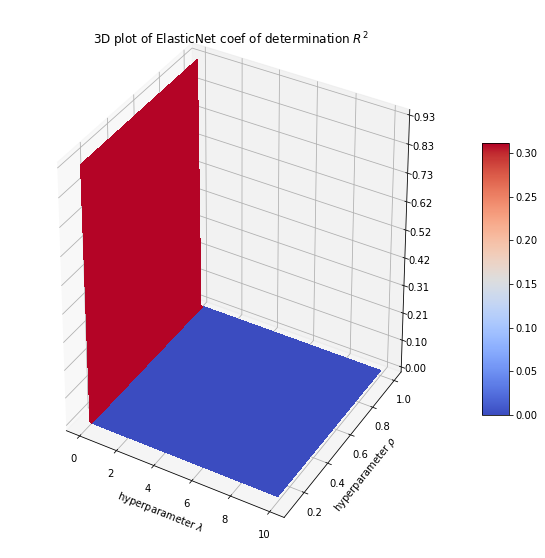

In [685]:
# Elastic Net plot: scores
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
plt.rcParams['figure.figsize'] = (10,10)
fig = plt.figure()
ax = fig.gca(projection='3d')

X = alphas
Y = rhos
X, Y = np.meshgrid(X, Y)
Z = scores


# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# Customize the z axis.
# ax.set_zlim(-0.1, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
plt.title(r'3D plot of ElasticNet coef of determination $R^2$')
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.xlabel(r'hyperparameter $\lambda$')
plt.ylabel(r'hyperparameter $\rho$')

# ax.view_init(30,300)
# plt.savefig("../output/elasticnet_train_validation_score_30_300.png")
# ax.view_init(30,270)
# plt.savefig("../output/elasticnet_train_validation_score_30_270.png")
# ax.view_init(30,240)
# plt.savefig("../output/elasticnet_train_validation_score_30_240.png")

In [761]:
# ## Elastic Net Model Coefficients
# elasticnet_coef_abs = pd.DataFrame({'abs_coef':abs(model_elasticnet.coef_), 'coef': model_elasticnet.coef_}, 
#                               index = xtrain_reduce.columns).sort_values(by = 'abs_coef', ascending = False)
# elasticnet_coef_abs.to_csv("../output/elasticnet_coef_abs.csv")
# display(elasticnet_coef_abs)

In [ ]:
## Elastic Net 

In [768]:
# Elastic Net Error
ytrain_elasticnet = model_elasticnet.predict(xtrain_reduce)
ytest_elasticnet = model_elasticnet.predict(xtest_reduce)

RMSE = np.sqrt(mean_squared_error(ytrain, ytrain_elasticnet))
MSE = mean_squared_error(ytrain, ytrain_elasticnet)
print("Least overfit Elastic Net train MSE", round(MSE, ndigits=4))

MSE2 = mean_squared_error(ytest, ytest_elasticnet)
print("Least overfit Elastic Net validation MSE", round(MSE2, ndigits=4))

Least overfit Elastic Net train MSE 0.0103
Least overfit Elastic Net validation MSE 0.0113


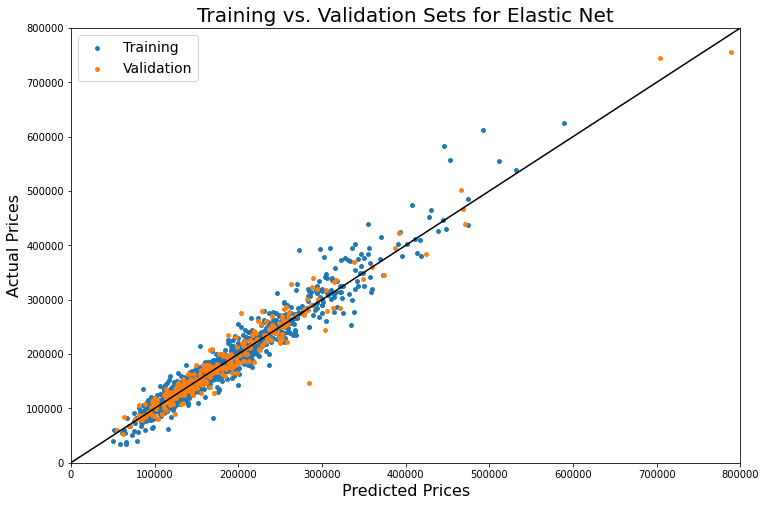

In [170]:
# Plot Elastic Nest Error
plt.figure(figsize=(12,8))
plt.scatter(np.exp(ytrain_lasso), np.exp(ytrain), marker="o", s=15, label = "Training")
plt.scatter(np.exp(ytest_lasso), np.exp(ytest), marker="o", s=15, label="Validation")
plt.title("Training vs. Validation Sets for Elastic Net", fontsize=20)
plt.xlabel("Predicted Prices", fontsize = 16)
plt.ylabel("Actual Prices", fontsize = 16)
plt.legend(loc = "upper left", fontsize = 14)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.plot([0, 800000], [0, 800000], 'black') # ideal predict-
#plt.show()
plt.savefig('../output/elasticnet_train_validation_compare.png')

## 3. Random Forest
<a id='rf'></a>

### _data set preparation: categorical to numeric conversion_

In [772]:
# use ordinal data set
df = traino.copy()
drop_rows = df[df.index.isin([524, 1299])].index # high influential outliers of SalePrice, drop out reason stated in EDA
print("df shape before drop outlier rows:", df.shape) 
df.drop(drop_rows, inplace=True)
print("df shape after drop outlier rows:", df.shape)

df shape before drop outlier rows: (1460, 84)
df shape after drop outlier rows: (1458, 84)


In [773]:
# function to covert categorical data to integer
def text_to_num(x):
    '''get a column as param and return column coded in numeric
    from 1 to len of columns'''
    feature = set(x.to_list())
    #get a mapping of feature with their index from 1
    feature_dict = dict(zip( sorted(feature),range(1,len(feature)+1)))
    return x.map(feature_dict)

#get only categorical columns
text_col = df[~df.applymap(np.isreal)].dropna(axis=1).columns
#transform apply function on text columns and create a temp df
num_col = df[text_col].apply(text_to_num)
#Drop text column and merge data frame to create a full df.
tran_df = pd.concat((df.drop(text_col, axis = 1),num_col), axis=1)
print(tran_df.shape)
#tran_df.head()
'logSalePrice' in df.columns

(1458, 84)


True

In [774]:
## split to train & validation 
xtrain, xtest, ytrain, ytest = train_test_split(tran_df.drop(['SalePrice', 'logSalePrice'], axis = 1), tran_df.logSalePrice, test_size = 0.2, random_state = 4)

### _random search for Random Forest_

In [829]:
## parameter tuning for random forest
params_rf = [{'max_features': range(20,51,10), 'n_estimators': range(500, 1001, 100), 
              'max_depth': range(0,81,10), 'min_samples_leaf': range(10,31,5)}]
kf5 = KFold(n_splits = 5, shuffle = True, random_state = 4)
random_rf = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=4, oob_score = True), 
                               param_distributions = params_rf, return_train_score= True,
                               n_iter = 100, cv = kf5, verbose = 2, random_state=4)
%time random_rf.fit(xtrain, ytrain)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] n_estimators=500, min_samples_leaf=25, max_features=20, max_depth=70 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=500, min_samples_leaf=25, max_features=20, max_depth=70, total=   2.6s
[CV] n_estimators=500, min_samples_leaf=25, max_features=20, max_depth=70 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV]  n_estimators=500, min_samples_leaf=25, max_features=20, max_depth=70, total=   2.4s
[CV] n_estimators=500, min_samples_leaf=25, max_features=20, max_depth=70 
[CV]  n_estimators=500, min_samples_leaf=25, max_features=20, max_depth=70, total=   2.5s
[CV] n_estimators=500, min_samples_leaf=25, max_features=20, max_depth=70 
[CV]  n_estimators=500, min_samples_leaf=25, max_features=20, max_depth=70, total=   2.3s
[CV] n_estimators=500, min_samples_leaf=25, max_features=20, max_depth=70 
[CV]  n_estimators=500, min_samples_leaf=25, max_features=20, max_depth=70, total=   2.3s
[CV] n_estimators=800, min_samples_leaf=20, max_features=20, max_depth=60 
[CV]  n_estimators=800, min_samples_leaf=20, max_features=20, max_depth=60, total=   3.7s
[CV] n_estimators=800, min_samples_leaf=20, max_features=20, max_depth=60 
[CV]  n_estimators=800, min_samples_leaf=20, max_features=20, max_depth=60, total=   3.4s
[CV] n_estimators=800, min_samples_leaf=20, max_features=20, max_depth=60 
[CV]  n_es

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=600, min_samples_leaf=30, max_features=50, max_depth=0, total=   0.4s
[CV] n_estimators=600, min_samples_leaf=30, max_features=50, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=600, min_samples_leaf=30, max_features=50, max_depth=0, total=   0.3s
[CV] n_estimators=600, min_samples_leaf=30, max_features=50, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=600, min_samples_leaf=30, max_features=50, max_depth=0, total=   0.6s
[CV] n_estimators=600, min_samples_leaf=30, max_features=50, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=600, min_samples_leaf=30, max_features=50, max_depth=0, total=   0.4s
[CV] n_estimators=600, min_samples_leaf=30, max_features=50, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=600, min_samples_leaf=30, max_features=50, max_depth=0, total=   0.3s
[CV] n_estimators=900, min_samples_leaf=15, max_features=20, max_depth=40 
[CV]  n_estimators=900, min_samples_leaf=15, max_features=20, max_depth=40, total=   4.2s
[CV] n_estimators=900, min_samples_leaf=15, max_features=20, max_depth=40 
[CV]  n_estimators=900, min_samples_leaf=15, max_features=20, max_depth=40, total=   4.0s
[CV] n_estimators=900, min_samples_leaf=15, max_features=20, max_depth=40 
[CV]  n_estimators=900, min_samples_leaf=15, max_features=20, max_depth=40, total=   5.4s
[CV] n_estimators=900, min_samples_leaf=15, max_features=20, max_depth=40 
[CV]  n_estimators=900, min_samples_leaf=15, max_features=20, max_depth=40, total=   4.3s
[CV] n_estimators=900, min_samples_leaf=15, max_features=20, max_depth=40 
[CV]  n_estimators=900, min_samples_leaf=15, max_features=20, max_depth=40, total=   3.3s
[CV] n_estimators=600, min_samples_leaf=20, max_features=30, max_depth=10 
[CV]  n_est

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=500, min_samples_leaf=15, max_features=40, max_depth=0, total=   0.4s
[CV] n_estimators=500, min_samples_leaf=15, max_features=40, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=500, min_samples_leaf=15, max_features=40, max_depth=0, total=   0.5s
[CV] n_estimators=500, min_samples_leaf=15, max_features=40, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=500, min_samples_leaf=15, max_features=40, max_depth=0, total=   0.4s
[CV] n_estimators=500, min_samples_leaf=15, max_features=40, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=500, min_samples_leaf=15, max_features=40, max_depth=0, total=   0.8s
[CV] n_estimators=500, min_samples_leaf=15, max_features=40, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=500, min_samples_leaf=15, max_features=40, max_depth=0, total=   0.9s
[CV] n_estimators=1000, min_samples_leaf=30, max_features=20, max_depth=70 
[CV]  n_estimators=1000, min_samples_leaf=30, max_features=20, max_depth=70, total=   5.9s
[CV] n_estimators=1000, min_samples_leaf=30, max_features=20, max_depth=70 
[CV]  n_estimators=1000, min_samples_leaf=30, max_features=20, max_depth=70, total=   6.7s
[CV] n_estimators=1000, min_samples_leaf=30, max_features=20, max_depth=70 
[CV]  n_estimators=1000, min_samples_leaf=30, max_features=20, max_depth=70, total=   6.1s
[CV] n_estimators=1000, min_samples_leaf=30, max_features=20, max_depth=70 
[CV]  n_estimators=1000, min_samples_leaf=30, max_features=20, max_depth=70, total=   7.2s
[CV] n_estimators=1000, min_samples_leaf=30, max_features=20, max_depth=70 
[CV]  n_estimators=1000, min_samples_leaf=30, max_features=20, max_depth=70, total=   6.9s
[CV] n_estimators=900, min_samples_leaf=30, max_features=30, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=900, min_samples_leaf=30, max_features=30, max_depth=0, total=   0.8s
[CV] n_estimators=900, min_samples_leaf=30, max_features=30, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=900, min_samples_leaf=30, max_features=30, max_depth=0, total=   0.7s
[CV] n_estimators=900, min_samples_leaf=30, max_features=30, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=900, min_samples_leaf=30, max_features=30, max_depth=0, total=   0.8s
[CV] n_estimators=900, min_samples_leaf=30, max_features=30, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=900, min_samples_leaf=30, max_features=30, max_depth=0, total=   0.7s
[CV] n_estimators=900, min_samples_leaf=30, max_features=30, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=900, min_samples_leaf=30, max_features=30, max_depth=0, total=   0.8s
[CV] n_estimators=800, min_samples_leaf=20, max_features=50, max_depth=10 
[CV]  n_estimators=800, min_samples_leaf=20, max_features=50, max_depth=10, total=   5.9s
[CV] n_estimators=800, min_samples_leaf=20, max_features=50, max_depth=10 
[CV]  n_estimators=800, min_samples_leaf=20, max_features=50, max_depth=10, total=   9.3s
[CV] n_estimators=800, min_samples_leaf=20, max_features=50, max_depth=10 
[CV]  n_estimators=800, min_samples_leaf=20, max_features=50, max_depth=10, total=   7.0s
[CV] n_estimators=800, min_samples_leaf=20, max_features=50, max_depth=10 
[CV]  n_estimators=800, min_samples_leaf=20, max_features=50, max_depth=10, total=   6.8s
[CV] n_estimators=800, min_samples_leaf=20, max_features=50, max_depth=10 
[CV]  n_estimators=800, min_samples_leaf=20, max_features=50, max_depth=10, total=   7.4s
[CV] n_estimators=1000, min_samples_leaf=15, max_features=30, max_depth=10 
[CV]  n_es

[CV]  n_estimators=700, min_samples_leaf=15, max_features=40, max_depth=80, total=   5.1s
[CV] n_estimators=900, min_samples_leaf=20, max_features=40, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=900, min_samples_leaf=20, max_features=40, max_depth=0, total=   0.6s
[CV] n_estimators=900, min_samples_leaf=20, max_features=40, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=900, min_samples_leaf=20, max_features=40, max_depth=0, total=   0.6s
[CV] n_estimators=900, min_samples_leaf=20, max_features=40, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=900, min_samples_leaf=20, max_features=40, max_depth=0, total=   0.8s
[CV] n_estimators=900, min_samples_leaf=20, max_features=40, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=900, min_samples_leaf=20, max_features=40, max_depth=0, total=   0.7s
[CV] n_estimators=900, min_samples_leaf=20, max_features=40, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=900, min_samples_leaf=20, max_features=40, max_depth=0, total=   0.6s
[CV] n_estimators=900, min_samples_leaf=25, max_features=40, max_depth=80 
[CV]  n_estimators=900, min_samples_leaf=25, max_features=40, max_depth=80, total=   6.2s
[CV] n_estimators=900, min_samples_leaf=25, max_features=40, max_depth=80 
[CV]  n_estimators=900, min_samples_leaf=25, max_features=40, max_depth=80, total=   6.2s
[CV] n_estimators=900, min_samples_leaf=25, max_features=40, max_depth=80 
[CV]  n_estimators=900, min_samples_leaf=25, max_features=40, max_depth=80, total=   6.5s
[CV] n_estimators=900, min_samples_leaf=25, max_features=40, max_depth=80 
[CV]  n_estimators=900, min_samples_leaf=25, max_features=40, max_depth=80, total=   6.5s
[CV] n_estimators=900, min_samples_leaf=25, max_features=40, max_depth=80 
[CV]  n_estimators=900, min_samples_leaf=25, max_features=40, max_depth=80, total=   6.9s
[CV] n_estimators=500, min_samples_leaf=25, max_features=50, max_depth=40 
[CV]  n_est

[CV]  n_estimators=1000, min_samples_leaf=30, max_features=30, max_depth=50, total=   5.8s
[CV] n_estimators=800, min_samples_leaf=20, max_features=20, max_depth=70 
[CV]  n_estimators=800, min_samples_leaf=20, max_features=20, max_depth=70, total=   6.5s
[CV] n_estimators=800, min_samples_leaf=20, max_features=20, max_depth=70 
[CV]  n_estimators=800, min_samples_leaf=20, max_features=20, max_depth=70, total=   5.0s
[CV] n_estimators=800, min_samples_leaf=20, max_features=20, max_depth=70 
[CV]  n_estimators=800, min_samples_leaf=20, max_features=20, max_depth=70, total=   4.3s
[CV] n_estimators=800, min_samples_leaf=20, max_features=20, max_depth=70 
[CV]  n_estimators=800, min_samples_leaf=20, max_features=20, max_depth=70, total=   4.8s
[CV] n_estimators=800, min_samples_leaf=20, max_features=20, max_depth=70 
[CV]  n_estimators=800, min_samples_leaf=20, max_features=20, max_depth=70, total=   4.1s
[CV] n_estimators=1000, min_samples_leaf=30, max_features=30, max_depth=10 
[CV]  n_

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=800, min_samples_leaf=10, max_features=40, max_depth=0, total=   0.3s
[CV] n_estimators=800, min_samples_leaf=10, max_features=40, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=800, min_samples_leaf=10, max_features=40, max_depth=0, total=   0.3s
[CV] n_estimators=800, min_samples_leaf=10, max_features=40, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=800, min_samples_leaf=10, max_features=40, max_depth=0, total=   0.4s
[CV] n_estimators=800, min_samples_leaf=10, max_features=40, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=800, min_samples_leaf=10, max_features=40, max_depth=0, total=   0.3s
[CV] n_estimators=800, min_samples_leaf=10, max_features=40, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=800, min_samples_leaf=10, max_features=40, max_depth=0, total=   0.3s
[CV] n_estimators=1000, min_samples_leaf=20, max_features=40, max_depth=80 
[CV]  n_estimators=1000, min_samples_leaf=20, max_features=40, max_depth=80, total=   4.5s
[CV] n_estimators=1000, min_samples_leaf=20, max_features=40, max_depth=80 
[CV]  n_estimators=1000, min_samples_leaf=20, max_features=40, max_depth=80, total=   4.6s
[CV] n_estimators=1000, min_samples_leaf=20, max_features=40, max_depth=80 
[CV]  n_estimators=1000, min_samples_leaf=20, max_features=40, max_depth=80, total=   4.7s
[CV] n_estimators=1000, min_samples_leaf=20, max_features=40, max_depth=80 
[CV]  n_estimators=1000, min_samples_leaf=20, max_features=40, max_depth=80, total=   4.4s
[CV] n_estimators=1000, min_samples_leaf=20, max_features=40, max_depth=80 
[CV]  n_estimators=1000, min_samples_leaf=20, max_features=40, max_depth=80, total=   4.3s
[CV] n_estimators=800, min_samples_leaf=20, max_features=20, max_depth=50 
[

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=700, min_samples_leaf=25, max_features=50, max_depth=0, total=   0.4s
[CV] n_estimators=700, min_samples_leaf=25, max_features=50, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=700, min_samples_leaf=25, max_features=50, max_depth=0, total=   0.3s
[CV] n_estimators=700, min_samples_leaf=25, max_features=50, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=700, min_samples_leaf=25, max_features=50, max_depth=0, total=   0.3s
[CV] n_estimators=700, min_samples_leaf=25, max_features=50, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=700, min_samples_leaf=25, max_features=50, max_depth=0, total=   0.4s
[CV] n_estimators=700, min_samples_leaf=25, max_features=50, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=700, min_samples_leaf=25, max_features=50, max_depth=0, total=   0.4s
[CV] n_estimators=500, min_samples_leaf=10, max_features=40, max_depth=20 
[CV]  n_estimators=500, min_samples_leaf=10, max_features=40, max_depth=20, total=   3.1s
[CV] n_estimators=500, min_samples_leaf=10, max_features=40, max_depth=20 
[CV]  n_estimators=500, min_samples_leaf=10, max_features=40, max_depth=20, total=   3.1s
[CV] n_estimators=500, min_samples_leaf=10, max_features=40, max_depth=20 
[CV]  n_estimators=500, min_samples_leaf=10, max_features=40, max_depth=20, total=   2.8s
[CV] n_estimators=500, min_samples_leaf=10, max_features=40, max_depth=20 
[CV]  n_estimators=500, min_samples_leaf=10, max_features=40, max_depth=20, total=   2.8s
[CV] n_estimators=500, min_samples_leaf=10, max_features=40, max_depth=20 
[CV]  n_estimators=500, min_samples_leaf=10, max_features=40, max_depth=20, total=   2.5s
[CV] n_estimators=500, min_samples_leaf=30, max_features=20, max_depth=70 
[CV]  n_est

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=500, min_samples_leaf=20, max_features=40, max_depth=0, total=   0.2s
[CV] n_estimators=500, min_samples_leaf=20, max_features=40, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=500, min_samples_leaf=20, max_features=40, max_depth=0, total=   0.2s
[CV] n_estimators=500, min_samples_leaf=20, max_features=40, max_depth=0 
[CV]  n_estimators=500, min_samples_leaf=20, max_features=40, max_depth=0, total=   0.2s
[CV] n_estimators=500, min_samples_leaf=20, max_features=40, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=500, min_samples_leaf=20, max_features=40, max_depth=0, total=   0.2s
[CV] n_estimators=800, min_samples_leaf=10, max_features=30, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=800, min_samples_leaf=10, max_features=30, max_depth=0, total=   0.4s
[CV] n_estimators=800, min_samples_leaf=10, max_features=30, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=800, min_samples_leaf=10, max_features=30, max_depth=0, total=   0.4s
[CV] n_estimators=800, min_samples_leaf=10, max_features=30, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=800, min_samples_leaf=10, max_features=30, max_depth=0, total=   0.3s
[CV] n_estimators=800, min_samples_leaf=10, max_features=30, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=800, min_samples_leaf=10, max_features=30, max_depth=0, total=   0.4s
[CV] n_estimators=800, min_samples_leaf=10, max_features=30, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=800, min_samples_leaf=10, max_features=30, max_depth=0, total=   0.6s
[CV] n_estimators=600, min_samples_leaf=20, max_features=50, max_depth=30 
[CV]  n_estimators=600, min_samples_leaf=20, max_features=50, max_depth=30, total=   3.2s
[CV] n_estimators=600, min_samples_leaf=20, max_features=50, max_depth=30 
[CV]  n_estimators=600, min_samples_leaf=20, max_features=50, max_depth=30, total=   3.1s
[CV] n_estimators=600, min_samples_leaf=20, max_features=50, max_depth=30 
[CV]  n_estimators=600, min_samples_leaf=20, max_features=50, max_depth=30, total=   2.9s
[CV] n_estimators=600, min_samples_leaf=20, max_features=50, max_depth=30 
[CV]  n_estimators=600, min_samples_leaf=20, max_features=50, max_depth=30, total=   3.2s
[CV] n_estimators=600, min_samples_leaf=20, max_features=50, max_depth=30 
[CV]  n_estimators=600, min_samples_leaf=20, max_features=50, max_depth=30, total=   3.9s
[CV] n_estimators=600, min_samples_leaf=30, max_features=40, max_depth=70 
[CV]  n_est

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=700, min_samples_leaf=15, max_features=50, max_depth=0, total=   0.3s
[CV] n_estimators=700, min_samples_leaf=15, max_features=50, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=700, min_samples_leaf=15, max_features=50, max_depth=0, total=   0.4s
[CV] n_estimators=700, min_samples_leaf=15, max_features=50, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=700, min_samples_leaf=15, max_features=50, max_depth=0, total=   0.4s
[CV] n_estimators=700, min_samples_leaf=15, max_features=50, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=700, min_samples_leaf=15, max_features=50, max_depth=0, total=   0.4s
[CV] n_estimators=700, min_samples_leaf=15, max_features=50, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=700, min_samples_leaf=15, max_features=50, max_depth=0, total=   0.4s
[CV] n_estimators=700, min_samples_leaf=10, max_features=50, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=700, min_samples_leaf=10, max_features=50, max_depth=0, total=   0.3s
[CV] n_estimators=700, min_samples_leaf=10, max_features=50, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=700, min_samples_leaf=10, max_features=50, max_depth=0, total=   0.3s
[CV] n_estimators=700, min_samples_leaf=10, max_features=50, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=700, min_samples_leaf=10, max_features=50, max_depth=0, total=   0.3s
[CV] n_estimators=700, min_samples_leaf=10, max_features=50, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=700, min_samples_leaf=10, max_features=50, max_depth=0, total=   0.4s
[CV] n_estimators=700, min_samples_leaf=10, max_features=50, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=700, min_samples_leaf=10, max_features=50, max_depth=0, total=   0.5s
[CV] n_estimators=600, min_samples_leaf=30, max_features=40, max_depth=20 
[CV]  n_estimators=600, min_samples_leaf=30, max_features=40, max_depth=20, total=   3.0s
[CV] n_estimators=600, min_samples_leaf=30, max_features=40, max_depth=20 
[CV]  n_estimators=600, min_samples_leaf=30, max_features=40, max_depth=20, total=   2.6s
[CV] n_estimators=600, min_samples_leaf=30, max_features=40, max_depth=20 
[CV]  n_estimators=600, min_samples_leaf=30, max_features=40, max_depth=20, total=   2.4s
[CV] n_estimators=600, min_samples_leaf=30, max_features=40, max_depth=20 
[CV]  n_estimators=600, min_samples_leaf=30, max_features=40, max_depth=20, total=   2.4s
[CV] n_estimators=600, min_samples_leaf=30, max_features=40, max_depth=20 
[CV]  n_estimators=600, min_samples_leaf=30, max_features=40, max_depth=20, total=   2.4s
[CV] n_estimators=1000, min_samples_leaf=30, max_features=30, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=1000, min_samples_leaf=30, max_features=30, max_depth=0, total=   0.5s
[CV] n_estimators=1000, min_samples_leaf=30, max_features=30, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=1000, min_samples_leaf=30, max_features=30, max_depth=0, total=   0.4s
[CV] n_estimators=1000, min_samples_leaf=30, max_features=30, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=1000, min_samples_leaf=30, max_features=30, max_depth=0, total=   0.4s
[CV] n_estimators=1000, min_samples_leaf=30, max_features=30, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=1000, min_samples_leaf=30, max_features=30, max_depth=0, total=   0.4s
[CV] n_estimators=1000, min_samples_leaf=30, max_features=30, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=1000, min_samples_leaf=30, max_features=30, max_depth=0, total=   0.5s
[CV] n_estimators=900, min_samples_leaf=25, max_features=50, max_depth=20 
[CV]  n_estimators=900, min_samples_leaf=25, max_features=50, max_depth=20, total=   4.3s
[CV] n_estimators=900, min_samples_leaf=25, max_features=50, max_depth=20 
[CV]  n_estimators=900, min_samples_leaf=25, max_features=50, max_depth=20, total=   4.1s
[CV] n_estimators=900, min_samples_leaf=25, max_features=50, max_depth=20 
[CV]  n_estimators=900, min_samples_leaf=25, max_features=50, max_depth=20, total=   4.2s
[CV] n_estimators=900, min_samples_leaf=25, max_features=50, max_depth=20 
[CV]  n_estimators=900, min_samples_leaf=25, max_features=50, max_depth=20, total=   4.3s
[CV] n_estimators=900, min_samples_leaf=25, max_features=50, max_depth=20 
[CV]  n_estimators=900, min_samples_leaf=25, max_features=50, max_depth=20, total=   4.3s
[CV] n_estimators=600, min_samples_leaf=20, max_features=30, max_depth=40 
[CV]  n_es

[CV]  n_estimators=900, min_samples_leaf=15, max_features=50, max_depth=20, total=   4.6s
[CV] n_estimators=900, min_samples_leaf=30, max_features=30, max_depth=10 
[CV]  n_estimators=900, min_samples_leaf=30, max_features=30, max_depth=10, total=   3.0s
[CV] n_estimators=900, min_samples_leaf=30, max_features=30, max_depth=10 
[CV]  n_estimators=900, min_samples_leaf=30, max_features=30, max_depth=10, total=   6.2s
[CV] n_estimators=900, min_samples_leaf=30, max_features=30, max_depth=10 
[CV]  n_estimators=900, min_samples_leaf=30, max_features=30, max_depth=10, total=   3.6s
[CV] n_estimators=900, min_samples_leaf=30, max_features=30, max_depth=10 
[CV]  n_estimators=900, min_samples_leaf=30, max_features=30, max_depth=10, total=   3.2s
[CV] n_estimators=900, min_samples_leaf=30, max_features=30, max_depth=10 
[CV]  n_estimators=900, min_samples_leaf=30, max_features=30, max_depth=10, total=   3.2s
[CV] n_estimators=500, min_samples_leaf=30, max_features=50, max_depth=40 
[CV]  n_es

[CV]  n_estimators=800, min_samples_leaf=30, max_features=20, max_depth=10, total=   2.7s
[CV] n_estimators=1000, min_samples_leaf=15, max_features=30, max_depth=30 
[CV]  n_estimators=1000, min_samples_leaf=15, max_features=30, max_depth=30, total=   4.3s
[CV] n_estimators=1000, min_samples_leaf=15, max_features=30, max_depth=30 
[CV]  n_estimators=1000, min_samples_leaf=15, max_features=30, max_depth=30, total=   4.1s
[CV] n_estimators=1000, min_samples_leaf=15, max_features=30, max_depth=30 
[CV]  n_estimators=1000, min_samples_leaf=15, max_features=30, max_depth=30, total=   4.2s
[CV] n_estimators=1000, min_samples_leaf=15, max_features=30, max_depth=30 
[CV]  n_estimators=1000, min_samples_leaf=15, max_features=30, max_depth=30, total=   4.2s
[CV] n_estimators=1000, min_samples_leaf=15, max_features=30, max_depth=30 
[CV]  n_estimators=1000, min_samples_leaf=15, max_features=30, max_depth=30, total=   4.1s
[CV] n_estimators=600, min_samples_leaf=10, max_features=50, max_depth=70 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=900, min_samples_leaf=25, max_features=50, max_depth=0, total=   0.5s
[CV] n_estimators=900, min_samples_leaf=25, max_features=50, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=900, min_samples_leaf=25, max_features=50, max_depth=0, total=   0.6s
[CV] n_estimators=900, min_samples_leaf=25, max_features=50, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=900, min_samples_leaf=25, max_features=50, max_depth=0, total=   0.6s
[CV] n_estimators=900, min_samples_leaf=25, max_features=50, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=900, min_samples_leaf=25, max_features=50, max_depth=0, total=   0.7s
[CV] n_estimators=900, min_samples_leaf=25, max_features=50, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=900, min_samples_leaf=25, max_features=50, max_depth=0, total=   0.9s
[CV] n_estimators=1000, min_samples_leaf=20, max_features=50, max_depth=70 
[CV]  n_estimators=1000, min_samples_leaf=20, max_features=50, max_depth=70, total=   5.4s
[CV] n_estimators=1000, min_samples_leaf=20, max_features=50, max_depth=70 
[CV]  n_estimators=1000, min_samples_leaf=20, max_features=50, max_depth=70, total=   4.8s
[CV] n_estimators=1000, min_samples_leaf=20, max_features=50, max_depth=70 
[CV]  n_estimators=1000, min_samples_leaf=20, max_features=50, max_depth=70, total=   5.0s
[CV] n_estimators=1000, min_samples_leaf=20, max_features=50, max_depth=70 
[CV]  n_estimators=1000, min_samples_leaf=20, max_features=50, max_depth=70, total=   4.8s
[CV] n_estimators=1000, min_samples_leaf=20, max_features=50, max_depth=70 
[CV]  n_estimators=1000, min_samples_leaf=20, max_features=50, max_depth=70, total=   5.0s
[CV] n_estimators=800, min_samples_leaf=25, max_features=20, max_depth=30 
[

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 34.4min finished


CPU times: user 26min 59s, sys: 34.7 s, total: 27min 34s
Wall time: 34min 32s


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
                   error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0...
                                

In [830]:
print("Random Forest best parameters are\n", random_rf.best_params_)
print("Random Forest best validation score is", round(random_rf.best_score_, ndigits=4)) # validation score
print("Random Forest best training score is", round(model_rf.score(xtrain, ytrain), ndigits=4))
print(random_rf.best_estimator_)

Random Forest best parameters are
 {'n_estimators': 1000, 'min_samples_leaf': 10, 'max_features': 30, 'max_depth': 20}
Random Forest best validation score is 0.8589
Random Forest best training score is 0.9117
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=30, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=True,
                      random_state=4, verbose=0, warm_start=False)


In [873]:
scores_rf = pd.DataFrame({'parameters': random_rf.cv_results_['params'],
                         'validation_score':random_rf.cv_results_['mean_test_score'],
                         "train_score":random_rf.cv_results_['mean_train_score']})
scores_rf['score_diff'] = abs(scores_rf.validation_score - scores_rf.train_score)
scores_rf[scores_rf.score_diff == scores_rf.score_diff.min()]['parameters'].values
rf_least_overfit = scores_rf[scores_rf.score_diff == scores_rf.score_diff.min()]

rf_train_score_lof = rf_least_overfit['train_score']
rf_validation_score_lof = rf_least_overfit['validation_score']
rf_params_lof = rf_least_overfit['parameters']
print("Random Forest least overfit train score", rf_train_score_lof)
print("Random Forest least overfit validation score", rf_validation_score_lof)
print("Random Forest least overfit parameters", rf_params_lof)

Random Forest least overfit train score 61    0.837283
Name: train_score, dtype: float64
Random Forest least overfit validation score 61    0.814543
Name: validation_score, dtype: float64
Random Forest least overfit parameters 61    {'n_estimators': 500, 'min_samples_leaf': 30, ...
Name: parameters, dtype: object


In [790]:
# Set Random Forest Model
model_rf = random_rf.best_estimator_
model_rf.fit(xtrain, ytrain)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=30, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=True,
                      random_state=4, verbose=0, warm_start=False)

In [795]:
# Random Forest Error
ytrain_rf = model_rf.predict(xtrain)
ytest_rf = model_rf.predict(xtest)

RMSE = np.sqrt(mean_squared_error(ytrain, ytrain_rf))
MSE = mean_squared_error(ytrain, ytrain_rf)
print("Best Elastic Net train MSE", round(MSE, ndigits=4))

MSE2 = mean_squared_error(ytest, ytest_rf)
print("Best Elastic Net validation MSE", round(MSE2, ndigits=4))

Best Elastic Net train MSE 0.014
Best Elastic Net validation MSE 0.0178


In [421]:
## gridsearch of random forest
# params_rf_grid = [{'max_features': range(0,81,10), 'n_estimators': range(100, 501, 5), 
#               'max_depth': range(10,101,10), 'min_samples_leaf': range(1,21,1),
#              "criterion": ["mse", "mae"]}]

# grid_rf = GridSearchCV(RandomForestRegressor(random_state=4, oob_score = True), params_rf_grid, cv=5, n_jobs=-1, verbose = 2, scoring= "neg_mean_squared_error")
# %time grid_rf.fit(xtrain, ytrain)

In [789]:
# display(grid_rf.best_params_)
# display(grid_rf.best_score_)
# print("The training error is: %.5f" % (1 - grid_rf.score(xtrain, ytrain)))
# print("The test error is: %.5f" % (1 - grid_rf.score(xtest, ytest)))

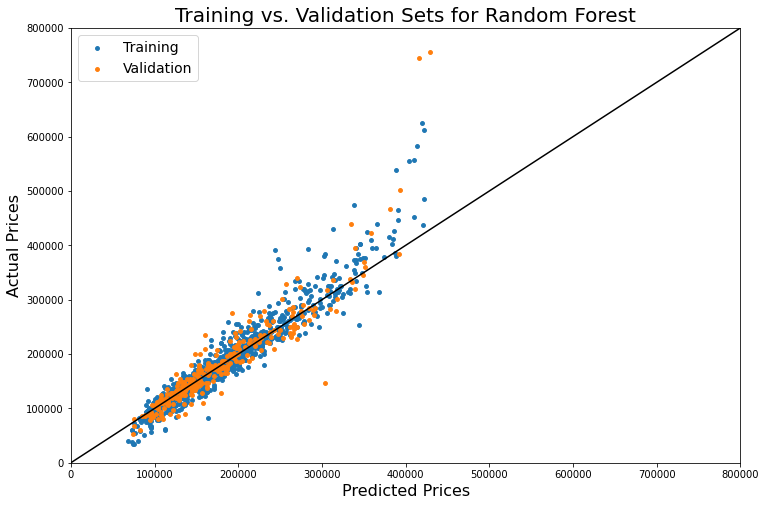

In [803]:
# plot for random forest
## plot error of train vs validataion data
plt.figure(figsize=(12,8))
plt.scatter(np.exp(ytrain_rf), np.exp(ytrain), marker="o", s=15, label = "Training")
plt.scatter(np.exp(ytest_rf), np.exp(ytest), marker="o", s=15, label="Validation")
plt.title("Training vs. Validation Sets for Random Forest", fontsize=20)
plt.xlabel("Predicted Prices", fontsize = 16)
plt.ylabel("Actual Prices", fontsize = 16)
plt.legend(loc = "upper left", fontsize = 14)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.plot([0, 800000], [0, 800000], 'black') # ideal predict
#plt.show()
plt.savefig('../output/randomforest_train_validation_compare.png')

### _single random forest_

In [191]:
rfreg = RandomForestRegressor(random_state=4, max_features=40, oob_score = True, 
                              n_estimators = 700, min_samples_leaf = 20, max_depth = 51)
rfreg.fit(xtrain, ytrain)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=51, max_features=40, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=20,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=700, n_jobs=None, oob_score=True,
                      random_state=4, verbose=0, warm_start=False)

In [804]:
rfreg = RandomForestRegressor(random_state=4, max_features=30, oob_score = True, 
                              n_estimators = 1000, min_samples_leaf = 10, max_depth = 20)
rfreg.fit(xtrain, ytrain)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=30, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=True,
                      random_state=4, verbose=0, warm_start=False)

In [805]:
# random forest prediction
randomforest_pred_train = rfreg.predict(xtrain)
randomforest_pred_test = rfreg.predict(xtest)
MSE = mean_squared_error(ytrain, randomforest_pred_train)
print(f"MSE is {MSE}")
print("train score is", rfreg.score(xtrain, ytrain))
print("oob score is", rfreg.oob_score_)

k5 = KFold(5, random_state=4, shuffle=True)
cv_score = cross_val_score(rfreg, xtrain, ytrain, cv = k5).mean()
print("validation score is", cv_score)

feature_importance = list(zip(xtrain.columns[:], rfreg.feature_importances_))
rf_feature_imp = pd.DataFrame(feature_importance, columns = ["predictor", "importance"]).sort_values(by = "importance", ascending=False)
#rf_feature_imp.to_csv("../output/rf_feature_imp.csv")
display(rf_feature_imp)

MSE is 0.013973422658244404
train score is 0.9117141478907913
oob score is 0.8623413277609362
validation score is 0.8589083018632578


,predictor,importance
4,OverallQual,0.269430
24,GrLivArea,0.151948
9,ExterQual,0.089655
31,KitchenQual,0.054393
6,YearBuilt,0.044665
39,GarageArea,0.043473
38,GarageCars,0.042628
19,TotalBsmtSF,0.040120
21,1stFlrSF,0.034312
52,decade_YearBuilt,0.020962


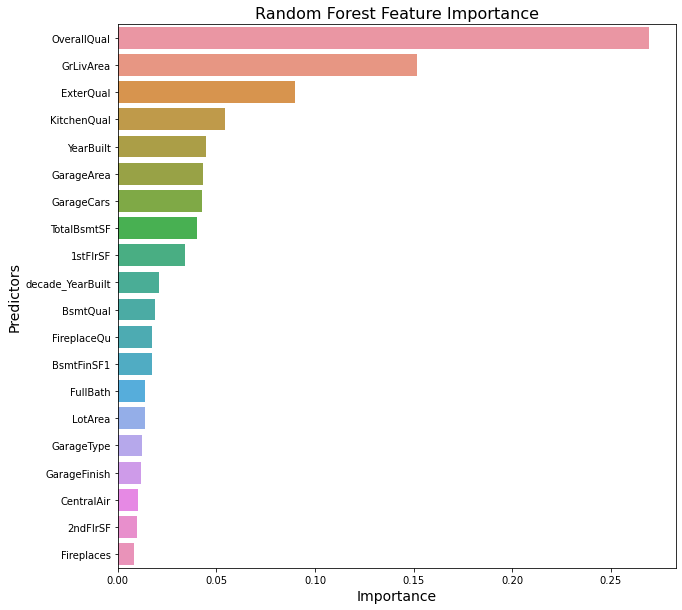

In [812]:
sns.barplot(y = 'predictor', x = 'importance', data = rf_feature_imp[:20])
plt.title("Random Forest Feature Importance", fontsize = 16)
plt.xlabel("Importance", fontsize = 14)
plt.ylabel("Predictors", fontsize = 14)
plt.savefig("../output/randomforest_feature_importance.png")

## Predictive Model Comparison

,Validation_Score,Train_Score,Model
0,0.8225,0.8386,Lasso
1,0.9139,0.9368,Elastic Net
2,0.8589,0.9117,Random Forest


,Validation_MSE,Train_MSE,Model
0,0.0264,0.0264,Lasso
1,0.0113,0.0103,Elastic Net
2,0.0178,0.0140,Random Forest


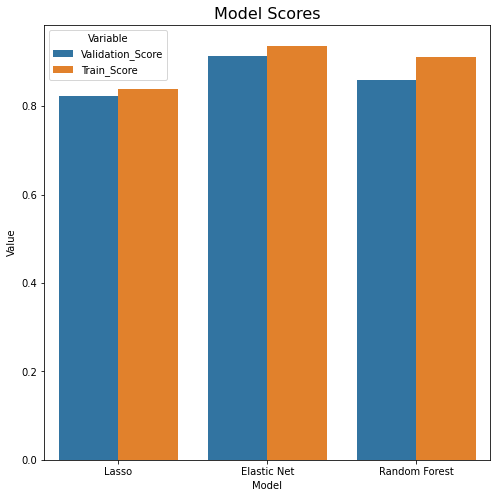

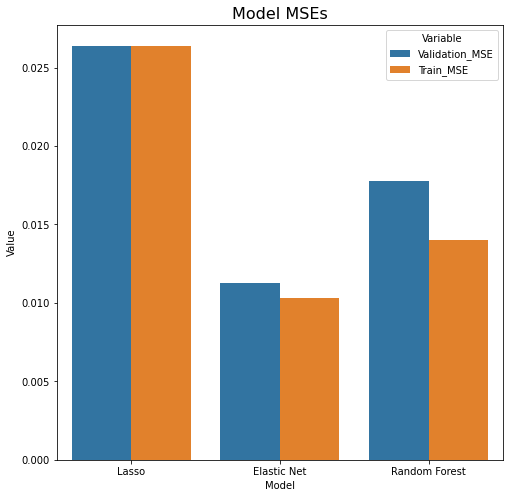

In [814]:
model_score = pd.DataFrame({"Validation_Score":[0.8225, 0.9139, 0.8589], "Train_Score": [0.8386, 0.9368, 0.9117],
               "Model": ['Lasso', "Elastic Net", "Random Forest"]})
model_mse = pd.DataFrame({"Validation_MSE": [0.0264, 0.0113, 0.0178], "Train_MSE": [0.0264, 0.0103, 0.014], 
             "Model": ['Lasso', "Elastic Net", "Random Forest"]})

# sns.barplot(x='Model', y='Train_Score', data=model_score)
fig1,ax1 = plt.subplots(figsize=(8,8))
tidy_score = model_score.melt(id_vars = "Model").rename(columns=str.title)
sns.barplot(x='Model', y='Value', hue='Variable', data = tidy_score, ax=ax1)
plt.title("Model Scores", fontsize = 16)
plt.savefig("../output/model_compare_score.png")

fig2,ax2 = plt.subplots(figsize=(8,8))
tidy_mse = model_mse.melt(id_vars = "Model").rename(columns=str.title)
sns.barplot(x='Model', y='Value', hue='Variable', data = tidy_mse, ax=ax2)
plt.title("Model MSEs", fontsize = 16)
plt.savefig("../output/model_compare_mse.png")

display(model_score)
display(model_mse)

## 4. Multiple Linear Regression 
_**home improvement for homeowners**_
<a id='mlr'></a>

In [ ]:
# features from Lasso?
# multicollinearity still exits, still need to do feature selection / engineer